# Importing Libraries

In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
from tensorflow.keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.applications import VGG19
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, LeakyReLU
from keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils import plot_model
from IPython.display import Audio
import librosa
import random
import matplotlib.pyplot as plt
from keras import Input, Model
from keras.layers import Conv2D, Dropout, BatchNormalization, LeakyReLU, Conv2DTranspose, Activation, Concatenate, Multiply
from tensorflow.keras.utils import plot_model
from keras.losses import BinaryCrossentropy
from pydub import AudioSegment
import numpy as np
from scipy.signal import resample

2024-05-23 10:11:22.886864: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 10:11:22.886989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 10:11:23.014337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install museval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 26.6 MB/s eta 0:00:00


In [3]:
import os
import librosa
import numpy as np
from IPython.display import Audio
import tensorflow as tf
import museval

### Check if TensorFlow can access GPU

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("No GPU devices found.")
else:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured successfully.")

GPU configured successfully.


### Check available GPUs

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate GPU memory growth
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU memory growth set to True")
    except RuntimeError as e:
        print(e)

GPU memory growth set to True


In [6]:
# If TensorFlow can access GPU
num_gpus = len(tf.config.experimental.list_physical_devices('GPU'))

if num_gpus > 0:
    print("Num GPUs Available: ", num_gpus)
    print("TensorFlow is using GPU.")
else:
    print("No GPU available.")

Num GPUs Available:  1
TensorFlow is using GPU.


# Data Loading

In [7]:
def load(audio_file):
    audio = tf.io.read_file(audio_file)
    audio , sr= tf.audio.decode_wav(audio)
    audio = tf.cast(audio,tf.float32)
    return audio[:,0]

#### Find Sample Rate

In [8]:
def increase_SampleRate(audio_file_path,folder_path,filename):
    # Load the audio file
    audio = AudioSegment.from_wav(audio_file_path)

    # Ensure the original sample rate is 8000 Hz
    if audio.frame_rate != 8000:
        return
#         audio = audio.set_frame_rate(8000)

    # Convert audio data to numpy array
    samples = np.array(audio.get_array_of_samples())

    # Calculate the new number of samples for 44100 Hz
    new_length = int(len(samples) * (44100 / 8000))

    # Upsample using scipy's resample function
    resampled_samples = resample(samples, new_length)

    # Create a new AudioSegment with the resampled data
    resampled_audio = AudioSegment(
        resampled_samples.astype(np.int16).tobytes(),
        frame_rate=44100,
        sample_width=audio.sample_width,
        channels=audio.channels
    )

    # Export the resampled audio to a new file
    resampled_audio.export(folder_path+'/'+filename, format="wav")

In [9]:
# Define the folder containing your audio files
path="/kaggle/input/minilibrimix/MiniLibriMix/"
folders = ["train/mix_both","train/mix_clean","val/mix_both","val/mix_clean"]

print('Created Folders in Working Dir')
# Loop through each folder path
for folder in folders:
  # Create the folder using os.makedirs (creates nested directories if needed)
  os.makedirs(folder, exist_ok=True)

print('Processing: Increaseing Sample Rate')
for folder_path in folders:
    # Loop through all files in the folder
    for filename in os.listdir(path+folder_path):
      # Check if it's an audio file
      if filename.endswith(".wav"): 
        # Create the full path to the audio file
        audio_file_path = os.path.join(path+folder_path, filename)
        # Increase sample rate using the function
        increase_SampleRate(audio_file_path,folder_path,filename)
print('Done')

Created Folders in Working Dir
Processing: Increaseing Sample Rate
Done


In [10]:
import wave

# Open the WAV file
with wave.open("/kaggle/working/train/mix_both/7933-112597-0030_534-127538-0015.wav", "r") as wav:
    # Get the sample rate
    sample_rate = wav.getframerate()
    print(f"Sample rate: {sample_rate} Hz")

Sample rate: 44100 Hz


### Load and Check Data

In [11]:
audio = load('/kaggle/working/train/mix_both/7933-112597-0030_534-127538-0015.wav')

In [12]:
audio.shape

TensorShape([510016])

In [13]:
Audio(audio.numpy(), rate=44100)

### Separated Vocals and mixture of vocals and music loaded

In [14]:
mixture_audio = load('/kaggle/working/train/mix_both/7933-112597-0030_534-127538-0015.wav')
vocal_audio = load('/kaggle/working/train/mix_clean/7933-112597-0030_534-127538-0015.wav')

In [15]:
mixture_audio.shape

TensorShape([510016])

In [16]:
vocal_audio.shape

TensorShape([510016])

In [17]:
Audio(mixture_audio.numpy(), rate=44100)

In [18]:
Audio(vocal_audio.numpy(), rate=44100)

(1993, 512)


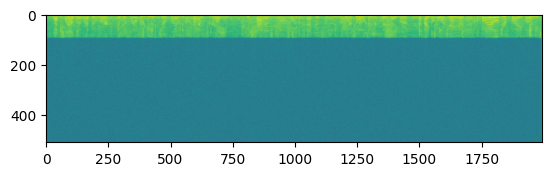

In [19]:

mixture_spectogram = tfio.audio.spectrogram(mixture_audio, nfft = 1022, window = 1022, stride=256)
print(mixture_spectogram.shape)
plt.figure()
plt.imshow(tf.math.log(tf.transpose(mixture_spectogram)).numpy())

(1993, 512)


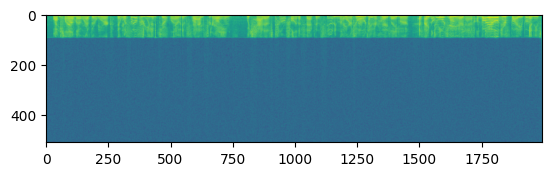

In [20]:
vocal_spectogram = tfio.audio.spectrogram(vocal_audio, nfft = 1022, window = 1022, stride=256)
print(vocal_spectogram.shape)
plt.figure()
plt.imshow(tf.math.log(tf.transpose(vocal_spectogram)).numpy())

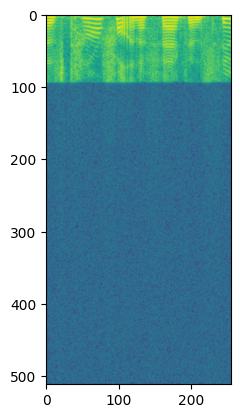

In [21]:
seed1 = random.randint(0,2500)
seed2 = random.randint(0,2500)
vocal_spectogram = tf.image.stateless_random_crop(vocal_spectogram, (256,512), (seed1, seed2))
plt.figure()
plt.imshow(tf.math.log(tf.transpose(vocal_spectogram)).numpy())

In [22]:
def load_train_audio(mixture_audio_path,clean_audio_path):
    mixture = load(mixture_audio_path)
    clean = load(clean_audio_path)
    clean = tfio.audio.spectrogram(clean, nfft = 1022, window = 1022, stride=256)
    mixture = tfio.audio.spectrogram(mixture, nfft = 1022, window = 1022, stride=256)
    seed1 = random.randint(0,2500)
    seed2 = random.randint(0,2500)
    clean = tf.image.stateless_random_crop(clean, (256,512), (seed1, seed2))
    mixture = tf.image.stateless_random_crop(mixture, (256,512), (seed1, seed2))
    clean = tf.reshape(clean,(256,512,1))
    mixture = tf.reshape(mixture,(256,512,1))
    return mixture, clean

In [23]:
BATCH_SIZE = 32

### Create input pipeline

In [24]:
mixed_audio_pattern = "/kaggle/working/train/mix_both/*.wav"
clean_audio_pattern = "/kaggle/working/train/mix_both/*.wav"

# Create separate datasets for mixed and clean audio
mixed_dataset = tf.data.Dataset.list_files(mixed_audio_pattern)
clean_dataset = tf.data.Dataset.list_files(clean_audio_pattern)

# Combine datasets using zip (assuming datasets have the same length)
train_dataset = tf.data.Dataset.zip((mixed_dataset, clean_dataset))

# Map the combined dataset to your load_train_audio function
train_dataset = train_dataset.map(lambda mixed_filename, clean_filename: load_train_audio(mixed_filename, clean_filename))
train_dataset = train_dataset.shuffle(10).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 512, 1), dtype=tf.float32, name=None))>

In [25]:
mixed_audio_pattern = "/kaggle/working/val/mix_both/*.wav"
clean_audio_pattern = "/kaggle/working/val/mix_both/*.wav"

# Create separate datasets for mixed and clean audio
mixed_dataset = tf.data.Dataset.list_files(mixed_audio_pattern)
clean_dataset = tf.data.Dataset.list_files(clean_audio_pattern)

# Combine datasets using zip (assuming datasets have the same length)
validation_dataset = tf.data.Dataset.zip((mixed_dataset, clean_dataset))

# Map the combined dataset to your load_train_audio function
validation_dataset = validation_dataset.map(lambda mixed_filename, clean_filename: load_train_audio(mixed_filename, clean_filename))
validation_dataset = validation_dataset.shuffle(10).batch(BATCH_SIZE)
validation_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 512, 1), dtype=tf.float32, name=None))>

In [26]:
# train_dataset = tf.data.Dataset.list_files('/kaggle/input/minilibrimix/MiniLibriMix/train/mix_both/*.wav','/kaggle/input/minilibrimix/MiniLibriMix/train/mix_clean/*.wav')
# train_dataset = train_dataset.map(load_train_audio)
# train_dataset = train_dataset.shuffle(10).batch(BATCH_SIZE)
# train_dataset

In [27]:
# validation_dataset = tf.data.Dataset.list_files('/kaggle/input/music-gan2/vocal_neplai_GAN/vocal_neplai_GAN/val/*.wav')
# validation_dataset = validation_dataset.map(load_train_audio)
# validation_dataset = validation_dataset.batch(BATCH_SIZE)
# validation_dataset

# Model Strucutre

### Strucutre for Generator

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 256, 64)         1664      ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 128, 256, 64)         0         ['batch_normalization[0][0

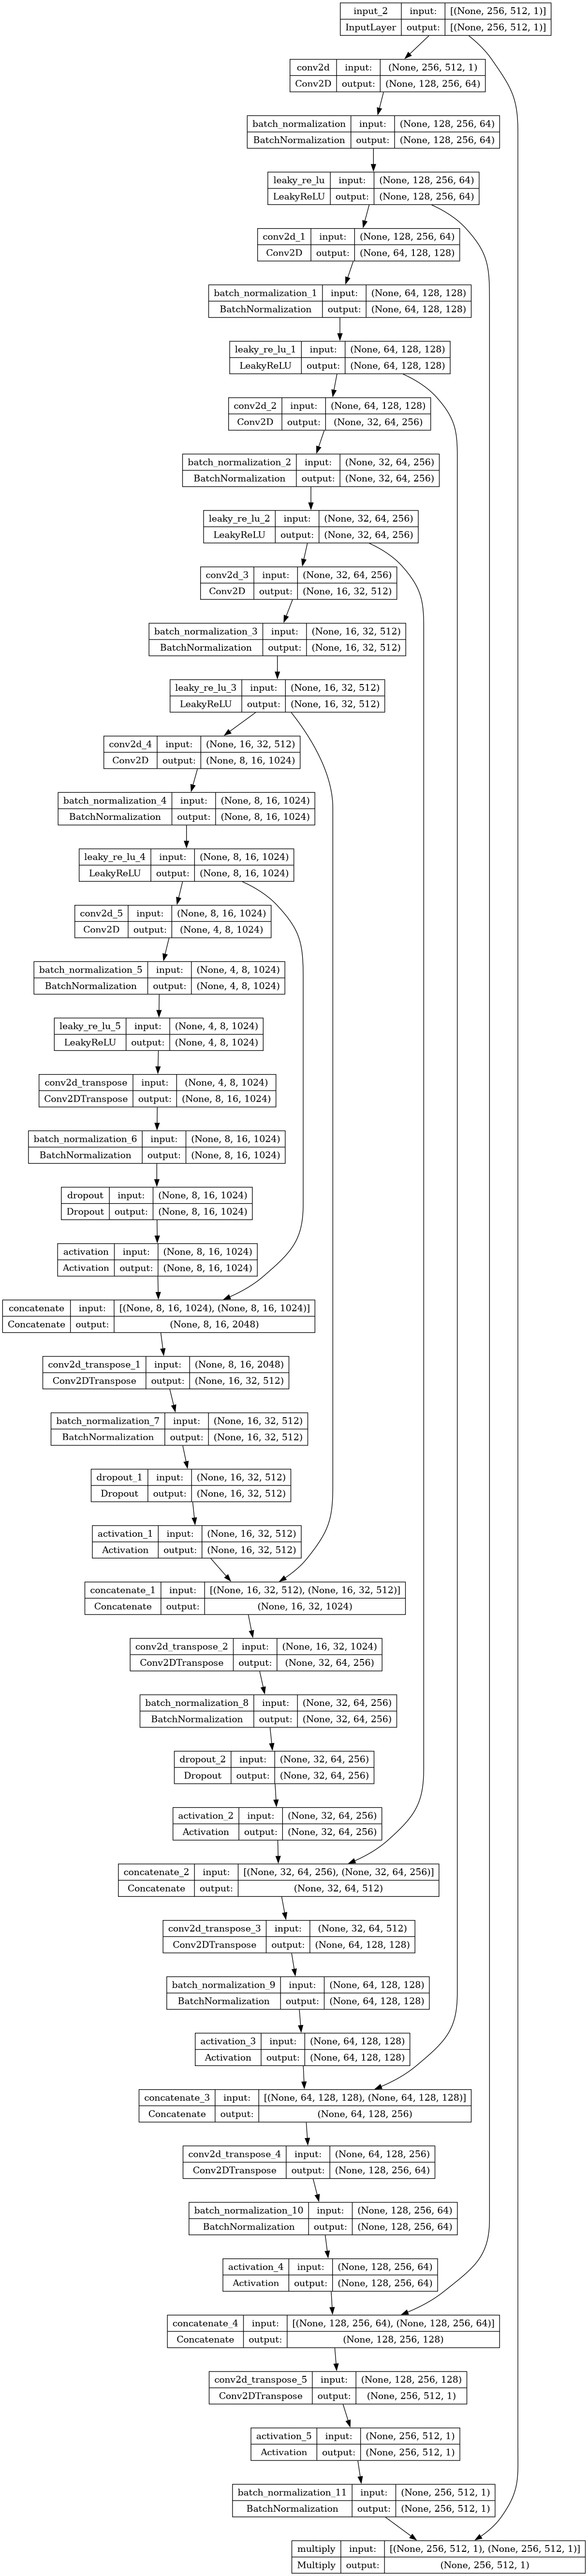

In [28]:
def unet(inputs=Input((256, 512, 1))):
    conv1 = Conv2D(64, 5, strides=2, padding='same')(inputs)
    conv1 = BatchNormalization(axis=-1)(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)

    conv2 = Conv2D(128, 5, strides=2, padding='same')(conv1)
    conv2 = BatchNormalization(axis=-1)(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)

    conv3 = Conv2D(256, 5, strides=2, padding='same')(conv2)
    conv3 = BatchNormalization(axis=-1)(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)

    conv4 = Conv2D(512, 5, strides=2, padding='same')(conv3)
    conv4 = BatchNormalization(axis=-1)(conv4)
    conv4 = LeakyReLU(alpha=0.2)(conv4)

    conv5 = Conv2D(1024, 5, strides=2, padding='same')(conv4)
    conv5 = BatchNormalization(axis=-1)(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)

    conv6 = Conv2D(1024, 5, strides=2, padding='same')(conv5)
    conv6 = BatchNormalization(axis=-1)(conv6)
    conv6 = LeakyReLU(alpha=0.2)(conv6)

    deconv7 = Conv2DTranspose(1024, 5, strides=2, padding='same')(conv6)
    deconv7 = BatchNormalization(axis=-1)(deconv7)
    deconv7 = Dropout(0.5)(deconv7)
    deconv7 = Activation('relu')(deconv7)

    deconv8 = Concatenate(axis=-1)([deconv7, conv5])
    deconv8 = Conv2DTranspose(512, 5, strides=2, padding='same')(deconv8)
    deconv8 = BatchNormalization(axis=-1)(deconv8)
    deconv8 = Dropout(0.5)(deconv8)
    deconv8 = Activation('relu')(deconv8)

    deconv9 = Concatenate(axis=-1)([deconv8, conv4])
    deconv9 = Conv2DTranspose(256, 5, strides=2, padding='same')(deconv9)
    deconv9 = BatchNormalization(axis=-1)(deconv9)
    deconv9 = Dropout(0.5)(deconv9)
    deconv9 = Activation('relu')(deconv9)

    deconv10 = Concatenate(axis=-1)([deconv9, conv3])
    deconv10 = Conv2DTranspose(128, 5, strides=2, padding='same')(deconv10)
    deconv10 = BatchNormalization(axis=-1)(deconv10)
    deconv10 = Activation('relu')(deconv10)

    deconv11 = Concatenate(axis=-1)([deconv10, conv2])
    deconv11 = Conv2DTranspose(64, 5, strides=2, padding='same')(deconv11)
    deconv11 = BatchNormalization(axis=-1)(deconv11)
    deconv11 = Activation('relu')(deconv11)

    deconv12 = Concatenate(axis=-1)([deconv11, conv1])
    deconv12 = Conv2DTranspose(1, 5, strides=2, padding='same')(deconv12)
    deconv12 = Activation('relu')(deconv12)
    deconv12 = BatchNormalization(axis=-1)(deconv12)

    output = Multiply()([deconv12, inputs])
    return Model(inputs=inputs, outputs=output)



inputs = Input((256, 512, 1))
gen = unet(inputs)
gen.summary()
plot_model(gen, to_file='/kaggle/working/model_plot.png', show_shapes=True, show_layer_names=True)

### Downsample block

In [29]:
def downsample(filters, size,dropout=False, batchnorm = True):
    init = tf.random_normal_initializer(0.,0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    if batchnorm == True:
        result.add(BatchNormalization())
    if dropout == True :
        result.add(Dropout(0.3))
    result.add(LeakyReLU())
    return result

### Discriminator Structure

In [30]:
def discriminator():
    init = tf.random_normal_initializer(0., 0.02)

    inp = Input(shape = [256, 512, 1], name = "mixture")
    tar = Input(shape = [256, 512, 1], name = "seperated")
    x = Concatenate()([inp, tar])
    down1 = downsample(32,4,False)(x)
    down2 = downsample(62, 4)(down1)
    down3 = downsample(128, 4)(down2)

    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(256, 4, strides = 1, kernel_initializer = init, use_bias = False)(zero_pad1)
    leaky_relu = LeakyReLU()(conv)
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides = 1, kernel_initializer=init)(zero_pad2)
    return Model(inputs = [inp, tar], outputs = last)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mixture (InputLayer)        [(None, 256, 512, 1)]        0         []                            
                                                                                                  
 seperated (InputLayer)      [(None, 256, 512, 1)]        0         []                            
                                                                                                  
 concatenate_5 (Concatenate  (None, 256, 512, 2)          0         ['mixture[0][0]',             
 )                                                                   'seperated[0][0]']           
                                                                                                  
 sequential (Sequential)     (None, 128, 256, 32)         1152      ['concatenate_5[0][0]'] 

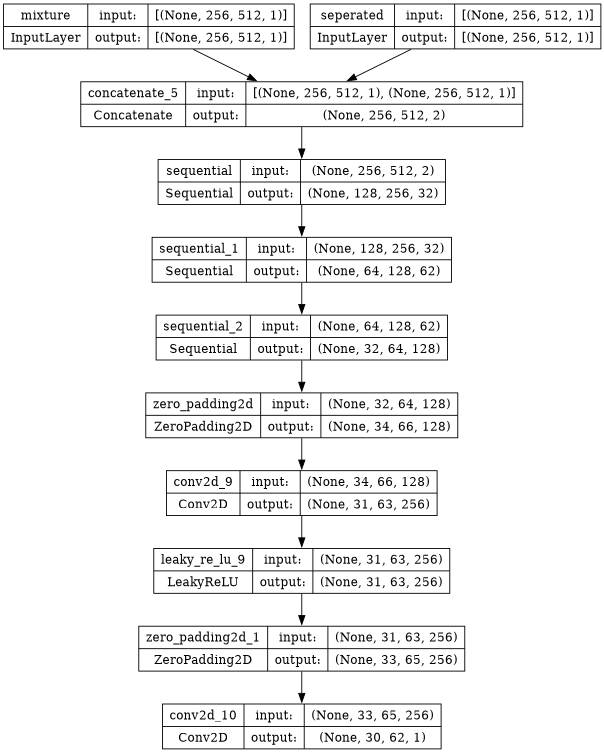

In [31]:
disc = discriminator()
disc.summary()
plot_model(disc, show_shapes=True, dpi = 64)

In [32]:
loss_function = BinaryCrossentropy(from_logits=True)

### Losses

In [33]:
def generator_loss(disc_generated_output,input_, gen_output, target):
    gan_loss = loss_function(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + 100 * l1_loss 
    return total_gen_loss, gan_loss, l1_loss

In [34]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_function(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_function(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss, real_loss, generated_loss

In [35]:
generator_optimizer = Adam(lr= 5e-3, beta_1=0.5)
discriminator_optimizer = Adam(lr = 5e-3, beta_1=0.5)

# Training

In [36]:
@tf.function
def train_step(mixture, target, epoch, training_discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = gen(mixture, training=True)
        disc_real_output = disc([mixture, target], training=True)
        disc_generated_output = disc([mixture, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output,mixture, gen_output, target)
        disc_loss, disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)

        if epoch > 8:
            if training_discriminator:
                discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
                discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))
            else:
                generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
                generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
        else:
            generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
            discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
            generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))

        return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss,disc_real_loss, disc_generated_loss

In [37]:
@tf.function
def validation_step(mixture, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = gen(mixture, training=False)
        disc_real_output = disc([mixture, target], training=False)
        disc_generated_output = disc([mixture, gen_output], training=False)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output,mixture, gen_output, target)
        disc_loss, disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)
        return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss,disc_real_loss, disc_generated_loss

In [38]:
each_epoch_train_generator_losses = []
each_epoch_train_generator_gan_losses = []
each_epoch_train_generator_l1_losses = []
each_epoch_train_discriminator_losses = []
each_epoch_train_discriminator_real_losses = []
each_epoch_train_discriminator_generated_losses = []
each_epoch_test_generator_losses = []
each_epoch_test_generator_gan_losses = []
each_epoch_test_generator_l1_losses = []
each_epoch_test_discriminator_losses = []
each_epoch_test_discriminator_real_losses = []
each_epoch_test_discriminator_generated_losses = []
train_generator_losses = []
train_generator_gan_losses = []
train_generator_l1_losses = []
train_discriminator_losses = []
train_discriminator_real_losses = []
train_discriminator_generated_losses = []
test_generator_losses = []
test_generator_gan_losses = []
test_generator_l1_losses = []
test_discriminator_losses = []
test_discriminator_real_losses = []
test_discriminator_generated_losses =[]
each_epoch_all_records = []
all_records = []
def fit(train_ds, epochs, test_ds, gen_model):
    global each_epoch_train_generator_losses, each_epoch_train_generator_gan_losses, each_epoch_train_generator_l1_losses, each_epoch_train_discriminator_losses,each_epoch_train_discriminator_real_losses, each_epoch_train_discriminator_generated_losses
    global each_epoch_test_generator_losses, each_epoch_test_generator_gan_losses, each_epoch_test_generator_l1_losses, each_epoch_test_discriminator_losses, each_epoch_test_discriminator_real_losses, each_epoch_test_discriminator_generated_losses
    global train_generator_losses, train_generator_gan_losses, train_generator_l1_losses,train_discriminator_real_losses, train_discriminator_generated_losses, test_generator_losses, test_generator_gan_losses, test_generator_l1_losses,test_discriminator_losses, test_discriminator_real_losses, test_discriminator_generated_losses
    global all_records, each_epoch_all_records
    
    # Initialize counters and flags
    consecutive_epochs_high_loss = 0
    training_discriminator = True
    stop_training = False
    min_learning_rate = 1e-7  # Set your desired minimum learning rate
    time_start = time.time()
    
    for ep in range(epochs):
        epoch = ep
        start = time.time()
        train_count = 0
        test_count = 0

        print(f"Epoch {epoch}")

        for n, (input_, target) in train_ds.enumerate():
            if epoch > 10:
                train_gen_loss, train_gen_gan_loss, train_gen_l1_loss, train_disc_loss, train_disc_real_loss, train_disc_generated_loss = train_step(input_, target, epoch, training_discriminator=training_discriminator)

            else:
                # If epoch is less than or equal to 10, train both generator and discriminator
                train_gen_loss, train_gen_gan_loss, train_gen_l1_loss, train_disc_loss, train_disc_real_loss, train_disc_generated_loss  = train_step(input_, target, epoch, training_discriminator=None)

            each_epoch_train_generator_losses.append(train_gen_loss)
            each_epoch_train_generator_gan_losses.append(train_gen_gan_loss)
            each_epoch_train_generator_l1_losses.append(train_gen_l1_loss)
            each_epoch_train_discriminator_losses.append(train_disc_loss)
            each_epoch_train_discriminator_real_losses.append(train_disc_real_loss)
            each_epoch_train_discriminator_generated_losses.append(train_disc_generated_loss)
            train_count += 1
        print("Training Details")
        print("Generator-- total_loss:{:.5f} gan_loss:{:.5f} l1_loss:{:.5f} Discriminator-- total_loss:{:.5f} real_loss:{:.5f} generated_loss:{:.5f}".format(np.mean(each_epoch_train_generator_losses),np.mean(each_epoch_train_generator_gan_losses), np.mean(each_epoch_train_generator_l1_losses), np.mean(each_epoch_train_discriminator_losses), np.mean(each_epoch_train_discriminator_generated_losses), np.mean(each_epoch_train_discriminator_real_losses)))
        print("Time taken for epoch {} is {} sec".format(epoch + 1, time.time() - start))
        print(f"Number of iteration {train_count}")

        train_generator_losses.append(np.mean(each_epoch_train_generator_losses))
        train_generator_gan_losses.append(np.mean(each_epoch_train_generator_gan_losses))
        train_generator_l1_losses.append(np.mean(each_epoch_train_generator_l1_losses))
        train_discriminator_losses.append(np.mean(each_epoch_train_discriminator_losses))
        train_discriminator_real_losses.append(np.mean(each_epoch_train_discriminator_real_losses))
        train_discriminator_generated_losses.append(np.mean(each_epoch_train_discriminator_generated_losses))
        # Test
        for n, (input_, target) in test_ds.enumerate():
            test_gen_loss, test_gen_gan_loss, test_gen_l1_loss, test_disc_loss, test_disc_real_loss, test_disc_generated_loss, = validation_step(input_, target)
            test_count += 1

            each_epoch_test_generator_losses.append(test_gen_loss)
            each_epoch_test_generator_gan_losses.append(test_gen_gan_loss)
            each_epoch_test_generator_l1_losses.append(test_gen_l1_loss)
            each_epoch_test_discriminator_losses.append(test_disc_loss)
            each_epoch_test_discriminator_real_losses.append(test_disc_real_loss)
            each_epoch_test_discriminator_generated_losses.append(test_disc_generated_loss)
    
        print("Validation Details")
        print("Generator-- total_loss:{:.5f} gan_loss:{:.5f} l1_loss:{:.5f}  Discriminator-- total_loss:{:.5f} real_loss:{:.5f} generated_loss:{:.5f}".format(np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses),np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses)))
        print("Time taken for epoch {} is {} sec".format(epoch+1, time.time() - start))
        print(f"Number of iteration {test_count}")
        test_generator_losses.append(np.mean(each_epoch_test_generator_losses))
        test_generator_gan_losses.append(np.mean(each_epoch_test_generator_gan_losses))
        test_generator_l1_losses.append(np.mean(each_epoch_test_generator_l1_losses))
        test_discriminator_losses.append(np.mean(each_epoch_test_discriminator_losses))
        test_discriminator_real_losses.append(np.mean(each_epoch_test_discriminator_real_losses))
        test_discriminator_generated_losses.append(np.mean(each_epoch_test_discriminator_generated_losses))
        each_epoch_all_records.append([np.mean(each_epoch_train_generator_losses),np.mean(each_epoch_train_generator_gan_losses), np.mean(each_epoch_train_generator_l1_losses), np.mean(each_epoch_train_discriminator_losses), np.mean(each_epoch_train_discriminator_generated_losses), np.mean(each_epoch_train_discriminator_real_losses), np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses),np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses)])
        all_records.append(each_epoch_all_records)
        # emptying for next epoch
        each_epoch_test_ssim = []
        each_epoch_test_generator_losses = []
        each_epoch_test_generator_gan_losses = []
        each_epoch_test_generator_l1_losses = []
        each_epoch_test_discriminator_losses = []
        each_epoch_test_discriminator_real_losses = []
        each_epoch_test_discriminator_generated_losses = []
        each_epoch_train_generator_losses = []
        each_epoch_train_generator_gan_losses = []
        each_epoch_train_generator_l1_losses = []
        each_epoch_train_discriminator_losses = []
        each_epoch_train_discriminator_real_losses = []
        each_epoch_train_discriminator_generated_losses = []
        if time.time() - time_start > 41000:
            stop_training = True
        # Check if the difference between two consecutive epochs for the last 5 epochs is less than 1
        if ep > 10:
            # Check 1f the difference between two consecutive epochs for the last S epochs is less than 1 or 0.3
            last_epochs_losses = train_discriminator_losses[-5:] if training_discriminator else train_generator_losses[-5:]
            if all(((last_epochs_losses[i] - last_epochs_losses[i - 1])) < 0.01 if training_discriminator else ((last_epochs_losses[1] - last_epochs_losses[i - 1])) < 0.05 for i in range(1, 5)):
                consecutive_epochs_high_loss += 1
            else:
                consecutive_epochs_high_loss = 0
        
        
        if consecutive_epochs_high_loss == 4:
            if training_discriminator:
                current_lr = generator_optimizer. learning_rate.numpy()
                new_lr = max (current_lr * 0.45, min_learning_rate)
                if new_lr > min_learning_rate:
                    generator_optimizer.learning_rate.assign(new_lr)
                    print (f"Reduced generator learning rate to {new_lr} at epoch {epoch + 1}")
                    # Switch training focus
                    training_discriminator = not training_discriminator
                else:
                    print(f"Generator learning rate already at the minimum. Stopping training.")
                    stop_training = True
            else:
                current_lr = discriminator_optimizer.learning_rate.numpy()
                new_lr = max (current_lr * 0.3, min_learning_rate)
                if new_lr > min_learning_rate:
                    discriminator_optimizer.learning_rate.assign(new_lr)
                    print(f"Reduced discriminator learning rate to {new_lr} at epoch {epoch + 1}.")
                    # Switch training focus
                    training_discriminator = not training_discriminator
                else:
                    print(f"Discriminator learning rate already at the minimum. Stopping training.")
                    stop_training = True

                consecutive_epochs_high_loss = 0
        # Check the flag variable
        if stop_training:
            break


In [39]:
fit(train_dataset, 500, validation_dataset,gen)

Epoch 0


2024-05-23 10:14:23.870030: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1716459273.809829      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training Details
Generator-- total_loss:29.58438 gan_loss:4.08368 l1_loss:0.25501 Discriminator-- total_loss:0.51028 real_loss:0.29867 generated_loss:0.21160
Time taken for epoch 1 is 56.82185411453247 sec
Number of iteration 25
Validation Details
Generator-- total_loss:23.07058 gan_loss:1.33475 l1_loss:0.21736  Discriminator-- total_loss:1.60344 real_loss:0.31646 generated_loss:1.28698
Time taken for epoch 1 is 62.955124855041504 sec
Number of iteration 7
Epoch 1
Training Details
Generator-- total_loss:25.98450 gan_loss:4.05936 l1_loss:0.21925 Discriminator-- total_loss:1.70372 real_loss:0.72605 generated_loss:0.97767
Time taken for epoch 2 is 27.29563021659851 sec
Number of iteration 25
Validation Details
Generator-- total_loss:21.43146 gan_loss:0.72586 l1_loss:0.20706  Discriminator-- total_loss:1.35627 real_loss:0.69979 generated_loss:0.65648
Time taken for epoch 2 is 30.862457513809204 sec
Number of iteration 7
Epoch 2


2024-05-23 10:15:53.739936: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:22.03687 gan_loss:2.31114 l1_loss:0.19726 Discriminator-- total_loss:0.74135 real_loss:0.49695 generated_loss:0.24439
Time taken for epoch 3 is 27.721999168395996 sec
Number of iteration 25
Validation Details
Generator-- total_loss:20.88748 gan_loss:0.75551 l1_loss:0.20132  Discriminator-- total_loss:1.41070 real_loss:0.68944 generated_loss:0.72126
Time taken for epoch 3 is 31.283138513565063 sec
Number of iteration 7
Epoch 3
Training Details
Generator-- total_loss:20.75984 gan_loss:1.90927 l1_loss:0.18851 Discriminator-- total_loss:0.89019 real_loss:0.44991 generated_loss:0.44027
Time taken for epoch 4 is 27.246594667434692 sec
Number of iteration 25
Validation Details
Generator-- total_loss:27.75945 gan_loss:0.62089 l1_loss:0.27139  Discriminator-- total_loss:1.49181 real_loss:1.02174 generated_loss:0.47008
Time taken for epoch 4 is 30.739311695098877 sec
Number of iteration 7
Epoch 4


2024-05-23 10:16:55.538348: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:20.20750 gan_loss:2.30486 l1_loss:0.17903 Discriminator-- total_loss:0.77903 real_loss:0.38523 generated_loss:0.39381
Time taken for epoch 5 is 27.83713984489441 sec
Number of iteration 25
Validation Details
Generator-- total_loss:25.97757 gan_loss:0.95754 l1_loss:0.25020  Discriminator-- total_loss:2.04045 real_loss:1.15804 generated_loss:0.88241
Time taken for epoch 5 is 31.35832905769348 sec
Number of iteration 7
Epoch 5
Training Details
Generator-- total_loss:20.42546 gan_loss:2.37889 l1_loss:0.18047 Discriminator-- total_loss:0.71141 real_loss:0.33225 generated_loss:0.37916
Time taken for epoch 6 is 27.960845470428467 sec
Number of iteration 25
Validation Details
Generator-- total_loss:50.36361 gan_loss:1.54367 l1_loss:0.48820  Discriminator-- total_loss:1.86875 real_loss:0.38835 generated_loss:1.48040
Time taken for epoch 6 is 31.492423057556152 sec
Number of iteration 7
Epoch 6


2024-05-23 10:17:58.769902: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:20.54155 gan_loss:1.83479 l1_loss:0.18707 Discriminator-- total_loss:0.89102 real_loss:0.46119 generated_loss:0.42983
Time taken for epoch 7 is 28.096200704574585 sec
Number of iteration 25
Validation Details
Generator-- total_loss:21.22293 gan_loss:2.03081 l1_loss:0.19192  Discriminator-- total_loss:1.91984 real_loss:0.21552 generated_loss:1.70432
Time taken for epoch 7 is 31.5838680267334 sec
Number of iteration 7
Epoch 7
Training Details
Generator-- total_loss:20.23100 gan_loss:1.80654 l1_loss:0.18424 Discriminator-- total_loss:0.91307 real_loss:0.44836 generated_loss:0.46470
Time taken for epoch 8 is 27.927297353744507 sec
Number of iteration 25
Validation Details
Generator-- total_loss:19.89623 gan_loss:1.23496 l1_loss:0.18661  Discriminator-- total_loss:1.58770 real_loss:0.38522 generated_loss:1.20247
Time taken for epoch 8 is 31.46843147277832 sec
Number of iteration 7
Epoch 8


2024-05-23 10:19:01.359441: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:20.30496 gan_loss:1.81516 l1_loss:0.18490 Discriminator-- total_loss:0.83629 real_loss:0.47247 generated_loss:0.36382
Time taken for epoch 9 is 27.818934202194214 sec
Number of iteration 25
Validation Details
Generator-- total_loss:22.77805 gan_loss:1.86059 l1_loss:0.20917  Discriminator-- total_loss:2.01358 real_loss:0.23038 generated_loss:1.78321
Time taken for epoch 9 is 31.286420106887817 sec
Number of iteration 7
Epoch 9
Training Details
Generator-- total_loss:19.81103 gan_loss:1.11452 l1_loss:0.18697 Discriminator-- total_loss:0.84989 real_loss:0.52685 generated_loss:0.32305
Time taken for epoch 10 is 27.150196313858032 sec
Number of iteration 25
Validation Details
Generator-- total_loss:19.79041 gan_loss:1.15143 l1_loss:0.18639  Discriminator-- total_loss:1.54832 real_loss:0.41319 generated_loss:1.13512
Time taken for epoch 10 is 30.55289340019226 sec
Number of iteration 7
Epoch 10


2024-05-23 10:20:02.782973: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:19.67093 gan_loss:1.04596 l1_loss:0.18625 Discriminator-- total_loss:0.94017 real_loss:0.62387 generated_loss:0.31630
Time taken for epoch 11 is 27.086519241333008 sec
Number of iteration 25
Validation Details
Generator-- total_loss:20.54648 gan_loss:0.82455 l1_loss:0.19722  Discriminator-- total_loss:1.40069 real_loss:0.63845 generated_loss:0.76224
Time taken for epoch 11 is 30.62440776824951 sec
Number of iteration 7
Epoch 11
Training Details
Generator-- total_loss:20.45934 gan_loss:1.47247 l1_loss:0.18987 Discriminator-- total_loss:1.16849 real_loss:0.51503 generated_loss:0.65346
Time taken for epoch 12 is 25.90609574317932 sec
Number of iteration 25
Validation Details
Generator-- total_loss:20.13768 gan_loss:0.30399 l1_loss:0.19834  Discriminator-- total_loss:2.33177 real_loss:2.07611 generated_loss:0.25566
Time taken for epoch 12 is 29.51069688796997 sec
Number of iteration 7
Epoch 12
Training Details
Generator-- total_loss:21.09508 gan_loss

2024-05-23 10:21:32.138624: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:24.10940 gan_loss:5.10116 l1_loss:0.19008 Discriminator-- total_loss:0.03279 real_loss:0.01714 generated_loss:0.01565
Time taken for epoch 14 is 25.768154859542847 sec
Number of iteration 25
Validation Details
Generator-- total_loss:19.77638 gan_loss:0.28102 l1_loss:0.19495  Discriminator-- total_loss:9.48113 real_loss:9.41397 generated_loss:0.06716
Time taken for epoch 14 is 29.320232152938843 sec
Number of iteration 7
Epoch 14
Training Details
Generator-- total_loss:25.55916 gan_loss:6.56204 l1_loss:0.18997 Discriminator-- total_loss:0.01106 real_loss:0.00573 generated_loss:0.00533
Time taken for epoch 15 is 25.623637199401855 sec
Number of iteration 25
Validation Details
Generator-- total_loss:19.59271 gan_loss:0.33214 l1_loss:0.19261  Discriminator-- total_loss:9.72454 real_loss:9.65970 generated_loss:0.06484
Time taken for epoch 15 is 29.09982657432556 sec
Number of iteration 7
Epoch 15
Training Details
Generator-- total_loss:26.59221 gan_lo

2024-05-23 10:22:59.252744: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:27.39540 gan_loss:8.39496 l1_loss:0.19000 Discriminator-- total_loss:0.00262 real_loss:0.00138 generated_loss:0.00124
Time taken for epoch 17 is 25.261679649353027 sec
Number of iteration 25
Validation Details
Generator-- total_loss:19.74905 gan_loss:0.37053 l1_loss:0.19379  Discriminator-- total_loss:9.09366 real_loss:9.04199 generated_loss:0.05167
Time taken for epoch 17 is 29.113905668258667 sec
Number of iteration 7
Epoch 17
Training Details
Generator-- total_loss:27.78127 gan_loss:8.78808 l1_loss:0.18993 Discriminator-- total_loss:0.00213 real_loss:0.00111 generated_loss:0.00102
Time taken for epoch 18 is 24.892287969589233 sec
Number of iteration 25
Validation Details
Generator-- total_loss:19.56437 gan_loss:0.38223 l1_loss:0.19182  Discriminator-- total_loss:8.81975 real_loss:8.76673 generated_loss:0.05301
Time taken for epoch 18 is 28.274200677871704 sec
Number of iteration 7
Epoch 18
Training Details
Generator-- total_loss:28.17305 gan_l

2024-05-23 10:24:25.446198: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.73150 gan_loss:0.65158 l1_loss:0.21080 Discriminator-- total_loss:9.43904 real_loss:9.43852 generated_loss:0.00052
Time taken for epoch 20 is 26.5722393989563 sec
Number of iteration 25
Validation Details
Generator-- total_loss:61.33234 gan_loss:0.00928 l1_loss:0.61323  Discriminator-- total_loss:11.44705 real_loss:11.44543 generated_loss:0.00162
Time taken for epoch 20 is 29.988104343414307 sec
Number of iteration 7
Epoch 20
Training Details
Generator-- total_loss:19.69163 gan_loss:0.08710 l1_loss:0.19605 Discriminator-- total_loss:7.60546 real_loss:7.60488 generated_loss:0.00058
Time taken for epoch 21 is 26.622360944747925 sec
Number of iteration 25
Validation Details
Generator-- total_loss:22.63409 gan_loss:0.00232 l1_loss:0.22632  Discriminator-- total_loss:9.59114 real_loss:9.59042 generated_loss:0.00072
Time taken for epoch 21 is 30.04924464225769 sec
Number of iteration 7
Epoch 21


2024-05-23 10:25:25.544626: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:18.73537 gan_loss:0.18472 l1_loss:0.18551 Discriminator-- total_loss:6.59129 real_loss:6.59080 generated_loss:0.00048
Time taken for epoch 22 is 26.561448097229004 sec
Number of iteration 25
Validation Details
Generator-- total_loss:19.83710 gan_loss:0.01229 l1_loss:0.19825  Discriminator-- total_loss:8.47403 real_loss:8.47328 generated_loss:0.00076
Time taken for epoch 22 is 30.09520125389099 sec
Number of iteration 7
Epoch 22
Training Details
Generator-- total_loss:17.97194 gan_loss:0.17205 l1_loss:0.17800 Discriminator-- total_loss:4.61060 real_loss:4.60997 generated_loss:0.00062
Time taken for epoch 23 is 27.431981563568115 sec
Number of iteration 25
Validation Details
Generator-- total_loss:20.51186 gan_loss:0.01692 l1_loss:0.20495  Discriminator-- total_loss:7.62005 real_loss:7.61885 generated_loss:0.00120
Time taken for epoch 23 is 30.980297327041626 sec
Number of iteration 7
Epoch 23


2024-05-23 10:26:26.577594: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:18.02714 gan_loss:0.13005 l1_loss:0.17897 Discriminator-- total_loss:5.06651 real_loss:5.06601 generated_loss:0.00051
Time taken for epoch 24 is 27.121864557266235 sec
Number of iteration 25
Validation Details
Generator-- total_loss:18.32745 gan_loss:0.00294 l1_loss:0.18325  Discriminator-- total_loss:7.06860 real_loss:7.06704 generated_loss:0.00156
Time taken for epoch 24 is 30.574294805526733 sec
Number of iteration 7
Epoch 24
Training Details
Generator-- total_loss:17.64335 gan_loss:0.14740 l1_loss:0.17496 Discriminator-- total_loss:4.08719 real_loss:4.08662 generated_loss:0.00058
Time taken for epoch 25 is 26.937946796417236 sec
Number of iteration 25
Validation Details
Generator-- total_loss:18.37952 gan_loss:0.00360 l1_loss:0.18376  Discriminator-- total_loss:6.58124 real_loss:6.57887 generated_loss:0.00238
Time taken for epoch 25 is 30.662739753723145 sec
Number of iteration 7
Epoch 25


2024-05-23 10:27:27.961544: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:17.82625 gan_loss:0.16158 l1_loss:0.17665 Discriminator-- total_loss:4.85057 real_loss:4.85002 generated_loss:0.00055
Time taken for epoch 26 is 28.230067253112793 sec
Number of iteration 25
Validation Details
Generator-- total_loss:19.39995 gan_loss:0.00682 l1_loss:0.19393  Discriminator-- total_loss:6.51680 real_loss:6.51437 generated_loss:0.00243
Time taken for epoch 26 is 31.612029790878296 sec
Number of iteration 7
Epoch 26
Training Details
Generator-- total_loss:18.03239 gan_loss:0.17901 l1_loss:0.17853 Discriminator-- total_loss:5.14690 real_loss:5.14629 generated_loss:0.00061
Time taken for epoch 27 is 27.162967205047607 sec
Number of iteration 25
Validation Details
Generator-- total_loss:18.12426 gan_loss:0.00359 l1_loss:0.18121  Discriminator-- total_loss:6.38608 real_loss:6.38338 generated_loss:0.00270
Time taken for epoch 27 is 30.715890407562256 sec
Number of iteration 7
Epoch 27


2024-05-23 10:28:30.281263: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:17.30813 gan_loss:0.14123 l1_loss:0.17167 Discriminator-- total_loss:2.97028 real_loss:2.96970 generated_loss:0.00058
Time taken for epoch 28 is 27.399478435516357 sec
Number of iteration 25
Validation Details
Generator-- total_loss:18.35898 gan_loss:0.00545 l1_loss:0.18354  Discriminator-- total_loss:5.94781 real_loss:5.94404 generated_loss:0.00377
Time taken for epoch 28 is 31.06368112564087 sec
Number of iteration 7
Epoch 28
Training Details
Generator-- total_loss:17.54566 gan_loss:0.12429 l1_loss:0.17421 Discriminator-- total_loss:4.74683 real_loss:4.74621 generated_loss:0.00062
Time taken for epoch 29 is 27.2403724193573 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.25988 gan_loss:0.00451 l1_loss:0.17255  Discriminator-- total_loss:6.00169 real_loss:5.99820 generated_loss:0.00350
Time taken for epoch 29 is 30.63287591934204 sec
Number of iteration 7
Epoch 29


2024-05-23 10:29:31.812843: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:17.32038 gan_loss:0.13172 l1_loss:0.17189 Discriminator-- total_loss:3.90053 real_loss:3.89985 generated_loss:0.00068
Time taken for epoch 30 is 26.603254556655884 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.14658 gan_loss:0.00480 l1_loss:0.17142  Discriminator-- total_loss:5.90321 real_loss:5.89926 generated_loss:0.00394
Time taken for epoch 30 is 30.088674306869507 sec
Number of iteration 7
Epoch 30
Training Details
Generator-- total_loss:17.79670 gan_loss:0.20234 l1_loss:0.17594 Discriminator-- total_loss:5.61479 real_loss:5.61427 generated_loss:0.00052
Time taken for epoch 31 is 26.513027906417847 sec
Number of iteration 25
Validation Details
Generator-- total_loss:18.47431 gan_loss:0.00469 l1_loss:0.18470  Discriminator-- total_loss:6.18654 real_loss:6.18328 generated_loss:0.00326
Time taken for epoch 31 is 29.939558744430542 sec
Number of iteration 7
Epoch 31
Training Details
Generator-- total_loss:17.61530 gan_l

2024-05-23 10:31:01.832053: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:17.29273 gan_loss:0.12540 l1_loss:0.17167 Discriminator-- total_loss:3.89319 real_loss:3.89259 generated_loss:0.00060
Time taken for epoch 33 is 26.362069368362427 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.64918 gan_loss:0.00478 l1_loss:0.17644  Discriminator-- total_loss:5.95807 real_loss:5.95425 generated_loss:0.00382
Time taken for epoch 33 is 30.102611303329468 sec
Number of iteration 7
Epoch 33
Training Details
Generator-- total_loss:17.54590 gan_loss:0.15550 l1_loss:0.17390 Discriminator-- total_loss:4.90798 real_loss:4.90746 generated_loss:0.00052
Time taken for epoch 34 is 26.132789373397827 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.23909 gan_loss:0.00418 l1_loss:0.17235  Discriminator-- total_loss:6.08806 real_loss:6.08433 generated_loss:0.00372
Time taken for epoch 34 is 29.569818258285522 sec
Number of iteration 7
Epoch 34


2024-05-23 10:32:01.956856: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:17.32437 gan_loss:0.15028 l1_loss:0.17174 Discriminator-- total_loss:4.05300 real_loss:4.05245 generated_loss:0.00054
Time taken for epoch 35 is 26.73066759109497 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.48213 gan_loss:0.00514 l1_loss:0.17477  Discriminator-- total_loss:5.81928 real_loss:5.81490 generated_loss:0.00439
Time taken for epoch 35 is 30.211007118225098 sec
Number of iteration 7
Epoch 35
Training Details
Generator-- total_loss:17.37467 gan_loss:0.15125 l1_loss:0.17223 Discriminator-- total_loss:4.64723 real_loss:4.64673 generated_loss:0.00050
Time taken for epoch 36 is 28.438649892807007 sec
Number of iteration 25
Validation Details
Generator-- total_loss:18.29704 gan_loss:0.00615 l1_loss:0.18291  Discriminator-- total_loss:5.94552 real_loss:5.94144 generated_loss:0.00408
Time taken for epoch 36 is 32.31759428977966 sec
Number of iteration 7
Epoch 36


2024-05-23 10:33:04.540148: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:17.17201 gan_loss:0.12737 l1_loss:0.17045 Discriminator-- total_loss:3.61642 real_loss:3.61581 generated_loss:0.00061
Time taken for epoch 37 is 26.880190134048462 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.12809 gan_loss:0.00526 l1_loss:0.17123  Discriminator-- total_loss:5.76957 real_loss:5.76518 generated_loss:0.00438
Time taken for epoch 37 is 30.355244159698486 sec
Number of iteration 7
Epoch 37
Training Details
Generator-- total_loss:17.28080 gan_loss:0.13676 l1_loss:0.17144 Discriminator-- total_loss:4.35926 real_loss:4.35872 generated_loss:0.00054
Time taken for epoch 38 is 26.939143896102905 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.97631 gan_loss:0.00518 l1_loss:0.16971  Discriminator-- total_loss:5.79933 real_loss:5.79495 generated_loss:0.00438
Time taken for epoch 38 is 30.475233554840088 sec
Number of iteration 7
Epoch 38


2024-05-23 10:34:04.845134: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:17.28987 gan_loss:0.13551 l1_loss:0.17154 Discriminator-- total_loss:4.18445 real_loss:4.18394 generated_loss:0.00051
Time taken for epoch 39 is 26.83444619178772 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.34020 gan_loss:0.00494 l1_loss:0.17335  Discriminator-- total_loss:5.86687 real_loss:5.86279 generated_loss:0.00407
Time taken for epoch 39 is 30.206059455871582 sec
Number of iteration 7
Epoch 39
Training Details
Generator-- total_loss:17.09118 gan_loss:0.18602 l1_loss:0.16905 Discriminator-- total_loss:3.44587 real_loss:3.44532 generated_loss:0.00054
Time taken for epoch 40 is 27.0132417678833 sec
Number of iteration 25
Validation Details
Generator-- total_loss:18.67641 gan_loss:0.00670 l1_loss:0.18670  Discriminator-- total_loss:5.85930 real_loss:5.85477 generated_loss:0.00453
Time taken for epoch 40 is 30.50058913230896 sec
Number of iteration 7
Epoch 40


2024-05-23 10:35:05.755182: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:17.30341 gan_loss:0.10414 l1_loss:0.17199 Discriminator-- total_loss:4.29150 real_loss:4.29098 generated_loss:0.00052
Time taken for epoch 41 is 27.059693336486816 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.06203 gan_loss:0.00557 l1_loss:0.17056  Discriminator-- total_loss:5.83882 real_loss:5.83446 generated_loss:0.00436
Time taken for epoch 41 is 30.495259761810303 sec
Number of iteration 7
Epoch 41
Training Details
Generator-- total_loss:17.01887 gan_loss:0.11990 l1_loss:0.16899 Discriminator-- total_loss:3.62305 real_loss:3.62245 generated_loss:0.00059
Time taken for epoch 42 is 27.58543062210083 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.75373 gan_loss:0.00529 l1_loss:0.16748  Discriminator-- total_loss:5.75956 real_loss:5.75534 generated_loss:0.00422
Time taken for epoch 42 is 30.9754900932312 sec
Number of iteration 7
Epoch 42


2024-05-23 10:36:07.037849: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:17.11331 gan_loss:0.13965 l1_loss:0.16974 Discriminator-- total_loss:3.91614 real_loss:3.91540 generated_loss:0.00074
Time taken for epoch 43 is 27.13838219642639 sec
Number of iteration 25
Validation Details
Generator-- total_loss:18.77542 gan_loss:0.00725 l1_loss:0.18768  Discriminator-- total_loss:6.03844 real_loss:6.03447 generated_loss:0.00397
Time taken for epoch 43 is 30.571150541305542 sec
Number of iteration 7
Epoch 43
Training Details
Generator-- total_loss:17.64213 gan_loss:0.19184 l1_loss:0.17450 Discriminator-- total_loss:5.59926 real_loss:5.59877 generated_loss:0.00049
Time taken for epoch 44 is 27.0747652053833 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.51812 gan_loss:0.00457 l1_loss:0.17514  Discriminator-- total_loss:6.13937 real_loss:6.13602 generated_loss:0.00335
Time taken for epoch 44 is 30.544211387634277 sec
Number of iteration 7
Epoch 44


2024-05-23 10:37:08.220248: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:17.04163 gan_loss:0.11983 l1_loss:0.16922 Discriminator-- total_loss:3.88167 real_loss:3.88031 generated_loss:0.00136
Time taken for epoch 45 is 27.129037857055664 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.79642 gan_loss:0.00987 l1_loss:0.17787  Discriminator-- total_loss:6.00726 real_loss:6.00341 generated_loss:0.00385
Time taken for epoch 45 is 30.55370831489563 sec
Number of iteration 7
Epoch 45
Training Details
Generator-- total_loss:17.21268 gan_loss:0.15335 l1_loss:0.17059 Discriminator-- total_loss:4.19095 real_loss:4.19037 generated_loss:0.00058
Time taken for epoch 46 is 27.19283175468445 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.72257 gan_loss:0.00512 l1_loss:0.17717  Discriminator-- total_loss:6.13621 real_loss:6.13238 generated_loss:0.00383
Time taken for epoch 46 is 30.619404792785645 sec
Number of iteration 7
Epoch 46


2024-05-23 10:38:09.330409: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:17.06212 gan_loss:0.13797 l1_loss:0.16924 Discriminator-- total_loss:3.88242 real_loss:3.88190 generated_loss:0.00052
Time taken for epoch 47 is 27.067903518676758 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.30330 gan_loss:0.00727 l1_loss:0.17296  Discriminator-- total_loss:5.69372 real_loss:5.68866 generated_loss:0.00506
Time taken for epoch 47 is 30.53891396522522 sec
Number of iteration 7
Epoch 47
Training Details
Generator-- total_loss:16.85781 gan_loss:0.12501 l1_loss:0.16733 Discriminator-- total_loss:3.32065 real_loss:3.32004 generated_loss:0.00061
Time taken for epoch 48 is 27.00859570503235 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.78138 gan_loss:0.00676 l1_loss:0.16775  Discriminator-- total_loss:5.45556 real_loss:5.44958 generated_loss:0.00598
Time taken for epoch 48 is 30.452075004577637 sec
Number of iteration 7
Epoch 48


2024-05-23 10:39:10.403001: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.76095 gan_loss:0.11091 l1_loss:0.16650 Discriminator-- total_loss:3.33058 real_loss:3.33004 generated_loss:0.00054
Time taken for epoch 49 is 27.229126930236816 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.64001 gan_loss:0.00800 l1_loss:0.16632  Discriminator-- total_loss:5.25349 real_loss:5.24625 generated_loss:0.00724
Time taken for epoch 49 is 30.733846187591553 sec
Number of iteration 7
Epoch 49
Training Details
Generator-- total_loss:17.16800 gan_loss:0.15168 l1_loss:0.17016 Discriminator-- total_loss:4.67234 real_loss:4.67170 generated_loss:0.00064
Time taken for epoch 50 is 26.93445658683777 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.55095 gan_loss:0.00733 l1_loss:0.16544  Discriminator-- total_loss:5.58682 real_loss:5.58125 generated_loss:0.00557
Time taken for epoch 50 is 30.44960856437683 sec
Number of iteration 7
Epoch 50


2024-05-23 10:40:11.730335: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.92753 gan_loss:0.16517 l1_loss:0.16762 Discriminator-- total_loss:3.67789 real_loss:3.67736 generated_loss:0.00053
Time taken for epoch 51 is 26.90853762626648 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.59064 gan_loss:0.00942 l1_loss:0.17581  Discriminator-- total_loss:5.36512 real_loss:5.35860 generated_loss:0.00652
Time taken for epoch 51 is 30.405034065246582 sec
Number of iteration 7
Epoch 51
Training Details
Generator-- total_loss:16.84746 gan_loss:0.11121 l1_loss:0.16736 Discriminator-- total_loss:3.71741 real_loss:3.71678 generated_loss:0.00063
Time taken for epoch 52 is 27.031734466552734 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.75246 gan_loss:0.00958 l1_loss:0.16743  Discriminator-- total_loss:5.12194 real_loss:5.11364 generated_loss:0.00830
Time taken for epoch 52 is 30.87043523788452 sec
Number of iteration 7
Epoch 52


2024-05-23 10:41:12.774187: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.74748 gan_loss:0.14314 l1_loss:0.16604 Discriminator-- total_loss:3.54377 real_loss:3.54322 generated_loss:0.00054
Time taken for epoch 53 is 26.585501432418823 sec
Number of iteration 25
Validation Details
Generator-- total_loss:18.51274 gan_loss:0.04089 l1_loss:0.18472  Discriminator-- total_loss:4.98402 real_loss:4.97420 generated_loss:0.00982
Time taken for epoch 53 is 30.5534348487854 sec
Number of iteration 7
Epoch 53
Training Details
Generator-- total_loss:16.71660 gan_loss:0.11356 l1_loss:0.16603 Discriminator-- total_loss:3.46064 real_loss:3.45993 generated_loss:0.00071
Time taken for epoch 54 is 26.930715560913086 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.68627 gan_loss:0.01496 l1_loss:0.16671  Discriminator-- total_loss:4.81117 real_loss:4.80010 generated_loss:0.01107
Time taken for epoch 54 is 30.399589776992798 sec
Number of iteration 7
Epoch 54


2024-05-23 10:42:14.078746: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.74391 gan_loss:0.12724 l1_loss:0.16617 Discriminator-- total_loss:3.89014 real_loss:3.88961 generated_loss:0.00052
Time taken for epoch 55 is 27.090161561965942 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.23446 gan_loss:0.01127 l1_loss:0.16223  Discriminator-- total_loss:4.95194 real_loss:4.94133 generated_loss:0.01062
Time taken for epoch 55 is 30.559030055999756 sec
Number of iteration 7
Epoch 55
Training Details
Generator-- total_loss:16.75549 gan_loss:0.15501 l1_loss:0.16600 Discriminator-- total_loss:4.02309 real_loss:4.02256 generated_loss:0.00054
Time taken for epoch 56 is 27.485561847686768 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.57141 gan_loss:0.01019 l1_loss:0.16561  Discriminator-- total_loss:5.09704 real_loss:5.08781 generated_loss:0.00923
Time taken for epoch 56 is 30.95473885536194 sec
Number of iteration 7
Epoch 56


2024-05-23 10:43:15.423001: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.59635 gan_loss:0.13815 l1_loss:0.16458 Discriminator-- total_loss:3.45535 real_loss:3.45486 generated_loss:0.00049
Time taken for epoch 57 is 26.97954750061035 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.77674 gan_loss:0.03442 l1_loss:0.17742  Discriminator-- total_loss:5.03078 real_loss:5.02013 generated_loss:0.01065
Time taken for epoch 57 is 30.508212566375732 sec
Number of iteration 7
Epoch 57
Training Details
Generator-- total_loss:16.67612 gan_loss:0.15221 l1_loss:0.16524 Discriminator-- total_loss:3.83291 real_loss:3.83242 generated_loss:0.00049
Time taken for epoch 58 is 27.421172618865967 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.17099 gan_loss:0.01617 l1_loss:0.17155  Discriminator-- total_loss:4.87023 real_loss:4.85839 generated_loss:0.01184
Time taken for epoch 58 is 30.87563920021057 sec
Number of iteration 7
Epoch 58


2024-05-23 10:44:16.679175: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.55218 gan_loss:0.12866 l1_loss:0.16424 Discriminator-- total_loss:3.59507 real_loss:3.59442 generated_loss:0.00065
Time taken for epoch 59 is 27.174439430236816 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.39551 gan_loss:0.01370 l1_loss:0.16382  Discriminator-- total_loss:4.79879 real_loss:4.78589 generated_loss:0.01291
Time taken for epoch 59 is 30.620869159698486 sec
Number of iteration 7
Epoch 59
Training Details
Generator-- total_loss:16.51135 gan_loss:0.13986 l1_loss:0.16371 Discriminator-- total_loss:3.37353 real_loss:3.37302 generated_loss:0.00050
Time taken for epoch 60 is 27.302897691726685 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.40358 gan_loss:0.01511 l1_loss:0.16388  Discriminator-- total_loss:4.70206 real_loss:4.68743 generated_loss:0.01463
Time taken for epoch 60 is 30.819860696792603 sec
Number of iteration 7
Epoch 60


2024-05-23 10:45:18.260285: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.64172 gan_loss:0.15754 l1_loss:0.16484 Discriminator-- total_loss:3.86503 real_loss:3.86441 generated_loss:0.00062
Time taken for epoch 61 is 27.351685047149658 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.16415 gan_loss:0.01495 l1_loss:0.16149  Discriminator-- total_loss:4.77631 real_loss:4.76230 generated_loss:0.01401
Time taken for epoch 61 is 30.800363779067993 sec
Number of iteration 7
Epoch 61
Training Details
Generator-- total_loss:17.30280 gan_loss:0.19134 l1_loss:0.17111 Discriminator-- total_loss:4.87128 real_loss:4.87077 generated_loss:0.00051
Time taken for epoch 62 is 27.4332857131958 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.50329 gan_loss:0.00739 l1_loss:0.16496  Discriminator-- total_loss:5.48700 real_loss:5.48034 generated_loss:0.00666
Time taken for epoch 62 is 30.97135090827942 sec
Number of iteration 7
Epoch 62


2024-05-23 10:46:19.956512: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.70191 gan_loss:0.11897 l1_loss:0.16583 Discriminator-- total_loss:3.89109 real_loss:3.89059 generated_loss:0.00050
Time taken for epoch 63 is 27.357810497283936 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.08585 gan_loss:0.00861 l1_loss:0.16077  Discriminator-- total_loss:5.47936 real_loss:5.47210 generated_loss:0.00726
Time taken for epoch 63 is 30.877995014190674 sec
Number of iteration 7
Epoch 63
Training Details
Generator-- total_loss:16.98705 gan_loss:0.12999 l1_loss:0.16857 Discriminator-- total_loss:4.69141 real_loss:4.69076 generated_loss:0.00065
Time taken for epoch 64 is 27.462255001068115 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.07820 gan_loss:0.00679 l1_loss:0.16071  Discriminator-- total_loss:5.70746 real_loss:5.70135 generated_loss:0.00611
Time taken for epoch 64 is 31.032451629638672 sec
Number of iteration 7
Epoch 64


2024-05-23 10:47:22.037738: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.55586 gan_loss:0.19488 l1_loss:0.16361 Discriminator-- total_loss:3.48039 real_loss:3.47975 generated_loss:0.00064
Time taken for epoch 65 is 27.472216606140137 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.07845 gan_loss:0.00936 l1_loss:0.17069  Discriminator-- total_loss:5.20930 real_loss:5.20026 generated_loss:0.00904
Time taken for epoch 65 is 30.999257802963257 sec
Number of iteration 7
Epoch 65
Training Details
Generator-- total_loss:16.52887 gan_loss:0.11661 l1_loss:0.16412 Discriminator-- total_loss:3.70120 real_loss:3.70046 generated_loss:0.00074
Time taken for epoch 66 is 27.84920573234558 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.93115 gan_loss:0.01024 l1_loss:0.16921  Discriminator-- total_loss:5.11339 real_loss:5.10369 generated_loss:0.00970
Time taken for epoch 66 is 31.323073863983154 sec
Number of iteration 7
Epoch 66


2024-05-23 10:48:24.098053: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.46485 gan_loss:0.12259 l1_loss:0.16342 Discriminator-- total_loss:3.66223 real_loss:3.66164 generated_loss:0.00058
Time taken for epoch 67 is 27.482413053512573 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.48487 gan_loss:0.01150 l1_loss:0.16473  Discriminator-- total_loss:5.00326 real_loss:4.99257 generated_loss:0.01069
Time taken for epoch 67 is 31.02097725868225 sec
Number of iteration 7
Epoch 67
Training Details
Generator-- total_loss:16.38602 gan_loss:0.14559 l1_loss:0.16240 Discriminator-- total_loss:3.52323 real_loss:3.52259 generated_loss:0.00064
Time taken for epoch 68 is 27.433163166046143 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.16155 gan_loss:0.01261 l1_loss:0.16149  Discriminator-- total_loss:4.89582 real_loss:4.88361 generated_loss:0.01221
Time taken for epoch 68 is 30.89753222465515 sec
Number of iteration 7
Epoch 68


2024-05-23 10:49:26.198570: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.40740 gan_loss:0.13536 l1_loss:0.16272 Discriminator-- total_loss:3.47941 real_loss:3.47885 generated_loss:0.00055
Time taken for epoch 69 is 27.353981018066406 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.46074 gan_loss:0.01574 l1_loss:0.16445  Discriminator-- total_loss:4.72935 real_loss:4.71384 generated_loss:0.01551
Time taken for epoch 69 is 30.934190034866333 sec
Number of iteration 7
Epoch 69
Training Details
Generator-- total_loss:16.44198 gan_loss:0.13432 l1_loss:0.16308 Discriminator-- total_loss:3.73109 real_loss:3.73049 generated_loss:0.00060
Time taken for epoch 70 is 27.530725479125977 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.30367 gan_loss:0.01514 l1_loss:0.16289  Discriminator-- total_loss:4.76817 real_loss:4.75331 generated_loss:0.01486
Time taken for epoch 70 is 31.054344177246094 sec
Number of iteration 7
Epoch 70


2024-05-23 10:50:28.063334: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.41289 gan_loss:0.16402 l1_loss:0.16249 Discriminator-- total_loss:3.82768 real_loss:3.82710 generated_loss:0.00058
Time taken for epoch 71 is 27.36661148071289 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.28804 gan_loss:0.01325 l1_loss:0.16275  Discriminator-- total_loss:4.88476 real_loss:4.87187 generated_loss:0.01290
Time taken for epoch 71 is 30.946871280670166 sec
Number of iteration 7
Epoch 71
Training Details
Generator-- total_loss:16.35504 gan_loss:0.13885 l1_loss:0.16216 Discriminator-- total_loss:3.49420 real_loss:3.49362 generated_loss:0.00058
Time taken for epoch 72 is 27.383395671844482 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.54207 gan_loss:0.01384 l1_loss:0.16528  Discriminator-- total_loss:5.00417 real_loss:4.99162 generated_loss:0.01254
Time taken for epoch 72 is 30.89940571784973 sec
Number of iteration 7
Epoch 72


2024-05-23 10:51:30.015407: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.47567 gan_loss:0.14234 l1_loss:0.16333 Discriminator-- total_loss:4.09418 real_loss:4.09357 generated_loss:0.00061
Time taken for epoch 73 is 26.923575162887573 sec
Number of iteration 25
Validation Details
Generator-- total_loss:18.84511 gan_loss:0.07644 l1_loss:0.18769  Discriminator-- total_loss:5.40373 real_loss:5.39595 generated_loss:0.00778
Time taken for epoch 73 is 30.404993295669556 sec
Number of iteration 7
Epoch 73
Training Details
Generator-- total_loss:16.27382 gan_loss:0.10897 l1_loss:0.16165 Discriminator-- total_loss:3.51503 real_loss:3.51456 generated_loss:0.00048
Time taken for epoch 74 is 26.757356643676758 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.03255 gan_loss:0.01066 l1_loss:0.16022  Discriminator-- total_loss:5.16763 real_loss:5.15783 generated_loss:0.00980
Time taken for epoch 74 is 30.217467308044434 sec
Number of iteration 7
Epoch 74


2024-05-23 10:52:30.616902: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.24551 gan_loss:0.11488 l1_loss:0.16131 Discriminator-- total_loss:3.55595 real_loss:3.55539 generated_loss:0.00056
Time taken for epoch 75 is 26.901801109313965 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.24138 gan_loss:0.01067 l1_loss:0.16231  Discriminator-- total_loss:5.22009 real_loss:5.21040 generated_loss:0.00969
Time taken for epoch 75 is 30.796951055526733 sec
Number of iteration 7
Epoch 75
Training Details
Generator-- total_loss:16.43850 gan_loss:0.13391 l1_loss:0.16305 Discriminator-- total_loss:4.15648 real_loss:4.15588 generated_loss:0.00061
Time taken for epoch 76 is 27.013049364089966 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.01378 gan_loss:0.00831 l1_loss:0.16005  Discriminator-- total_loss:5.48248 real_loss:5.47477 generated_loss:0.00771
Time taken for epoch 76 is 31.0101158618927 sec
Number of iteration 7
Epoch 76


2024-05-23 10:53:32.650571: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.75018 gan_loss:0.17808 l1_loss:0.16572 Discriminator-- total_loss:4.47107 real_loss:4.47053 generated_loss:0.00054
Time taken for epoch 77 is 27.074488401412964 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.13553 gan_loss:0.01049 l1_loss:0.16125  Discriminator-- total_loss:5.63635 real_loss:5.62974 generated_loss:0.00661
Time taken for epoch 77 is 30.77681875228882 sec
Number of iteration 7
Epoch 77
Training Details
Generator-- total_loss:16.22933 gan_loss:0.11728 l1_loss:0.16112 Discriminator-- total_loss:3.70163 real_loss:3.70107 generated_loss:0.00056
Time taken for epoch 78 is 27.23234248161316 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.09088 gan_loss:0.00698 l1_loss:0.16084  Discriminator-- total_loss:5.57437 real_loss:5.56764 generated_loss:0.00673
Time taken for epoch 78 is 30.781729698181152 sec
Number of iteration 7
Epoch 78


2024-05-23 10:54:34.377784: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.24499 gan_loss:0.12812 l1_loss:0.16117 Discriminator-- total_loss:3.64750 real_loss:3.64696 generated_loss:0.00054
Time taken for epoch 79 is 27.104283332824707 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.29059 gan_loss:0.00705 l1_loss:0.16284  Discriminator-- total_loss:5.51897 real_loss:5.51218 generated_loss:0.00678
Time taken for epoch 79 is 30.526021718978882 sec
Number of iteration 7
Epoch 79
Training Details
Generator-- total_loss:16.55094 gan_loss:0.12611 l1_loss:0.16425 Discriminator-- total_loss:4.34598 real_loss:4.34542 generated_loss:0.00057
Time taken for epoch 80 is 27.354349613189697 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.94897 gan_loss:0.00141 l1_loss:0.15948  Discriminator-- total_loss:7.67315 real_loss:7.67205 generated_loss:0.00109
Time taken for epoch 80 is 30.797213554382324 sec
Number of iteration 7
Epoch 80


2024-05-23 10:55:35.479735: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.17275 gan_loss:0.10685 l1_loss:0.16066 Discriminator-- total_loss:3.57312 real_loss:3.57256 generated_loss:0.00056
Time taken for epoch 81 is 26.929024696350098 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.28212 gan_loss:0.00207 l1_loss:0.16280  Discriminator-- total_loss:6.98837 real_loss:6.98666 generated_loss:0.00171
Time taken for epoch 81 is 30.395254611968994 sec
Number of iteration 7
Epoch 81
Training Details
Generator-- total_loss:16.30005 gan_loss:0.13948 l1_loss:0.16161 Discriminator-- total_loss:3.85287 real_loss:3.85232 generated_loss:0.00056
Time taken for epoch 82 is 27.04405689239502 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.40318 gan_loss:0.00309 l1_loss:0.16400  Discriminator-- total_loss:6.65941 real_loss:6.65679 generated_loss:0.00262
Time taken for epoch 82 is 30.479435443878174 sec
Number of iteration 7
Epoch 82


2024-05-23 10:56:36.146857: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.12409 gan_loss:0.09834 l1_loss:0.16026 Discriminator-- total_loss:3.87950 real_loss:3.87903 generated_loss:0.00047
Time taken for epoch 83 is 27.15595579147339 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.18388 gan_loss:0.00324 l1_loss:0.16181  Discriminator-- total_loss:6.42914 real_loss:6.42616 generated_loss:0.00298
Time taken for epoch 83 is 30.614302396774292 sec
Number of iteration 7
Epoch 83
Training Details
Generator-- total_loss:16.20694 gan_loss:0.10601 l1_loss:0.16101 Discriminator-- total_loss:3.70501 real_loss:3.70440 generated_loss:0.00061
Time taken for epoch 84 is 27.093051433563232 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.16714 gan_loss:0.00367 l1_loss:0.16163  Discriminator-- total_loss:6.33230 real_loss:6.32885 generated_loss:0.00344
Time taken for epoch 84 is 30.50587773323059 sec
Number of iteration 7
Epoch 84


2024-05-23 10:57:37.220690: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.39718 gan_loss:0.12976 l1_loss:0.16267 Discriminator-- total_loss:4.41567 real_loss:4.41512 generated_loss:0.00055
Time taken for epoch 85 is 26.813398361206055 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.77846 gan_loss:0.00363 l1_loss:0.15775  Discriminator-- total_loss:6.36212 real_loss:6.35876 generated_loss:0.00336
Time taken for epoch 85 is 30.347173929214478 sec
Number of iteration 7
Epoch 85
Training Details
Generator-- total_loss:16.15198 gan_loss:0.11519 l1_loss:0.16037 Discriminator-- total_loss:3.80261 real_loss:3.80188 generated_loss:0.00073
Time taken for epoch 86 is 27.20108413696289 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.94402 gan_loss:0.00395 l1_loss:0.15940  Discriminator-- total_loss:6.25549 real_loss:6.25179 generated_loss:0.00371
Time taken for epoch 86 is 30.722351551055908 sec
Number of iteration 7
Epoch 86


2024-05-23 10:58:38.479203: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.13580 gan_loss:0.12416 l1_loss:0.16012 Discriminator-- total_loss:3.96514 real_loss:3.96459 generated_loss:0.00055
Time taken for epoch 87 is 27.378190279006958 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.32060 gan_loss:0.00459 l1_loss:0.16316  Discriminator-- total_loss:6.31820 real_loss:6.31466 generated_loss:0.00354
Time taken for epoch 87 is 30.815850019454956 sec
Number of iteration 7
Epoch 87
Training Details
Generator-- total_loss:16.29911 gan_loss:0.11957 l1_loss:0.16180 Discriminator-- total_loss:4.44393 real_loss:4.44346 generated_loss:0.00047
Time taken for epoch 88 is 27.4869282245636 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.96656 gan_loss:0.00323 l1_loss:0.15963  Discriminator-- total_loss:6.55769 real_loss:6.55487 generated_loss:0.00283
Time taken for epoch 88 is 31.015666723251343 sec
Number of iteration 7
Epoch 88


2024-05-23 10:59:40.213900: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.28831 gan_loss:0.11674 l1_loss:0.16172 Discriminator-- total_loss:4.36334 real_loss:4.36274 generated_loss:0.00059
Time taken for epoch 89 is 27.097575902938843 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.97010 gan_loss:0.00267 l1_loss:0.15967  Discriminator-- total_loss:6.82265 real_loss:6.82030 generated_loss:0.00234
Time taken for epoch 89 is 30.566047430038452 sec
Number of iteration 7
Epoch 89
Training Details
Generator-- total_loss:16.18775 gan_loss:0.10776 l1_loss:0.16080 Discriminator-- total_loss:4.14530 real_loss:4.14470 generated_loss:0.00060
Time taken for epoch 90 is 27.289796829223633 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.04730 gan_loss:0.00592 l1_loss:0.16041  Discriminator-- total_loss:6.98576 real_loss:6.98380 generated_loss:0.00196
Time taken for epoch 90 is 30.760812044143677 sec
Number of iteration 7
Epoch 90


2024-05-23 11:00:41.496744: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.23591 gan_loss:0.13150 l1_loss:0.16104 Discriminator-- total_loss:4.16909 real_loss:4.16845 generated_loss:0.00064
Time taken for epoch 91 is 27.337984561920166 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.07965 gan_loss:0.00367 l1_loss:0.16076  Discriminator-- total_loss:7.07278 real_loss:7.07091 generated_loss:0.00187
Time taken for epoch 91 is 30.820074796676636 sec
Number of iteration 7
Epoch 91
Training Details
Generator-- total_loss:16.16998 gan_loss:0.12059 l1_loss:0.16049 Discriminator-- total_loss:4.23790 real_loss:4.23736 generated_loss:0.00053
Time taken for epoch 92 is 27.14934206008911 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.65645 gan_loss:0.00234 l1_loss:0.15654  Discriminator-- total_loss:6.94548 real_loss:6.94330 generated_loss:0.00218
Time taken for epoch 92 is 30.663278818130493 sec
Number of iteration 7
Epoch 92


2024-05-23 11:01:42.926710: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:17.06155 gan_loss:0.08911 l1_loss:0.16972 Discriminator-- total_loss:4.90534 real_loss:4.90484 generated_loss:0.00050
Time taken for epoch 93 is 27.1320960521698 sec
Number of iteration 25
Validation Details
Generator-- total_loss:24.65135 gan_loss:0.33559 l1_loss:0.24316  Discriminator-- total_loss:7.28055 real_loss:7.27894 generated_loss:0.00161
Time taken for epoch 93 is 30.516327381134033 sec
Number of iteration 7
Epoch 93
Training Details
Generator-- total_loss:16.46414 gan_loss:0.10778 l1_loss:0.16356 Discriminator-- total_loss:4.26113 real_loss:4.26054 generated_loss:0.00058
Time taken for epoch 94 is 27.811382055282593 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.04616 gan_loss:0.00256 l1_loss:0.16044  Discriminator-- total_loss:6.77455 real_loss:6.77234 generated_loss:0.00221
Time taken for epoch 94 is 31.300602436065674 sec
Number of iteration 7
Epoch 94


2024-05-23 11:02:44.946642: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.30538 gan_loss:0.12161 l1_loss:0.16184 Discriminator-- total_loss:4.04681 real_loss:4.04621 generated_loss:0.00060
Time taken for epoch 95 is 26.852638244628906 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.21058 gan_loss:0.00290 l1_loss:0.16208  Discriminator-- total_loss:6.58846 real_loss:6.58598 generated_loss:0.00248
Time taken for epoch 95 is 30.3482084274292 sec
Number of iteration 7
Epoch 95
Training Details
Generator-- total_loss:16.23742 gan_loss:0.12305 l1_loss:0.16114 Discriminator-- total_loss:4.00859 real_loss:4.00807 generated_loss:0.00052
Time taken for epoch 96 is 26.902161121368408 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.33092 gan_loss:0.00344 l1_loss:0.16327  Discriminator-- total_loss:6.37118 real_loss:6.36803 generated_loss:0.00315
Time taken for epoch 96 is 30.50136709213257 sec
Number of iteration 7
Epoch 96


2024-05-23 11:03:45.651385: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.27552 gan_loss:0.10668 l1_loss:0.16169 Discriminator-- total_loss:4.37986 real_loss:4.37931 generated_loss:0.00055
Time taken for epoch 97 is 26.71581244468689 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.82059 gan_loss:0.00261 l1_loss:0.15818  Discriminator-- total_loss:6.75886 real_loss:6.75645 generated_loss:0.00242
Time taken for epoch 97 is 30.6603364944458 sec
Number of iteration 7
Epoch 97
Training Details
Generator-- total_loss:16.20727 gan_loss:0.12215 l1_loss:0.16085 Discriminator-- total_loss:4.12730 real_loss:4.12671 generated_loss:0.00059
Time taken for epoch 98 is 27.034436464309692 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.90783 gan_loss:0.00296 l1_loss:0.15905  Discriminator-- total_loss:6.64216 real_loss:6.63936 generated_loss:0.00280
Time taken for epoch 98 is 30.849348783493042 sec
Number of iteration 7
Epoch 98


2024-05-23 11:04:47.402938: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.10817 gan_loss:0.09133 l1_loss:0.16017 Discriminator-- total_loss:4.12406 real_loss:4.12351 generated_loss:0.00055
Time taken for epoch 99 is 27.188728094100952 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.39673 gan_loss:0.00285 l1_loss:0.16394  Discriminator-- total_loss:6.61894 real_loss:6.61630 generated_loss:0.00263
Time taken for epoch 99 is 30.663812160491943 sec
Number of iteration 7
Epoch 99
Training Details
Generator-- total_loss:16.36710 gan_loss:0.12759 l1_loss:0.16240 Discriminator-- total_loss:4.33658 real_loss:4.33602 generated_loss:0.00056
Time taken for epoch 100 is 27.331610202789307 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.10241 gan_loss:0.00505 l1_loss:0.16097  Discriminator-- total_loss:7.26240 real_loss:7.26078 generated_loss:0.00162
Time taken for epoch 100 is 30.762996435165405 sec
Number of iteration 7
Epoch 100


2024-05-23 11:05:49.107418: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.12054 gan_loss:0.09496 l1_loss:0.16026 Discriminator-- total_loss:4.00297 real_loss:4.00244 generated_loss:0.00053
Time taken for epoch 101 is 27.474105834960938 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.91318 gan_loss:0.00188 l1_loss:0.15911  Discriminator-- total_loss:7.17220 real_loss:7.17049 generated_loss:0.00171
Time taken for epoch 101 is 30.926830291748047 sec
Number of iteration 7
Epoch 101
Training Details
Generator-- total_loss:16.07952 gan_loss:0.11151 l1_loss:0.15968 Discriminator-- total_loss:3.86925 real_loss:3.86844 generated_loss:0.00081
Time taken for epoch 102 is 26.987927675247192 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.77807 gan_loss:0.00198 l1_loss:0.15776  Discriminator-- total_loss:7.09386 real_loss:7.09205 generated_loss:0.00181
Time taken for epoch 102 is 30.459750413894653 sec
Number of iteration 7
Epoch 102


2024-05-23 11:06:50.189845: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.11839 gan_loss:0.09362 l1_loss:0.16025 Discriminator-- total_loss:4.23718 real_loss:4.23674 generated_loss:0.00044
Time taken for epoch 103 is 27.273632764816284 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.82806 gan_loss:0.00170 l1_loss:0.15826  Discriminator-- total_loss:7.35975 real_loss:7.35820 generated_loss:0.00155
Time taken for epoch 103 is 30.756335735321045 sec
Number of iteration 7
Epoch 103
Training Details
Generator-- total_loss:16.09023 gan_loss:0.11192 l1_loss:0.15978 Discriminator-- total_loss:4.36496 real_loss:4.36438 generated_loss:0.00058
Time taken for epoch 104 is 27.108418941497803 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.71905 gan_loss:0.00186 l1_loss:0.15717  Discriminator-- total_loss:7.22833 real_loss:7.22662 generated_loss:0.00172
Time taken for epoch 104 is 30.647080183029175 sec
Number of iteration 7
Epoch 104


2024-05-23 11:07:51.413025: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.04131 gan_loss:0.09784 l1_loss:0.15943 Discriminator-- total_loss:4.04678 real_loss:4.04602 generated_loss:0.00076
Time taken for epoch 105 is 26.96593451499939 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.69823 gan_loss:0.00212 l1_loss:0.15696  Discriminator-- total_loss:7.04825 real_loss:7.04627 generated_loss:0.00198
Time taken for epoch 105 is 30.469541311264038 sec
Number of iteration 7
Epoch 105
Training Details
Generator-- total_loss:16.05509 gan_loss:0.11184 l1_loss:0.15943 Discriminator-- total_loss:4.45583 real_loss:4.45527 generated_loss:0.00056
Time taken for epoch 106 is 27.173462867736816 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.81094 gan_loss:0.00199 l1_loss:0.15809  Discriminator-- total_loss:7.16187 real_loss:7.15998 generated_loss:0.00189
Time taken for epoch 106 is 30.64731001853943 sec
Number of iteration 7
Epoch 106


2024-05-23 11:08:52.454029: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.05585 gan_loss:0.09369 l1_loss:0.15962 Discriminator-- total_loss:4.50533 real_loss:4.50478 generated_loss:0.00055
Time taken for epoch 107 is 26.998621225357056 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.80345 gan_loss:0.00155 l1_loss:0.15802  Discriminator-- total_loss:7.53762 real_loss:7.53614 generated_loss:0.00148
Time taken for epoch 107 is 30.499633073806763 sec
Number of iteration 7
Epoch 107
Training Details
Generator-- total_loss:15.96745 gan_loss:0.08381 l1_loss:0.15884 Discriminator-- total_loss:4.39765 real_loss:4.39699 generated_loss:0.00067
Time taken for epoch 108 is 27.14808750152588 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.22142 gan_loss:0.00149 l1_loss:0.16220  Discriminator-- total_loss:7.51772 real_loss:7.51637 generated_loss:0.00135
Time taken for epoch 108 is 30.597570180892944 sec
Number of iteration 7
Epoch 108


2024-05-23 11:09:53.653564: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.05068 gan_loss:0.09903 l1_loss:0.15952 Discriminator-- total_loss:4.54151 real_loss:4.54093 generated_loss:0.00058
Time taken for epoch 109 is 27.184322834014893 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.14062 gan_loss:0.00106 l1_loss:0.16140  Discriminator-- total_loss:7.99640 real_loss:7.99543 generated_loss:0.00097
Time taken for epoch 109 is 30.728574514389038 sec
Number of iteration 7
Epoch 109
Training Details
Generator-- total_loss:15.95983 gan_loss:0.08582 l1_loss:0.15874 Discriminator-- total_loss:4.29336 real_loss:4.29284 generated_loss:0.00052
Time taken for epoch 110 is 27.37747097015381 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.76742 gan_loss:0.00116 l1_loss:0.15766  Discriminator-- total_loss:7.90766 real_loss:7.90660 generated_loss:0.00106
Time taken for epoch 110 is 30.9965398311615 sec
Number of iteration 7
Epoch 110


2024-05-23 11:10:55.500833: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.04868 gan_loss:0.08670 l1_loss:0.15962 Discriminator-- total_loss:4.73963 real_loss:4.73897 generated_loss:0.00066
Time taken for epoch 111 is 27.700830459594727 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.52719 gan_loss:0.00103 l1_loss:0.15526  Discriminator-- total_loss:8.15047 real_loss:8.14949 generated_loss:0.00098
Time taken for epoch 111 is 31.224365234375 sec
Number of iteration 7
Epoch 111
Training Details
Generator-- total_loss:17.44682 gan_loss:0.20592 l1_loss:0.17241 Discriminator-- total_loss:4.35627 real_loss:4.35573 generated_loss:0.00054
Time taken for epoch 112 is 27.57356858253479 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.44520 gan_loss:0.00130 l1_loss:0.17444  Discriminator-- total_loss:7.83498 real_loss:7.83365 generated_loss:0.00133
Time taken for epoch 112 is 31.013819694519043 sec
Number of iteration 7
Epoch 112


2024-05-23 11:11:57.796777: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:17.09833 gan_loss:0.15206 l1_loss:0.16946 Discriminator-- total_loss:4.70892 real_loss:4.70837 generated_loss:0.00054
Time taken for epoch 113 is 27.781323671340942 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.35687 gan_loss:0.00120 l1_loss:0.17356  Discriminator-- total_loss:7.86811 real_loss:7.86688 generated_loss:0.00123
Time taken for epoch 113 is 31.295735359191895 sec
Number of iteration 7
Epoch 113
Training Details
Generator-- total_loss:16.84038 gan_loss:0.12480 l1_loss:0.16716 Discriminator-- total_loss:4.16443 real_loss:4.16389 generated_loss:0.00054
Time taken for epoch 114 is 27.553585052490234 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.14798 gan_loss:0.00122 l1_loss:0.17147  Discriminator-- total_loss:7.81510 real_loss:7.81392 generated_loss:0.00118
Time taken for epoch 114 is 31.020739316940308 sec
Number of iteration 7
Epoch 114


2024-05-23 11:13:00.119860: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.91931 gan_loss:0.15427 l1_loss:0.16765 Discriminator-- total_loss:4.51894 real_loss:4.51836 generated_loss:0.00058
Time taken for epoch 115 is 27.497888565063477 sec
Number of iteration 25
Validation Details
Generator-- total_loss:25.21817 gan_loss:0.01795 l1_loss:0.25200  Discriminator-- total_loss:8.35775 real_loss:8.35661 generated_loss:0.00114
Time taken for epoch 115 is 31.03167724609375 sec
Number of iteration 7
Epoch 115
Training Details
Generator-- total_loss:16.63744 gan_loss:0.10040 l1_loss:0.16537 Discriminator-- total_loss:3.63881 real_loss:3.63827 generated_loss:0.00054
Time taken for epoch 116 is 27.66951870918274 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.75591 gan_loss:0.00184 l1_loss:0.16754  Discriminator-- total_loss:7.43506 real_loss:7.43379 generated_loss:0.00127
Time taken for epoch 116 is 31.175162076950073 sec
Number of iteration 7
Epoch 116


2024-05-23 11:14:02.213839: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.66824 gan_loss:0.11785 l1_loss:0.16550 Discriminator-- total_loss:4.39371 real_loss:4.39311 generated_loss:0.00061
Time taken for epoch 117 is 27.20966672897339 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.55086 gan_loss:0.00234 l1_loss:0.16549  Discriminator-- total_loss:7.06430 real_loss:7.06277 generated_loss:0.00153
Time taken for epoch 117 is 30.727943658828735 sec
Number of iteration 7
Epoch 117
Training Details
Generator-- total_loss:16.71619 gan_loss:0.12878 l1_loss:0.16587 Discriminator-- total_loss:4.58308 real_loss:4.58254 generated_loss:0.00055
Time taken for epoch 118 is 27.07127070426941 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.43011 gan_loss:0.00235 l1_loss:0.16428  Discriminator-- total_loss:7.02616 real_loss:7.02438 generated_loss:0.00178
Time taken for epoch 118 is 30.57679510116577 sec
Number of iteration 7
Epoch 118


2024-05-23 11:15:03.511308: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.29053 gan_loss:0.09857 l1_loss:0.16192 Discriminator-- total_loss:4.01429 real_loss:4.01374 generated_loss:0.00055
Time taken for epoch 119 is 27.038718461990356 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.24659 gan_loss:0.00247 l1_loss:0.16244  Discriminator-- total_loss:6.68960 real_loss:6.68735 generated_loss:0.00225
Time taken for epoch 119 is 30.709341287612915 sec
Number of iteration 7
Epoch 119
Training Details
Generator-- total_loss:16.03949 gan_loss:0.08154 l1_loss:0.15958 Discriminator-- total_loss:4.33756 real_loss:4.33702 generated_loss:0.00055
Time taken for epoch 120 is 27.078879833221436 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.12079 gan_loss:0.00229 l1_loss:0.16119  Discriminator-- total_loss:6.80444 real_loss:6.80242 generated_loss:0.00202
Time taken for epoch 120 is 31.075260400772095 sec
Number of iteration 7
Epoch 120


2024-05-23 11:16:05.332521: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.09674 gan_loss:0.09043 l1_loss:0.16006 Discriminator-- total_loss:4.46912 real_loss:4.46861 generated_loss:0.00050
Time taken for epoch 121 is 26.99983549118042 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.57500 gan_loss:0.01042 l1_loss:0.17565  Discriminator-- total_loss:7.47080 real_loss:7.46959 generated_loss:0.00121
Time taken for epoch 121 is 30.859379529953003 sec
Number of iteration 7
Epoch 121
Training Details
Generator-- total_loss:16.07603 gan_loss:0.08052 l1_loss:0.15996 Discriminator-- total_loss:4.74494 real_loss:4.74439 generated_loss:0.00056
Time taken for epoch 122 is 26.809494972229004 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.64654 gan_loss:0.00142 l1_loss:0.15645  Discriminator-- total_loss:7.58366 real_loss:7.58246 generated_loss:0.00120
Time taken for epoch 122 is 30.274035930633545 sec
Number of iteration 7
Epoch 122


2024-05-23 11:17:06.846144: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.12682 gan_loss:0.11083 l1_loss:0.16016 Discriminator-- total_loss:4.79326 real_loss:4.79269 generated_loss:0.00058
Time taken for epoch 123 is 27.204227685928345 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.02493 gan_loss:0.00117 l1_loss:0.16024  Discriminator-- total_loss:7.86608 real_loss:7.86501 generated_loss:0.00107
Time taken for epoch 123 is 30.71195387840271 sec
Number of iteration 7
Epoch 123
Training Details
Generator-- total_loss:16.08628 gan_loss:0.11739 l1_loss:0.15969 Discriminator-- total_loss:4.39931 real_loss:4.39876 generated_loss:0.00056
Time taken for epoch 124 is 27.301005125045776 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.86478 gan_loss:0.00158 l1_loss:0.15863  Discriminator-- total_loss:7.42549 real_loss:7.42409 generated_loss:0.00140
Time taken for epoch 124 is 30.78366255760193 sec
Number of iteration 7
Epoch 124


2024-05-23 11:18:08.047861: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.37861 gan_loss:0.09153 l1_loss:0.16287 Discriminator-- total_loss:4.93690 real_loss:4.93628 generated_loss:0.00061
Time taken for epoch 125 is 26.98362970352173 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.64522 gan_loss:0.00118 l1_loss:0.16644  Discriminator-- total_loss:7.83673 real_loss:7.83578 generated_loss:0.00095
Time taken for epoch 125 is 30.44417119026184 sec
Number of iteration 7
Epoch 125
Training Details
Generator-- total_loss:16.19180 gan_loss:0.08277 l1_loss:0.16109 Discriminator-- total_loss:4.54677 real_loss:4.54618 generated_loss:0.00059
Time taken for epoch 126 is 27.270580768585205 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.79771 gan_loss:0.00095 l1_loss:0.15797  Discriminator-- total_loss:8.13940 real_loss:8.13853 generated_loss:0.00087
Time taken for epoch 126 is 30.701967477798462 sec
Number of iteration 7
Epoch 126


2024-05-23 11:19:10.007721: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.32427 gan_loss:0.17743 l1_loss:0.16147 Discriminator-- total_loss:4.53251 real_loss:4.53194 generated_loss:0.00057
Time taken for epoch 127 is 28.159370183944702 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.08224 gan_loss:0.00117 l1_loss:0.16081  Discriminator-- total_loss:7.88003 real_loss:7.87893 generated_loss:0.00111
Time taken for epoch 127 is 31.636592149734497 sec
Number of iteration 7
Epoch 127
Training Details
Generator-- total_loss:16.41132 gan_loss:0.11727 l1_loss:0.16294 Discriminator-- total_loss:4.89358 real_loss:4.89302 generated_loss:0.00055
Time taken for epoch 128 is 27.473267078399658 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.76411 gan_loss:0.00122 l1_loss:0.15763  Discriminator-- total_loss:7.87376 real_loss:7.87258 generated_loss:0.00118
Time taken for epoch 128 is 30.998733043670654 sec
Number of iteration 7
Epoch 128


2024-05-23 11:20:11.907673: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.22890 gan_loss:0.12523 l1_loss:0.16104 Discriminator-- total_loss:4.82882 real_loss:4.82832 generated_loss:0.00050
Time taken for epoch 129 is 27.455138444900513 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.76740 gan_loss:0.00310 l1_loss:0.16764  Discriminator-- total_loss:7.93486 real_loss:7.93375 generated_loss:0.00111
Time taken for epoch 129 is 30.95841097831726 sec
Number of iteration 7
Epoch 129
Training Details
Generator-- total_loss:16.15631 gan_loss:0.11258 l1_loss:0.16044 Discriminator-- total_loss:4.89937 real_loss:4.89880 generated_loss:0.00057
Time taken for epoch 130 is 27.478553295135498 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.76634 gan_loss:0.00130 l1_loss:0.15765  Discriminator-- total_loss:7.75992 real_loss:7.75867 generated_loss:0.00126
Time taken for epoch 130 is 30.90506076812744 sec
Number of iteration 7
Epoch 130


2024-05-23 11:21:13.720219: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.42972 gan_loss:0.22959 l1_loss:0.16200 Discriminator-- total_loss:4.82473 real_loss:4.82420 generated_loss:0.00053
Time taken for epoch 131 is 27.49091672897339 sec
Number of iteration 25
Validation Details
Generator-- total_loss:18.84667 gan_loss:0.01845 l1_loss:0.18828  Discriminator-- total_loss:7.63005 real_loss:7.62871 generated_loss:0.00134
Time taken for epoch 131 is 30.959779024124146 sec
Number of iteration 7
Epoch 131
Training Details
Generator-- total_loss:16.14503 gan_loss:0.08430 l1_loss:0.16061 Discriminator-- total_loss:4.51314 real_loss:4.51259 generated_loss:0.00056
Time taken for epoch 132 is 27.385480642318726 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.31806 gan_loss:0.00161 l1_loss:0.16316  Discriminator-- total_loss:7.58948 real_loss:7.58821 generated_loss:0.00127
Time taken for epoch 132 is 30.818679332733154 sec
Number of iteration 7
Epoch 132


2024-05-23 11:22:15.367264: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.32524 gan_loss:0.09595 l1_loss:0.16229 Discriminator-- total_loss:4.99610 real_loss:4.99544 generated_loss:0.00066
Time taken for epoch 133 is 27.405446767807007 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.85030 gan_loss:0.00085 l1_loss:0.16849  Discriminator-- total_loss:8.31578 real_loss:8.31508 generated_loss:0.00070
Time taken for epoch 133 is 30.916094064712524 sec
Number of iteration 7
Epoch 133
Training Details
Generator-- total_loss:16.06524 gan_loss:0.06405 l1_loss:0.16001 Discriminator-- total_loss:4.64795 real_loss:4.64744 generated_loss:0.00050
Time taken for epoch 134 is 27.28446078300476 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.64318 gan_loss:0.00101 l1_loss:0.15642  Discriminator-- total_loss:8.11486 real_loss:8.11399 generated_loss:0.00087
Time taken for epoch 134 is 30.817334175109863 sec
Number of iteration 7
Epoch 134


2024-05-23 11:23:17.102734: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.29257 gan_loss:0.16711 l1_loss:0.16125 Discriminator-- total_loss:4.86339 real_loss:4.86278 generated_loss:0.00061
Time taken for epoch 135 is 27.327261209487915 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.41873 gan_loss:0.00106 l1_loss:0.16418  Discriminator-- total_loss:7.96093 real_loss:7.95998 generated_loss:0.00095
Time taken for epoch 135 is 30.835091829299927 sec
Number of iteration 7
Epoch 135
Training Details
Generator-- total_loss:16.09748 gan_loss:0.07098 l1_loss:0.16026 Discriminator-- total_loss:4.52754 real_loss:4.52697 generated_loss:0.00056
Time taken for epoch 136 is 27.436784505844116 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.66093 gan_loss:0.00102 l1_loss:0.15660  Discriminator-- total_loss:8.13755 real_loss:8.13665 generated_loss:0.00090
Time taken for epoch 136 is 30.96027636528015 sec
Number of iteration 7
Epoch 136


2024-05-23 11:24:19.094184: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.25278 gan_loss:0.13777 l1_loss:0.16115 Discriminator-- total_loss:4.80012 real_loss:4.79954 generated_loss:0.00058
Time taken for epoch 137 is 27.622101545333862 sec
Number of iteration 25
Validation Details
Generator-- total_loss:18.00929 gan_loss:0.00904 l1_loss:0.18000  Discriminator-- total_loss:8.71144 real_loss:8.71075 generated_loss:0.00069
Time taken for epoch 137 is 31.125088453292847 sec
Number of iteration 7
Epoch 137
Training Details
Generator-- total_loss:16.17907 gan_loss:0.10385 l1_loss:0.16075 Discriminator-- total_loss:4.85696 real_loss:4.85637 generated_loss:0.00058
Time taken for epoch 138 is 27.269367694854736 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.25757 gan_loss:0.00080 l1_loss:0.16257  Discriminator-- total_loss:8.39981 real_loss:8.39905 generated_loss:0.00076
Time taken for epoch 138 is 30.791927099227905 sec
Number of iteration 7
Epoch 138


2024-05-23 11:25:20.882622: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.12203 gan_loss:0.13774 l1_loss:0.15984 Discriminator-- total_loss:4.57049 real_loss:4.56998 generated_loss:0.00051
Time taken for epoch 139 is 27.34416365623474 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.09782 gan_loss:0.00097 l1_loss:0.17097  Discriminator-- total_loss:8.16553 real_loss:8.16475 generated_loss:0.00078
Time taken for epoch 139 is 30.907148361206055 sec
Number of iteration 7
Epoch 139
Training Details
Generator-- total_loss:16.10073 gan_loss:0.06386 l1_loss:0.16037 Discriminator-- total_loss:4.77866 real_loss:4.77810 generated_loss:0.00056
Time taken for epoch 140 is 27.57045340538025 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.47067 gan_loss:0.00092 l1_loss:0.16470  Discriminator-- total_loss:8.19025 real_loss:8.18947 generated_loss:0.00078
Time taken for epoch 140 is 31.0788094997406 sec
Number of iteration 7
Epoch 140


2024-05-23 11:26:22.829331: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.08336 gan_loss:0.09479 l1_loss:0.15989 Discriminator-- total_loss:5.05032 real_loss:5.04969 generated_loss:0.00063
Time taken for epoch 141 is 27.62774920463562 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.02525 gan_loss:0.00077 l1_loss:0.16024  Discriminator-- total_loss:8.52760 real_loss:8.52697 generated_loss:0.00063
Time taken for epoch 141 is 31.11474847793579 sec
Number of iteration 7
Epoch 141
Training Details
Generator-- total_loss:15.95071 gan_loss:0.07609 l1_loss:0.15875 Discriminator-- total_loss:4.65339 real_loss:4.65284 generated_loss:0.00055
Time taken for epoch 142 is 27.271397590637207 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.62659 gan_loss:0.00081 l1_loss:0.15626  Discriminator-- total_loss:8.42801 real_loss:8.42729 generated_loss:0.00073
Time taken for epoch 142 is 30.765663623809814 sec
Number of iteration 7
Epoch 142


2024-05-23 11:27:24.663835: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.96218 gan_loss:0.08382 l1_loss:0.15878 Discriminator-- total_loss:4.75769 real_loss:4.75708 generated_loss:0.00061
Time taken for epoch 143 is 26.799063205718994 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.57139 gan_loss:0.00081 l1_loss:0.15571  Discriminator-- total_loss:8.42819 real_loss:8.42744 generated_loss:0.00075
Time taken for epoch 143 is 30.612411737442017 sec
Number of iteration 7
Epoch 143
Training Details
Generator-- total_loss:16.05976 gan_loss:0.11264 l1_loss:0.15947 Discriminator-- total_loss:5.05670 real_loss:5.05611 generated_loss:0.00059
Time taken for epoch 144 is 26.99025249481201 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.89556 gan_loss:0.00082 l1_loss:0.15895  Discriminator-- total_loss:8.38530 real_loss:8.38456 generated_loss:0.00074
Time taken for epoch 144 is 30.968963623046875 sec
Number of iteration 7
Epoch 144


2024-05-23 11:28:26.293572: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.91614 gan_loss:0.07956 l1_loss:0.15837 Discriminator-- total_loss:4.68661 real_loss:4.68606 generated_loss:0.00054
Time taken for epoch 145 is 26.88196349143982 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.78437 gan_loss:0.00099 l1_loss:0.15783  Discriminator-- total_loss:8.11460 real_loss:8.11370 generated_loss:0.00090
Time taken for epoch 145 is 30.564563989639282 sec
Number of iteration 7
Epoch 145
Training Details
Generator-- total_loss:15.90779 gan_loss:0.08829 l1_loss:0.15819 Discriminator-- total_loss:4.56942 real_loss:4.56892 generated_loss:0.00050
Time taken for epoch 146 is 26.961095333099365 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.67346 gan_loss:0.00092 l1_loss:0.16673  Discriminator-- total_loss:8.15452 real_loss:8.15367 generated_loss:0.00085
Time taken for epoch 146 is 30.469594717025757 sec
Number of iteration 7
Epoch 146


2024-05-23 11:29:27.781544: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.03792 gan_loss:0.07101 l1_loss:0.15967 Discriminator-- total_loss:5.28682 real_loss:5.28624 generated_loss:0.00059
Time taken for epoch 147 is 27.543630361557007 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.66348 gan_loss:0.00076 l1_loss:0.15663  Discriminator-- total_loss:8.55025 real_loss:8.54956 generated_loss:0.00069
Time taken for epoch 147 is 31.036201238632202 sec
Number of iteration 7
Epoch 147
Training Details
Generator-- total_loss:15.89639 gan_loss:0.11265 l1_loss:0.15784 Discriminator-- total_loss:4.24945 real_loss:4.24888 generated_loss:0.00056
Time taken for epoch 148 is 27.316136598587036 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.50361 gan_loss:0.00090 l1_loss:0.16503  Discriminator-- total_loss:8.48036 real_loss:8.47963 generated_loss:0.00072
Time taken for epoch 148 is 30.747345685958862 sec
Number of iteration 7
Epoch 148


2024-05-23 11:30:29.170542: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.13637 gan_loss:0.05140 l1_loss:0.16085 Discriminator-- total_loss:5.44787 real_loss:5.44738 generated_loss:0.00049
Time taken for epoch 149 is 27.07965612411499 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.59001 gan_loss:0.00056 l1_loss:0.15589  Discriminator-- total_loss:9.05647 real_loss:9.05598 generated_loss:0.00050
Time taken for epoch 149 is 30.67033052444458 sec
Number of iteration 7
Epoch 149
Training Details
Generator-- total_loss:16.07150 gan_loss:0.11266 l1_loss:0.15959 Discriminator-- total_loss:5.21202 real_loss:5.21140 generated_loss:0.00062
Time taken for epoch 150 is 27.37941575050354 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.80491 gan_loss:0.00051 l1_loss:0.15804  Discriminator-- total_loss:9.16401 real_loss:9.16354 generated_loss:0.00047
Time taken for epoch 150 is 30.88712191581726 sec
Number of iteration 7
Epoch 150


2024-05-23 11:31:30.556537: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.54461 gan_loss:0.21508 l1_loss:0.16330 Discriminator-- total_loss:5.32957 real_loss:5.32887 generated_loss:0.00070
Time taken for epoch 151 is 27.4250648021698 sec
Number of iteration 25
Validation Details
Generator-- total_loss:21.59033 gan_loss:0.01867 l1_loss:0.21572  Discriminator-- total_loss:10.69246 real_loss:10.69215 generated_loss:0.00030
Time taken for epoch 151 is 30.91671657562256 sec
Number of iteration 7
Epoch 151
Training Details
Generator-- total_loss:16.69183 gan_loss:0.09994 l1_loss:0.16592 Discriminator-- total_loss:5.51418 real_loss:5.51362 generated_loss:0.00056
Time taken for epoch 152 is 27.19841957092285 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.52671 gan_loss:0.00043 l1_loss:0.15526  Discriminator-- total_loss:10.31825 real_loss:10.31794 generated_loss:0.00031
Time taken for epoch 152 is 30.720903396606445 sec
Number of iteration 7
Epoch 152


2024-05-23 11:32:32.240867: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.17527 gan_loss:0.08487 l1_loss:0.16090 Discriminator-- total_loss:5.16375 real_loss:5.16325 generated_loss:0.00051
Time taken for epoch 153 is 27.239303588867188 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.61813 gan_loss:0.00038 l1_loss:0.15618  Discriminator-- total_loss:10.22970 real_loss:10.22939 generated_loss:0.00030
Time taken for epoch 153 is 30.71662139892578 sec
Number of iteration 7
Epoch 153
Training Details
Generator-- total_loss:16.08059 gan_loss:0.10191 l1_loss:0.15979 Discriminator-- total_loss:4.97176 real_loss:4.97116 generated_loss:0.00060
Time taken for epoch 154 is 27.47854447364807 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.88128 gan_loss:0.00037 l1_loss:0.15881  Discriminator-- total_loss:9.88699 real_loss:9.88666 generated_loss:0.00033
Time taken for epoch 154 is 30.922959327697754 sec
Number of iteration 7
Epoch 154


2024-05-23 11:33:33.903695: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.94642 gan_loss:0.09321 l1_loss:0.15853 Discriminator-- total_loss:4.53869 real_loss:4.53816 generated_loss:0.00053
Time taken for epoch 155 is 27.419445991516113 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.01735 gan_loss:0.00044 l1_loss:0.16017  Discriminator-- total_loss:9.42566 real_loss:9.42526 generated_loss:0.00040
Time taken for epoch 155 is 30.88835048675537 sec
Number of iteration 7
Epoch 155
Training Details
Generator-- total_loss:15.96591 gan_loss:0.09767 l1_loss:0.15868 Discriminator-- total_loss:4.92635 real_loss:4.92586 generated_loss:0.00049
Time taken for epoch 156 is 27.366626024246216 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.95420 gan_loss:0.00048 l1_loss:0.15954  Discriminator-- total_loss:9.27480 real_loss:9.27436 generated_loss:0.00044
Time taken for epoch 156 is 30.81044340133667 sec
Number of iteration 7
Epoch 156


2024-05-23 11:34:35.634646: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.91190 gan_loss:0.06983 l1_loss:0.15842 Discriminator-- total_loss:4.90355 real_loss:4.90299 generated_loss:0.00056
Time taken for epoch 157 is 27.379884958267212 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.87714 gan_loss:0.00090 l1_loss:0.15876  Discriminator-- total_loss:9.13500 real_loss:9.13452 generated_loss:0.00048
Time taken for epoch 157 is 30.838279962539673 sec
Number of iteration 7
Epoch 157
Training Details
Generator-- total_loss:16.02349 gan_loss:0.06780 l1_loss:0.15956 Discriminator-- total_loss:5.14471 real_loss:5.14410 generated_loss:0.00061
Time taken for epoch 158 is 27.60550308227539 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.48545 gan_loss:0.00041 l1_loss:0.15485  Discriminator-- total_loss:9.73042 real_loss:9.73006 generated_loss:0.00037
Time taken for epoch 158 is 31.124629497528076 sec
Number of iteration 7
Epoch 158


2024-05-23 11:35:37.733827: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.17882 gan_loss:0.06859 l1_loss:0.16110 Discriminator-- total_loss:5.35994 real_loss:5.35940 generated_loss:0.00054
Time taken for epoch 159 is 27.734520196914673 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.64423 gan_loss:0.00037 l1_loss:0.15644  Discriminator-- total_loss:10.04151 real_loss:10.04122 generated_loss:0.00029
Time taken for epoch 159 is 31.26802968978882 sec
Number of iteration 7
Epoch 159
Training Details
Generator-- total_loss:16.68000 gan_loss:0.14645 l1_loss:0.16534 Discriminator-- total_loss:5.81842 real_loss:5.81787 generated_loss:0.00055
Time taken for epoch 160 is 27.48066782951355 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.03575 gan_loss:0.00120 l1_loss:0.17035  Discriminator-- total_loss:10.41586 real_loss:10.41559 generated_loss:0.00028
Time taken for epoch 160 is 30.977577209472656 sec
Number of iteration 7
Epoch 160


2024-05-23 11:36:39.968166: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.41742 gan_loss:0.04980 l1_loss:0.16368 Discriminator-- total_loss:5.53256 real_loss:5.53202 generated_loss:0.00054
Time taken for epoch 161 is 27.325324535369873 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.01398 gan_loss:0.00268 l1_loss:0.16011  Discriminator-- total_loss:10.51055 real_loss:10.51026 generated_loss:0.00029
Time taken for epoch 161 is 30.786445140838623 sec
Number of iteration 7
Epoch 161
Training Details
Generator-- total_loss:16.21747 gan_loss:0.10159 l1_loss:0.16116 Discriminator-- total_loss:5.27374 real_loss:5.27318 generated_loss:0.00056
Time taken for epoch 162 is 27.450470209121704 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.78074 gan_loss:0.00031 l1_loss:0.15780  Discriminator-- total_loss:10.24257 real_loss:10.24229 generated_loss:0.00028
Time taken for epoch 162 is 30.910075902938843 sec
Number of iteration 7
Epoch 162


2024-05-23 11:37:41.680414: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.08283 gan_loss:0.10825 l1_loss:0.15975 Discriminator-- total_loss:5.05339 real_loss:5.05291 generated_loss:0.00047
Time taken for epoch 163 is 27.492581129074097 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.03796 gan_loss:0.00033 l1_loss:0.16038  Discriminator-- total_loss:10.04520 real_loss:10.04491 generated_loss:0.00029
Time taken for epoch 163 is 30.966917276382446 sec
Number of iteration 7
Epoch 163
Training Details
Generator-- total_loss:16.31546 gan_loss:0.16214 l1_loss:0.16153 Discriminator-- total_loss:5.41827 real_loss:5.41769 generated_loss:0.00058
Time taken for epoch 164 is 27.21606945991516 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.34433 gan_loss:0.00377 l1_loss:0.17341  Discriminator-- total_loss:10.59444 real_loss:10.59417 generated_loss:0.00027
Time taken for epoch 164 is 30.650628566741943 sec
Number of iteration 7
Epoch 164


2024-05-23 11:38:43.240854: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.14436 gan_loss:0.04736 l1_loss:0.16097 Discriminator-- total_loss:5.51074 real_loss:5.51011 generated_loss:0.00062
Time taken for epoch 165 is 27.300594091415405 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.94290 gan_loss:0.00030 l1_loss:0.15943  Discriminator-- total_loss:10.38353 real_loss:10.38326 generated_loss:0.00028
Time taken for epoch 165 is 30.809579133987427 sec
Number of iteration 7
Epoch 165
Training Details
Generator-- total_loss:16.11204 gan_loss:0.09438 l1_loss:0.16018 Discriminator-- total_loss:4.98745 real_loss:4.98690 generated_loss:0.00055
Time taken for epoch 166 is 26.580604076385498 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.89272 gan_loss:0.00050 l1_loss:0.15892  Discriminator-- total_loss:10.09743 real_loss:10.09714 generated_loss:0.00030
Time taken for epoch 166 is 30.307122468948364 sec
Number of iteration 7
Epoch 166


2024-05-23 11:39:45.594335: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.01033 gan_loss:0.05571 l1_loss:0.15955 Discriminator-- total_loss:5.54898 real_loss:5.54819 generated_loss:0.00079
Time taken for epoch 167 is 27.96966862678528 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.78017 gan_loss:0.00031 l1_loss:0.15780  Discriminator-- total_loss:10.22985 real_loss:10.22955 generated_loss:0.00030
Time taken for epoch 167 is 31.782816648483276 sec
Number of iteration 7
Epoch 167
Training Details
Generator-- total_loss:16.03329 gan_loss:0.08780 l1_loss:0.15945 Discriminator-- total_loss:5.12275 real_loss:5.12212 generated_loss:0.00064
Time taken for epoch 168 is 26.822814464569092 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.74714 gan_loss:0.00032 l1_loss:0.15747  Discriminator-- total_loss:10.17466 real_loss:10.17437 generated_loss:0.00029
Time taken for epoch 168 is 30.693787813186646 sec
Number of iteration 7
Epoch 168


2024-05-23 11:40:46.718430: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.25478 gan_loss:0.23143 l1_loss:0.16023 Discriminator-- total_loss:5.34534 real_loss:5.34482 generated_loss:0.00052
Time taken for epoch 169 is 26.646848678588867 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.54199 gan_loss:0.00037 l1_loss:0.16542  Discriminator-- total_loss:9.78474 real_loss:9.78442 generated_loss:0.00032
Time taken for epoch 169 is 30.13818097114563 sec
Number of iteration 7
Epoch 169
Training Details
Generator-- total_loss:16.43853 gan_loss:0.21458 l1_loss:0.16224 Discriminator-- total_loss:5.81625 real_loss:5.81564 generated_loss:0.00061
Time taken for epoch 170 is 26.89673614501953 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.95158 gan_loss:0.00057 l1_loss:0.15951  Discriminator-- total_loss:9.62117 real_loss:9.62082 generated_loss:0.00035
Time taken for epoch 170 is 30.28437876701355 sec
Number of iteration 7
Epoch 170


2024-05-23 11:41:47.584343: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.14200 gan_loss:0.10459 l1_loss:0.16037 Discriminator-- total_loss:5.20840 real_loss:5.20785 generated_loss:0.00055
Time taken for epoch 171 is 26.924153089523315 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.81724 gan_loss:0.00047 l1_loss:0.15817  Discriminator-- total_loss:9.39570 real_loss:9.39529 generated_loss:0.00040
Time taken for epoch 171 is 30.35257840156555 sec
Number of iteration 7
Epoch 171
Training Details
Generator-- total_loss:15.96971 gan_loss:0.08413 l1_loss:0.15886 Discriminator-- total_loss:4.99970 real_loss:4.99912 generated_loss:0.00058
Time taken for epoch 172 is 26.855283737182617 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.58492 gan_loss:0.00053 l1_loss:0.15584  Discriminator-- total_loss:9.19010 real_loss:9.18963 generated_loss:0.00047
Time taken for epoch 172 is 30.277256965637207 sec
Number of iteration 7
Epoch 172


2024-05-23 11:42:47.754736: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.42344 gan_loss:0.24294 l1_loss:0.16180 Discriminator-- total_loss:5.57696 real_loss:5.57646 generated_loss:0.00050
Time taken for epoch 173 is 26.815007209777832 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.74235 gan_loss:0.00058 l1_loss:0.15742  Discriminator-- total_loss:9.21758 real_loss:9.21713 generated_loss:0.00045
Time taken for epoch 173 is 30.25709819793701 sec
Number of iteration 7
Epoch 173
Training Details
Generator-- total_loss:15.93577 gan_loss:0.06439 l1_loss:0.15871 Discriminator-- total_loss:4.92866 real_loss:4.92807 generated_loss:0.00059
Time taken for epoch 174 is 27.301695108413696 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.74210 gan_loss:0.00056 l1_loss:0.15742  Discriminator-- total_loss:9.05797 real_loss:9.05748 generated_loss:0.00049
Time taken for epoch 174 is 30.788118839263916 sec
Number of iteration 7
Epoch 174


2024-05-23 11:43:48.948472: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.02922 gan_loss:0.10020 l1_loss:0.15929 Discriminator-- total_loss:5.10248 real_loss:5.10196 generated_loss:0.00052
Time taken for epoch 175 is 27.20880913734436 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.95917 gan_loss:0.00064 l1_loss:0.15959  Discriminator-- total_loss:8.90497 real_loss:8.90444 generated_loss:0.00053
Time taken for epoch 175 is 30.66956377029419 sec
Number of iteration 7
Epoch 175
Training Details
Generator-- total_loss:16.06206 gan_loss:0.11573 l1_loss:0.15946 Discriminator-- total_loss:5.27728 real_loss:5.27671 generated_loss:0.00057
Time taken for epoch 176 is 27.34361219406128 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.73158 gan_loss:0.00061 l1_loss:0.15731  Discriminator-- total_loss:8.89692 real_loss:8.89637 generated_loss:0.00055
Time taken for epoch 176 is 30.8728187084198 sec
Number of iteration 7
Epoch 176


2024-05-23 11:44:50.481121: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.87153 gan_loss:0.07317 l1_loss:0.15798 Discriminator-- total_loss:4.74186 real_loss:4.74134 generated_loss:0.00052
Time taken for epoch 177 is 27.43168330192566 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.62778 gan_loss:0.00074 l1_loss:0.15627  Discriminator-- total_loss:8.62902 real_loss:8.62835 generated_loss:0.00067
Time taken for epoch 177 is 30.951561212539673 sec
Number of iteration 7
Epoch 177
Training Details
Generator-- total_loss:15.89457 gan_loss:0.08714 l1_loss:0.15807 Discriminator-- total_loss:4.82050 real_loss:4.81988 generated_loss:0.00062
Time taken for epoch 178 is 27.498477697372437 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.42837 gan_loss:0.00076 l1_loss:0.15428  Discriminator-- total_loss:8.62480 real_loss:8.62412 generated_loss:0.00069
Time taken for epoch 178 is 31.021918296813965 sec
Number of iteration 7
Epoch 178


2024-05-23 11:45:52.413042: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.00009 gan_loss:0.11569 l1_loss:0.15884 Discriminator-- total_loss:4.88499 real_loss:4.88435 generated_loss:0.00064
Time taken for epoch 179 is 27.352628231048584 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.01028 gan_loss:0.00061 l1_loss:0.16010  Discriminator-- total_loss:8.92377 real_loss:8.92325 generated_loss:0.00052
Time taken for epoch 179 is 30.793023824691772 sec
Number of iteration 7
Epoch 179
Training Details
Generator-- total_loss:15.95715 gan_loss:0.06816 l1_loss:0.15889 Discriminator-- total_loss:5.43050 real_loss:5.42979 generated_loss:0.00071
Time taken for epoch 180 is 27.056994199752808 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.48570 gan_loss:0.00058 l1_loss:0.15485  Discriminator-- total_loss:9.01126 real_loss:9.01073 generated_loss:0.00053
Time taken for epoch 180 is 30.50928020477295 sec
Number of iteration 7
Epoch 180


2024-05-23 11:46:53.769408: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.23268 gan_loss:0.17999 l1_loss:0.16053 Discriminator-- total_loss:5.52761 real_loss:5.52706 generated_loss:0.00055
Time taken for epoch 181 is 27.583813905715942 sec
Number of iteration 25
Validation Details
Generator-- total_loss:28.05345 gan_loss:0.09045 l1_loss:0.27963  Discriminator-- total_loss:8.87846 real_loss:8.87794 generated_loss:0.00053
Time taken for epoch 181 is 31.07815408706665 sec
Number of iteration 7
Epoch 181
Training Details
Generator-- total_loss:16.32214 gan_loss:0.04208 l1_loss:0.16280 Discriminator-- total_loss:5.52720 real_loss:5.52664 generated_loss:0.00056
Time taken for epoch 182 is 27.060243368148804 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.98612 gan_loss:0.00067 l1_loss:0.15985  Discriminator-- total_loss:9.22641 real_loss:9.22595 generated_loss:0.00046
Time taken for epoch 182 is 30.4881432056427 sec
Number of iteration 7
Epoch 182


2024-05-23 11:47:55.272708: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.39926 gan_loss:0.18423 l1_loss:0.16215 Discriminator-- total_loss:5.57445 real_loss:5.57361 generated_loss:0.00084
Time taken for epoch 183 is 27.321677923202515 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.89147 gan_loss:0.00052 l1_loss:0.16891  Discriminator-- total_loss:9.18638 real_loss:9.18591 generated_loss:0.00046
Time taken for epoch 183 is 30.757938385009766 sec
Number of iteration 7
Epoch 183
Training Details
Generator-- total_loss:16.03683 gan_loss:0.05674 l1_loss:0.15980 Discriminator-- total_loss:5.11038 real_loss:5.10983 generated_loss:0.00055
Time taken for epoch 184 is 27.18372416496277 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.73699 gan_loss:0.00048 l1_loss:0.15737  Discriminator-- total_loss:9.32306 real_loss:9.32261 generated_loss:0.00045
Time taken for epoch 184 is 30.641238927841187 sec
Number of iteration 7
Epoch 184


2024-05-23 11:48:56.803191: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.06448 gan_loss:0.13490 l1_loss:0.15930 Discriminator-- total_loss:5.16864 real_loss:5.16812 generated_loss:0.00053
Time taken for epoch 185 is 27.231582164764404 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.39907 gan_loss:0.00287 l1_loss:0.17396  Discriminator-- total_loss:9.10742 real_loss:9.10691 generated_loss:0.00050
Time taken for epoch 185 is 30.771862030029297 sec
Number of iteration 7
Epoch 185
Training Details
Generator-- total_loss:16.14439 gan_loss:0.05775 l1_loss:0.16087 Discriminator-- total_loss:5.29352 real_loss:5.29299 generated_loss:0.00053
Time taken for epoch 186 is 40.99953603744507 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.39869 gan_loss:0.00098 l1_loss:0.16398  Discriminator-- total_loss:9.04615 real_loss:9.04565 generated_loss:0.00050
Time taken for epoch 186 is 44.54683876037598 sec
Number of iteration 7
Epoch 186


2024-05-23 11:50:12.107908: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.00416 gan_loss:0.10077 l1_loss:0.15903 Discriminator-- total_loss:4.94271 real_loss:4.94212 generated_loss:0.00059
Time taken for epoch 187 is 27.139360427856445 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.87951 gan_loss:0.00062 l1_loss:0.15879  Discriminator-- total_loss:8.92890 real_loss:8.92837 generated_loss:0.00053
Time taken for epoch 187 is 30.662840127944946 sec
Number of iteration 7
Epoch 187
Training Details
Generator-- total_loss:15.99723 gan_loss:0.09652 l1_loss:0.15901 Discriminator-- total_loss:5.06747 real_loss:5.06687 generated_loss:0.00060
Time taken for epoch 188 is 27.454663515090942 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.75325 gan_loss:0.00064 l1_loss:0.15753  Discriminator-- total_loss:8.86562 real_loss:8.86506 generated_loss:0.00056
Time taken for epoch 188 is 31.056915044784546 sec
Number of iteration 7
Epoch 188


2024-05-23 11:51:13.833759: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.97096 gan_loss:0.11078 l1_loss:0.15860 Discriminator-- total_loss:5.00451 real_loss:5.00396 generated_loss:0.00054
Time taken for epoch 189 is 27.755624294281006 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.79265 gan_loss:0.00061 l1_loss:0.15792  Discriminator-- total_loss:8.89134 real_loss:8.89077 generated_loss:0.00057
Time taken for epoch 189 is 31.27174139022827 sec
Number of iteration 7
Epoch 189
Training Details
Generator-- total_loss:15.91063 gan_loss:0.07996 l1_loss:0.15831 Discriminator-- total_loss:4.93139 real_loss:4.93088 generated_loss:0.00051
Time taken for epoch 190 is 27.28228998184204 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.91165 gan_loss:0.00066 l1_loss:0.15911  Discriminator-- total_loss:8.79749 real_loss:8.79689 generated_loss:0.00060
Time taken for epoch 190 is 30.734549283981323 sec
Number of iteration 7
Epoch 190


2024-05-23 11:52:15.594815: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.97334 gan_loss:0.08772 l1_loss:0.15886 Discriminator-- total_loss:5.29954 real_loss:5.29888 generated_loss:0.00066
Time taken for epoch 191 is 27.278960466384888 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.53325 gan_loss:0.00057 l1_loss:0.15533  Discriminator-- total_loss:9.06830 real_loss:9.06778 generated_loss:0.00051
Time taken for epoch 191 is 30.68843412399292 sec
Number of iteration 7
Epoch 191
Training Details
Generator-- total_loss:15.79222 gan_loss:0.06573 l1_loss:0.15726 Discriminator-- total_loss:4.82506 real_loss:4.82451 generated_loss:0.00055
Time taken for epoch 192 is 27.418522596359253 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.50301 gan_loss:0.00055 l1_loss:0.15502  Discriminator-- total_loss:9.13850 real_loss:9.13801 generated_loss:0.00049
Time taken for epoch 192 is 30.925460815429688 sec
Number of iteration 7
Epoch 192


2024-05-23 11:53:17.392872: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.94636 gan_loss:0.07012 l1_loss:0.15876 Discriminator-- total_loss:5.12781 real_loss:5.12724 generated_loss:0.00057
Time taken for epoch 193 is 27.28967523574829 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.74514 gan_loss:0.00074 l1_loss:0.15744  Discriminator-- total_loss:9.05069 real_loss:9.05019 generated_loss:0.00050
Time taken for epoch 193 is 30.709519386291504 sec
Number of iteration 7
Epoch 193
Training Details
Generator-- total_loss:15.99624 gan_loss:0.09334 l1_loss:0.15903 Discriminator-- total_loss:5.41665 real_loss:5.41601 generated_loss:0.00064
Time taken for epoch 194 is 27.20666003227234 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.47007 gan_loss:0.00057 l1_loss:0.15470  Discriminator-- total_loss:9.12591 real_loss:9.12542 generated_loss:0.00049
Time taken for epoch 194 is 30.6423556804657 sec
Number of iteration 7
Epoch 194


2024-05-23 11:54:18.784549: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.81210 gan_loss:0.07827 l1_loss:0.15734 Discriminator-- total_loss:4.90974 real_loss:4.90919 generated_loss:0.00055
Time taken for epoch 195 is 27.035398721694946 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.59769 gan_loss:0.00058 l1_loss:0.15597  Discriminator-- total_loss:9.02174 real_loss:9.02121 generated_loss:0.00052
Time taken for epoch 195 is 30.486551523208618 sec
Number of iteration 7
Epoch 195
Training Details
Generator-- total_loss:15.88981 gan_loss:0.09024 l1_loss:0.15800 Discriminator-- total_loss:5.18606 real_loss:5.18549 generated_loss:0.00058
Time taken for epoch 196 is 26.896589517593384 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.75124 gan_loss:0.00051 l1_loss:0.15751  Discriminator-- total_loss:9.18527 real_loss:9.18480 generated_loss:0.00048
Time taken for epoch 196 is 30.415242433547974 sec
Number of iteration 7
Epoch 196


2024-05-23 11:55:19.759688: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.06396 gan_loss:0.09498 l1_loss:0.15969 Discriminator-- total_loss:5.22005 real_loss:5.21952 generated_loss:0.00053
Time taken for epoch 197 is 26.81682062149048 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.60475 gan_loss:0.00047 l1_loss:0.15604  Discriminator-- total_loss:9.37565 real_loss:9.37519 generated_loss:0.00046
Time taken for epoch 197 is 30.725948572158813 sec
Number of iteration 7
Epoch 197
Training Details
Generator-- total_loss:15.85001 gan_loss:0.07665 l1_loss:0.15773 Discriminator-- total_loss:4.95221 real_loss:4.95165 generated_loss:0.00056
Time taken for epoch 198 is 26.99058437347412 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.68959 gan_loss:0.00053 l1_loss:0.15689  Discriminator-- total_loss:9.15417 real_loss:9.15366 generated_loss:0.00051
Time taken for epoch 198 is 30.874349117279053 sec
Number of iteration 7
Epoch 198


2024-05-23 11:56:21.301375: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.84048 gan_loss:0.07525 l1_loss:0.15765 Discriminator-- total_loss:5.03317 real_loss:5.03259 generated_loss:0.00058
Time taken for epoch 199 is 27.00011920928955 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.65596 gan_loss:0.00050 l1_loss:0.15655  Discriminator-- total_loss:9.37381 real_loss:9.37335 generated_loss:0.00045
Time taken for epoch 199 is 30.477522134780884 sec
Number of iteration 7
Epoch 199
Training Details
Generator-- total_loss:16.63022 gan_loss:0.23290 l1_loss:0.16397 Discriminator-- total_loss:5.47403 real_loss:5.47353 generated_loss:0.00049
Time taken for epoch 200 is 27.128612995147705 sec
Number of iteration 25
Validation Details
Generator-- total_loss:49.07605 gan_loss:0.26562 l1_loss:0.48810  Discriminator-- total_loss:10.12770 real_loss:10.12735 generated_loss:0.00034
Time taken for epoch 200 is 30.698336124420166 sec
Number of iteration 7
Epoch 200


2024-05-23 11:57:22.879598: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.57145 gan_loss:0.04655 l1_loss:0.16525 Discriminator-- total_loss:5.84650 real_loss:5.84597 generated_loss:0.00053
Time taken for epoch 201 is 27.47451162338257 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.92940 gan_loss:0.00030 l1_loss:0.15929  Discriminator-- total_loss:10.34982 real_loss:10.34958 generated_loss:0.00024
Time taken for epoch 201 is 30.986257314682007 sec
Number of iteration 7
Epoch 201
Training Details
Generator-- total_loss:16.20548 gan_loss:0.08920 l1_loss:0.16116 Discriminator-- total_loss:5.49284 real_loss:5.49226 generated_loss:0.00059
Time taken for epoch 202 is 27.005333423614502 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.82993 gan_loss:0.00026 l1_loss:0.15830  Discriminator-- total_loss:10.63698 real_loss:10.63675 generated_loss:0.00023
Time taken for epoch 202 is 30.427009344100952 sec
Number of iteration 7
Epoch 202


2024-05-23 11:58:23.912649: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.12591 gan_loss:0.07227 l1_loss:0.16054 Discriminator-- total_loss:5.20579 real_loss:5.20497 generated_loss:0.00082
Time taken for epoch 203 is 27.338599681854248 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.79827 gan_loss:0.00048 l1_loss:0.16798  Discriminator-- total_loss:10.80098 real_loss:10.80075 generated_loss:0.00023
Time taken for epoch 203 is 30.86597752571106 sec
Number of iteration 7
Epoch 203
Training Details
Generator-- total_loss:16.11170 gan_loss:0.05598 l1_loss:0.16056 Discriminator-- total_loss:5.33662 real_loss:5.33610 generated_loss:0.00053
Time taken for epoch 204 is 27.344560861587524 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.73773 gan_loss:0.00025 l1_loss:0.15737  Discriminator-- total_loss:10.70360 real_loss:10.70338 generated_loss:0.00023
Time taken for epoch 204 is 30.800289630889893 sec
Number of iteration 7
Epoch 204


2024-05-23 11:59:25.658916: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.11562 gan_loss:0.12032 l1_loss:0.15995 Discriminator-- total_loss:5.10648 real_loss:5.10595 generated_loss:0.00053
Time taken for epoch 205 is 27.430850744247437 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.88729 gan_loss:0.00027 l1_loss:0.15887  Discriminator-- total_loss:10.54984 real_loss:10.54960 generated_loss:0.00024
Time taken for epoch 205 is 30.94001579284668 sec
Number of iteration 7
Epoch 205
Training Details
Generator-- total_loss:16.04467 gan_loss:0.07585 l1_loss:0.15969 Discriminator-- total_loss:5.23909 real_loss:5.23858 generated_loss:0.00051
Time taken for epoch 206 is 27.266793251037598 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.43421 gan_loss:0.00028 l1_loss:0.15434  Discriminator-- total_loss:10.34754 real_loss:10.34728 generated_loss:0.00026
Time taken for epoch 206 is 30.669361114501953 sec
Number of iteration 7
Epoch 206


2024-05-23 12:00:27.223485: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.92954 gan_loss:0.06132 l1_loss:0.15868 Discriminator-- total_loss:5.06417 real_loss:5.06359 generated_loss:0.00058
Time taken for epoch 207 is 26.744944095611572 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.58817 gan_loss:0.00028 l1_loss:0.15588  Discriminator-- total_loss:10.39997 real_loss:10.39971 generated_loss:0.00026
Time taken for epoch 207 is 30.31895160675049 sec
Number of iteration 7
Epoch 207
Training Details
Generator-- total_loss:15.99197 gan_loss:0.07849 l1_loss:0.15913 Discriminator-- total_loss:5.10757 real_loss:5.10700 generated_loss:0.00057
Time taken for epoch 208 is 27.306694507598877 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.37174 gan_loss:0.00030 l1_loss:0.15371  Discriminator-- total_loss:10.21990 real_loss:10.21963 generated_loss:0.00027
Time taken for epoch 208 is 30.806668043136597 sec
Number of iteration 7
Epoch 208


2024-05-23 12:01:28.212360: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.88274 gan_loss:0.07450 l1_loss:0.15808 Discriminator-- total_loss:5.12991 real_loss:5.12900 generated_loss:0.00092
Time taken for epoch 209 is 27.02789878845215 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.52204 gan_loss:0.00032 l1_loss:0.15522  Discriminator-- total_loss:10.13500 real_loss:10.13472 generated_loss:0.00028
Time taken for epoch 209 is 30.436771631240845 sec
Number of iteration 7
Epoch 209
Training Details
Generator-- total_loss:15.90845 gan_loss:0.12028 l1_loss:0.15788 Discriminator-- total_loss:4.97469 real_loss:4.97410 generated_loss:0.00059
Time taken for epoch 210 is 27.004698276519775 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.35712 gan_loss:0.00028 l1_loss:0.16357  Discriminator-- total_loss:10.25222 real_loss:10.25194 generated_loss:0.00027
Time taken for epoch 210 is 30.49088191986084 sec
Number of iteration 7
Epoch 210


2024-05-23 12:02:29.255487: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.16270 gan_loss:0.09046 l1_loss:0.16072 Discriminator-- total_loss:5.49450 real_loss:5.49375 generated_loss:0.00076
Time taken for epoch 211 is 26.920437335968018 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.04895 gan_loss:0.00024 l1_loss:0.16049  Discriminator-- total_loss:10.65669 real_loss:10.65647 generated_loss:0.00022
Time taken for epoch 211 is 30.322009086608887 sec
Number of iteration 7
Epoch 211
Training Details
Generator-- total_loss:15.91791 gan_loss:0.05986 l1_loss:0.15858 Discriminator-- total_loss:5.21134 real_loss:5.21081 generated_loss:0.00053
Time taken for epoch 212 is 28.11105728149414 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.88077 gan_loss:0.00027 l1_loss:0.15881  Discriminator-- total_loss:10.37833 real_loss:10.37808 generated_loss:0.00025
Time taken for epoch 212 is 31.78289031982422 sec
Number of iteration 7
Epoch 212


2024-05-23 12:03:31.557718: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.94623 gan_loss:0.09080 l1_loss:0.15855 Discriminator-- total_loss:5.25868 real_loss:5.25805 generated_loss:0.00063
Time taken for epoch 213 is 28.983570098876953 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.73451 gan_loss:0.00027 l1_loss:0.15734  Discriminator-- total_loss:10.44951 real_loss:10.44927 generated_loss:0.00024
Time taken for epoch 213 is 32.65347218513489 sec
Number of iteration 7
Epoch 213
Training Details
Generator-- total_loss:15.84953 gan_loss:0.05515 l1_loss:0.15794 Discriminator-- total_loss:5.42050 real_loss:5.41996 generated_loss:0.00054
Time taken for epoch 214 is 27.923607110977173 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.62092 gan_loss:0.00029 l1_loss:0.15621  Discriminator-- total_loss:10.29639 real_loss:10.29614 generated_loss:0.00026
Time taken for epoch 214 is 31.56633687019348 sec
Number of iteration 7
Epoch 214


2024-05-23 12:04:37.337630: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.92517 gan_loss:0.08952 l1_loss:0.15836 Discriminator-- total_loss:5.27057 real_loss:5.27006 generated_loss:0.00051
Time taken for epoch 215 is 29.940503358840942 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.67934 gan_loss:0.00031 l1_loss:0.15679  Discriminator-- total_loss:10.19522 real_loss:10.19495 generated_loss:0.00027
Time taken for epoch 215 is 33.49542307853699 sec
Number of iteration 7
Epoch 215
Training Details
Generator-- total_loss:16.08673 gan_loss:0.11525 l1_loss:0.15971 Discriminator-- total_loss:5.49633 real_loss:5.49577 generated_loss:0.00055
Time taken for epoch 216 is 28.642587900161743 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.53448 gan_loss:0.00033 l1_loss:0.15534  Discriminator-- total_loss:9.96805 real_loss:9.96775 generated_loss:0.00030
Time taken for epoch 216 is 32.37809205055237 sec
Number of iteration 7
Epoch 216


2024-05-23 12:05:41.454275: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.84155 gan_loss:0.06284 l1_loss:0.15779 Discriminator-- total_loss:5.23605 real_loss:5.23555 generated_loss:0.00051
Time taken for epoch 217 is 28.539386749267578 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.66955 gan_loss:0.00030 l1_loss:0.15669  Discriminator-- total_loss:10.26020 real_loss:10.25994 generated_loss:0.00026
Time taken for epoch 217 is 32.44210505485535 sec
Number of iteration 7
Epoch 217
Training Details
Generator-- total_loss:15.95343 gan_loss:0.08283 l1_loss:0.15871 Discriminator-- total_loss:5.17417 real_loss:5.17360 generated_loss:0.00057
Time taken for epoch 218 is 29.83585476875305 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.64066 gan_loss:0.00030 l1_loss:0.15640  Discriminator-- total_loss:10.24899 real_loss:10.24872 generated_loss:0.00027
Time taken for epoch 218 is 33.46225380897522 sec
Number of iteration 7
Epoch 218


2024-05-23 12:06:47.573163: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.80535 gan_loss:0.07128 l1_loss:0.15734 Discriminator-- total_loss:5.18590 real_loss:5.18536 generated_loss:0.00054
Time taken for epoch 219 is 29.268848180770874 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.87257 gan_loss:0.00034 l1_loss:0.15872  Discriminator-- total_loss:9.99023 real_loss:9.98993 generated_loss:0.00031
Time taken for epoch 219 is 32.956928968429565 sec
Number of iteration 7
Epoch 219
Training Details
Generator-- total_loss:15.75134 gan_loss:0.06274 l1_loss:0.15689 Discriminator-- total_loss:5.03277 real_loss:5.03209 generated_loss:0.00068
Time taken for epoch 220 is 29.477986812591553 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.51310 gan_loss:0.00040 l1_loss:0.15513  Discriminator-- total_loss:9.68526 real_loss:9.68491 generated_loss:0.00035
Time taken for epoch 220 is 33.29151797294617 sec
Number of iteration 7
Epoch 220


2024-05-23 12:07:53.802856: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.75861 gan_loss:0.18447 l1_loss:0.16574 Discriminator-- total_loss:5.46309 real_loss:5.46249 generated_loss:0.00060
Time taken for epoch 221 is 29.090539693832397 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.49174 gan_loss:0.00048 l1_loss:0.17491  Discriminator-- total_loss:9.32928 real_loss:9.32885 generated_loss:0.00043
Time taken for epoch 221 is 32.781848669052124 sec
Number of iteration 7
Epoch 221
Training Details
Generator-- total_loss:16.34856 gan_loss:0.08850 l1_loss:0.16260 Discriminator-- total_loss:6.18051 real_loss:6.18002 generated_loss:0.00049
Time taken for epoch 222 is 28.764692544937134 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.21866 gan_loss:0.00050 l1_loss:0.16218  Discriminator-- total_loss:9.92536 real_loss:9.92501 generated_loss:0.00034
Time taken for epoch 222 is 32.29694104194641 sec
Number of iteration 7
Epoch 222


2024-05-23 12:08:58.756031: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.96987 gan_loss:0.07234 l1_loss:0.15898 Discriminator-- total_loss:5.25057 real_loss:5.24994 generated_loss:0.00063
Time taken for epoch 223 is 27.887622356414795 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.85186 gan_loss:0.00041 l1_loss:0.15851  Discriminator-- total_loss:9.67933 real_loss:9.67894 generated_loss:0.00038
Time taken for epoch 223 is 31.41378951072693 sec
Number of iteration 7
Epoch 223
Training Details
Generator-- total_loss:15.94438 gan_loss:0.06207 l1_loss:0.15882 Discriminator-- total_loss:5.10368 real_loss:5.10319 generated_loss:0.00049
Time taken for epoch 224 is 27.648988723754883 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.54887 gan_loss:0.00043 l1_loss:0.15548  Discriminator-- total_loss:9.64812 real_loss:9.64774 generated_loss:0.00038
Time taken for epoch 224 is 31.129674673080444 sec
Number of iteration 7
Epoch 224


2024-05-23 12:10:01.066830: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.94330 gan_loss:0.08398 l1_loss:0.15859 Discriminator-- total_loss:5.27170 real_loss:5.27117 generated_loss:0.00053
Time taken for epoch 225 is 27.493921041488647 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.59545 gan_loss:0.00038 l1_loss:0.15595  Discriminator-- total_loss:9.77625 real_loss:9.77589 generated_loss:0.00036
Time taken for epoch 225 is 30.988767623901367 sec
Number of iteration 7
Epoch 225
Training Details
Generator-- total_loss:16.02187 gan_loss:0.18627 l1_loss:0.15836 Discriminator-- total_loss:5.14062 real_loss:5.14004 generated_loss:0.00058
Time taken for epoch 226 is 27.848870754241943 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.89443 gan_loss:0.00044 l1_loss:0.15894  Discriminator-- total_loss:9.45497 real_loss:9.45457 generated_loss:0.00040
Time taken for epoch 226 is 31.398229837417603 sec
Number of iteration 7
Epoch 226


2024-05-23 12:11:03.755319: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.91698 gan_loss:0.08048 l1_loss:0.15836 Discriminator-- total_loss:5.51109 real_loss:5.51046 generated_loss:0.00063
Time taken for epoch 227 is 28.042158842086792 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.44960 gan_loss:0.00047 l1_loss:0.15449  Discriminator-- total_loss:9.36653 real_loss:9.36610 generated_loss:0.00043
Time taken for epoch 227 is 31.664717197418213 sec
Number of iteration 7
Epoch 227
Training Details
Generator-- total_loss:15.76462 gan_loss:0.07651 l1_loss:0.15688 Discriminator-- total_loss:5.04457 real_loss:5.04405 generated_loss:0.00052
Time taken for epoch 228 is 28.41380023956299 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.64027 gan_loss:0.00050 l1_loss:0.15640  Discriminator-- total_loss:9.26139 real_loss:9.26093 generated_loss:0.00046
Time taken for epoch 228 is 31.987956523895264 sec
Number of iteration 7
Epoch 228


2024-05-23 12:12:07.485219: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.76583 gan_loss:0.03782 l1_loss:0.15728 Discriminator-- total_loss:5.61896 real_loss:5.61843 generated_loss:0.00052
Time taken for epoch 229 is 28.406482219696045 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.49161 gan_loss:0.00041 l1_loss:0.15491  Discriminator-- total_loss:9.64742 real_loss:9.64705 generated_loss:0.00037
Time taken for epoch 229 is 32.012681007385254 sec
Number of iteration 7
Epoch 229
Training Details
Generator-- total_loss:16.25584 gan_loss:0.16457 l1_loss:0.16091 Discriminator-- total_loss:6.00832 real_loss:6.00783 generated_loss:0.00049
Time taken for epoch 230 is 28.283097743988037 sec
Number of iteration 25
Validation Details
Generator-- total_loss:28.13629 gan_loss:0.06248 l1_loss:0.28074  Discriminator-- total_loss:10.12334 real_loss:10.12303 generated_loss:0.00031
Time taken for epoch 230 is 31.947266101837158 sec
Number of iteration 7
Epoch 230


2024-05-23 12:13:11.474650: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.97920 gan_loss:0.03445 l1_loss:0.15945 Discriminator-- total_loss:5.73586 real_loss:5.73530 generated_loss:0.00056
Time taken for epoch 231 is 28.174173593521118 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.46968 gan_loss:0.00873 l1_loss:0.17461  Discriminator-- total_loss:10.28048 real_loss:10.28021 generated_loss:0.00027
Time taken for epoch 231 is 31.692932605743408 sec
Number of iteration 7
Epoch 231
Training Details
Generator-- total_loss:15.99879 gan_loss:0.14241 l1_loss:0.15856 Discriminator-- total_loss:5.25052 real_loss:5.25000 generated_loss:0.00052
Time taken for epoch 232 is 27.680381298065186 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.87787 gan_loss:0.00116 l1_loss:0.16877  Discriminator-- total_loss:9.98364 real_loss:9.98337 generated_loss:0.00027
Time taken for epoch 232 is 31.186203479766846 sec
Number of iteration 7
Epoch 232


2024-05-23 12:14:14.279092: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.10167 gan_loss:0.03443 l1_loss:0.16067 Discriminator-- total_loss:6.09225 real_loss:6.09178 generated_loss:0.00047
Time taken for epoch 233 is 27.711019039154053 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.93427 gan_loss:0.00047 l1_loss:0.15934  Discriminator-- total_loss:10.29928 real_loss:10.29902 generated_loss:0.00027
Time taken for epoch 233 is 31.241981744766235 sec
Number of iteration 7
Epoch 233
Training Details
Generator-- total_loss:16.09239 gan_loss:0.04792 l1_loss:0.16044 Discriminator-- total_loss:6.04358 real_loss:6.04308 generated_loss:0.00050
Time taken for epoch 234 is 27.123384475708008 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.44651 gan_loss:0.00185 l1_loss:0.16445  Discriminator-- total_loss:10.45205 real_loss:10.45180 generated_loss:0.00025
Time taken for epoch 234 is 30.624052047729492 sec
Number of iteration 7
Epoch 234


2024-05-23 12:15:16.042152: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.89552 gan_loss:0.08725 l1_loss:0.15808 Discriminator-- total_loss:5.25775 real_loss:5.25719 generated_loss:0.00056
Time taken for epoch 235 is 27.36008906364441 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.83355 gan_loss:0.00050 l1_loss:0.15833  Discriminator-- total_loss:10.01076 real_loss:10.01048 generated_loss:0.00029
Time taken for epoch 235 is 30.891874074935913 sec
Number of iteration 7
Epoch 235
Training Details
Generator-- total_loss:15.80711 gan_loss:0.04915 l1_loss:0.15758 Discriminator-- total_loss:5.12159 real_loss:5.12104 generated_loss:0.00055
Time taken for epoch 236 is 27.298712253570557 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.48944 gan_loss:0.00036 l1_loss:0.15489  Discriminator-- total_loss:9.95888 real_loss:9.95857 generated_loss:0.00031
Time taken for epoch 236 is 31.155288219451904 sec
Number of iteration 7
Epoch 236


2024-05-23 12:16:18.046367: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.03868 gan_loss:0.07300 l1_loss:0.15966 Discriminator-- total_loss:5.61375 real_loss:5.61326 generated_loss:0.00048
Time taken for epoch 237 is 27.32488751411438 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.86590 gan_loss:0.00030 l1_loss:0.15866  Discriminator-- total_loss:10.28029 real_loss:10.28002 generated_loss:0.00027
Time taken for epoch 237 is 31.262418508529663 sec
Number of iteration 7
Epoch 237
Training Details
Generator-- total_loss:16.08575 gan_loss:0.12205 l1_loss:0.15964 Discriminator-- total_loss:5.92298 real_loss:5.92244 generated_loss:0.00055
Time taken for epoch 238 is 27.03275990486145 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.61555 gan_loss:0.00029 l1_loss:0.15615  Discriminator-- total_loss:10.32269 real_loss:10.32243 generated_loss:0.00026
Time taken for epoch 238 is 30.906934022903442 sec
Number of iteration 7
Epoch 238


2024-05-23 12:17:20.267056: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.86862 gan_loss:0.07431 l1_loss:0.15794 Discriminator-- total_loss:5.56851 real_loss:5.56792 generated_loss:0.00059
Time taken for epoch 239 is 27.072034120559692 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.48915 gan_loss:0.00034 l1_loss:0.15489  Discriminator-- total_loss:10.09038 real_loss:10.09009 generated_loss:0.00029
Time taken for epoch 239 is 30.584043741226196 sec
Number of iteration 7
Epoch 239
Training Details
Generator-- total_loss:15.97149 gan_loss:0.17208 l1_loss:0.15799 Discriminator-- total_loss:5.34724 real_loss:5.34675 generated_loss:0.00049
Time taken for epoch 240 is 27.47263264656067 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.99181 gan_loss:0.00041 l1_loss:0.15991  Discriminator-- total_loss:9.86156 real_loss:9.86125 generated_loss:0.00031
Time taken for epoch 240 is 31.008370399475098 sec
Number of iteration 7
Epoch 240


2024-05-23 12:18:22.441891: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.82144 gan_loss:0.07062 l1_loss:0.15751 Discriminator-- total_loss:5.54708 real_loss:5.54653 generated_loss:0.00054
Time taken for epoch 241 is 27.74089550971985 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.57659 gan_loss:0.00039 l1_loss:0.15576  Discriminator-- total_loss:9.70184 real_loss:9.70149 generated_loss:0.00035
Time taken for epoch 241 is 31.247984647750854 sec
Number of iteration 7
Epoch 241
Training Details
Generator-- total_loss:15.94898 gan_loss:0.16031 l1_loss:0.15789 Discriminator-- total_loss:5.40644 real_loss:5.40582 generated_loss:0.00062
Time taken for epoch 242 is 27.332274913787842 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.02105 gan_loss:0.00038 l1_loss:0.16021  Discriminator-- total_loss:9.62756 real_loss:9.62720 generated_loss:0.00035
Time taken for epoch 242 is 30.829427480697632 sec
Number of iteration 7
Epoch 242


2024-05-23 12:19:24.036892: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.97320 gan_loss:0.03157 l1_loss:0.15942 Discriminator-- total_loss:5.83580 real_loss:5.83530 generated_loss:0.00051
Time taken for epoch 243 is 27.57193899154663 sec
Number of iteration 25
Validation Details
Generator-- total_loss:19.24496 gan_loss:0.01670 l1_loss:0.19228  Discriminator-- total_loss:9.55329 real_loss:9.55292 generated_loss:0.00037
Time taken for epoch 243 is 31.03719449043274 sec
Number of iteration 7
Epoch 243
Training Details
Generator-- total_loss:16.04620 gan_loss:0.08436 l1_loss:0.15962 Discriminator-- total_loss:5.73004 real_loss:5.72957 generated_loss:0.00048
Time taken for epoch 244 is 27.6978976726532 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.33529 gan_loss:0.00080 l1_loss:0.16334  Discriminator-- total_loss:9.95844 real_loss:9.95814 generated_loss:0.00030
Time taken for epoch 244 is 31.18992829322815 sec
Number of iteration 7
Epoch 244


2024-05-23 12:20:26.185536: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.90940 gan_loss:0.04266 l1_loss:0.15867 Discriminator-- total_loss:5.51499 real_loss:5.51449 generated_loss:0.00050
Time taken for epoch 245 is 27.33613157272339 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.74483 gan_loss:0.00035 l1_loss:0.15744  Discriminator-- total_loss:9.92425 real_loss:9.92393 generated_loss:0.00031
Time taken for epoch 245 is 30.832615613937378 sec
Number of iteration 7
Epoch 245
Training Details
Generator-- total_loss:15.93000 gan_loss:0.16340 l1_loss:0.15767 Discriminator-- total_loss:5.30194 real_loss:5.30144 generated_loss:0.00050
Time taken for epoch 246 is 27.620190858840942 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.15160 gan_loss:0.00039 l1_loss:0.16151  Discriminator-- total_loss:9.68925 real_loss:9.68892 generated_loss:0.00033
Time taken for epoch 246 is 31.11831283569336 sec
Number of iteration 7
Epoch 246


2024-05-23 12:21:28.176520: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.86562 gan_loss:0.08962 l1_loss:0.15776 Discriminator-- total_loss:5.50378 real_loss:5.50327 generated_loss:0.00050
Time taken for epoch 247 is 27.625613689422607 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.80538 gan_loss:0.00038 l1_loss:0.15805  Discriminator-- total_loss:9.77344 real_loss:9.77310 generated_loss:0.00034
Time taken for epoch 247 is 31.06170964241028 sec
Number of iteration 7
Epoch 247
Training Details
Generator-- total_loss:15.85637 gan_loss:0.08457 l1_loss:0.15772 Discriminator-- total_loss:5.58002 real_loss:5.57952 generated_loss:0.00050
Time taken for epoch 248 is 27.858325481414795 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.80442 gan_loss:0.00177 l1_loss:0.16803  Discriminator-- total_loss:9.64269 real_loss:9.64233 generated_loss:0.00036
Time taken for epoch 248 is 31.442785263061523 sec
Number of iteration 7
Epoch 248


2024-05-23 12:22:30.585159: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.88981 gan_loss:0.06005 l1_loss:0.15830 Discriminator-- total_loss:5.53237 real_loss:5.53187 generated_loss:0.00050
Time taken for epoch 249 is 27.522618532180786 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.00256 gan_loss:0.00037 l1_loss:0.16002  Discriminator-- total_loss:9.72697 real_loss:9.72665 generated_loss:0.00033
Time taken for epoch 249 is 31.029738903045654 sec
Number of iteration 7
Epoch 249
Training Details
Generator-- total_loss:15.80212 gan_loss:0.03817 l1_loss:0.15764 Discriminator-- total_loss:5.45972 real_loss:5.45911 generated_loss:0.00060
Time taken for epoch 250 is 27.669119119644165 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.67211 gan_loss:0.00035 l1_loss:0.15672  Discriminator-- total_loss:9.83990 real_loss:9.83958 generated_loss:0.00033
Time taken for epoch 250 is 31.33347988128662 sec
Number of iteration 7
Epoch 250


2024-05-23 12:23:33.154739: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.77712 gan_loss:0.05277 l1_loss:0.15724 Discriminator-- total_loss:5.31897 real_loss:5.31839 generated_loss:0.00058
Time taken for epoch 251 is 27.596625089645386 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.76173 gan_loss:0.00038 l1_loss:0.15761  Discriminator-- total_loss:9.74811 real_loss:9.74776 generated_loss:0.00034
Time taken for epoch 251 is 31.073691844940186 sec
Number of iteration 7
Epoch 251
Training Details
Generator-- total_loss:15.94757 gan_loss:0.16255 l1_loss:0.15785 Discriminator-- total_loss:5.44506 real_loss:5.44379 generated_loss:0.00127
Time taken for epoch 252 is 27.71498441696167 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.60788 gan_loss:0.00040 l1_loss:0.15607  Discriminator-- total_loss:9.57615 real_loss:9.57578 generated_loss:0.00037
Time taken for epoch 252 is 31.290571689605713 sec
Number of iteration 7
Epoch 252


2024-05-23 12:24:35.386603: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.86186 gan_loss:0.10147 l1_loss:0.15760 Discriminator-- total_loss:5.68055 real_loss:5.67993 generated_loss:0.00062
Time taken for epoch 253 is 27.782665967941284 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.85477 gan_loss:0.00041 l1_loss:0.15854  Discriminator-- total_loss:9.59025 real_loss:9.58989 generated_loss:0.00036
Time taken for epoch 253 is 31.27764582633972 sec
Number of iteration 7
Epoch 253
Training Details
Generator-- total_loss:15.79141 gan_loss:0.06319 l1_loss:0.15728 Discriminator-- total_loss:5.32899 real_loss:5.32846 generated_loss:0.00053
Time taken for epoch 254 is 27.85865569114685 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.75177 gan_loss:0.00038 l1_loss:0.15751  Discriminator-- total_loss:9.69199 real_loss:9.69164 generated_loss:0.00035
Time taken for epoch 254 is 31.361950397491455 sec
Number of iteration 7
Epoch 254


2024-05-23 12:25:38.143876: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.75126 gan_loss:0.04497 l1_loss:0.15706 Discriminator-- total_loss:5.66997 real_loss:5.66937 generated_loss:0.00060
Time taken for epoch 255 is 27.535754442214966 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.39064 gan_loss:0.00039 l1_loss:0.15390  Discriminator-- total_loss:9.73981 real_loss:9.73946 generated_loss:0.00035
Time taken for epoch 255 is 30.956949472427368 sec
Number of iteration 7
Epoch 255
Training Details
Generator-- total_loss:15.71850 gan_loss:0.05884 l1_loss:0.15660 Discriminator-- total_loss:5.22553 real_loss:5.22502 generated_loss:0.00051
Time taken for epoch 256 is 27.294811248779297 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.58758 gan_loss:0.00037 l1_loss:0.15587  Discriminator-- total_loss:9.83271 real_loss:9.83238 generated_loss:0.00033
Time taken for epoch 256 is 30.95120882987976 sec
Number of iteration 7
Epoch 256


2024-05-23 12:26:39.883150: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.79542 gan_loss:0.09555 l1_loss:0.15700 Discriminator-- total_loss:5.33713 real_loss:5.33630 generated_loss:0.00083
Time taken for epoch 257 is 26.94783306121826 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.86476 gan_loss:0.00035 l1_loss:0.15864  Discriminator-- total_loss:9.83277 real_loss:9.83246 generated_loss:0.00030
Time taken for epoch 257 is 30.427992343902588 sec
Number of iteration 7
Epoch 257
Training Details
Generator-- total_loss:15.75306 gan_loss:0.03827 l1_loss:0.15715 Discriminator-- total_loss:5.61065 real_loss:5.61005 generated_loss:0.00060
Time taken for epoch 258 is 27.013729333877563 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.43915 gan_loss:0.00032 l1_loss:0.15439  Discriminator-- total_loss:10.14969 real_loss:10.14941 generated_loss:0.00029
Time taken for epoch 258 is 30.46406054496765 sec
Number of iteration 7
Epoch 258


2024-05-23 12:27:40.833814: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.77809 gan_loss:0.05833 l1_loss:0.15720 Discriminator-- total_loss:5.36953 real_loss:5.36885 generated_loss:0.00068
Time taken for epoch 259 is 27.157330989837646 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.62378 gan_loss:0.00027 l1_loss:0.15624  Discriminator-- total_loss:10.42941 real_loss:10.42915 generated_loss:0.00026
Time taken for epoch 259 is 30.66222310066223 sec
Number of iteration 7
Epoch 259
Training Details
Generator-- total_loss:15.90284 gan_loss:0.07223 l1_loss:0.15831 Discriminator-- total_loss:5.67639 real_loss:5.67584 generated_loss:0.00055
Time taken for epoch 260 is 26.936542510986328 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.52075 gan_loss:0.00026 l1_loss:0.15520  Discriminator-- total_loss:10.48071 real_loss:10.48047 generated_loss:0.00024
Time taken for epoch 260 is 30.38927173614502 sec
Number of iteration 7
Epoch 260


2024-05-23 12:28:41.760217: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.80370 gan_loss:0.05972 l1_loss:0.15744 Discriminator-- total_loss:5.65135 real_loss:5.65080 generated_loss:0.00055
Time taken for epoch 261 is 26.349915742874146 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.35359 gan_loss:0.00026 l1_loss:0.16353  Discriminator-- total_loss:10.39227 real_loss:10.39202 generated_loss:0.00025
Time taken for epoch 261 is 30.02675437927246 sec
Number of iteration 7
Epoch 261
Training Details
Generator-- total_loss:15.84061 gan_loss:0.04254 l1_loss:0.15798 Discriminator-- total_loss:6.05572 real_loss:6.05523 generated_loss:0.00049
Time taken for epoch 262 is 26.629246950149536 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.77486 gan_loss:0.00024 l1_loss:0.15775  Discriminator-- total_loss:10.68711 real_loss:10.68689 generated_loss:0.00022
Time taken for epoch 262 is 30.4958279132843 sec
Number of iteration 7
Epoch 262


2024-05-23 12:29:42.374743: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.07029 gan_loss:0.14089 l1_loss:0.15929 Discriminator-- total_loss:5.90591 real_loss:5.90539 generated_loss:0.00052
Time taken for epoch 263 is 26.421812772750854 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.05435 gan_loss:0.00026 l1_loss:0.16054  Discriminator-- total_loss:10.43263 real_loss:10.43240 generated_loss:0.00024
Time taken for epoch 263 is 29.827892065048218 sec
Number of iteration 7
Epoch 263
Training Details
Generator-- total_loss:15.76520 gan_loss:0.04157 l1_loss:0.15724 Discriminator-- total_loss:5.37100 real_loss:5.37054 generated_loss:0.00045
Time taken for epoch 264 is 27.047544717788696 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.80619 gan_loss:0.00027 l1_loss:0.15806  Discriminator-- total_loss:10.39242 real_loss:10.39218 generated_loss:0.00024
Time taken for epoch 264 is 30.51298451423645 sec
Number of iteration 7
Epoch 264


2024-05-23 12:30:43.063566: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.95012 gan_loss:0.15083 l1_loss:0.15799 Discriminator-- total_loss:5.73751 real_loss:5.73692 generated_loss:0.00059
Time taken for epoch 265 is 27.142096281051636 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.56184 gan_loss:0.00029 l1_loss:0.15562  Discriminator-- total_loss:10.31230 real_loss:10.31204 generated_loss:0.00026
Time taken for epoch 265 is 30.49793243408203 sec
Number of iteration 7
Epoch 265
Training Details
Generator-- total_loss:15.78456 gan_loss:0.05487 l1_loss:0.15730 Discriminator-- total_loss:5.38440 real_loss:5.38381 generated_loss:0.00058
Time taken for epoch 266 is 26.59627866744995 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.68026 gan_loss:0.00028 l1_loss:0.15680  Discriminator-- total_loss:10.33283 real_loss:10.33256 generated_loss:0.00027
Time taken for epoch 266 is 30.053027868270874 sec
Number of iteration 7
Epoch 266


2024-05-23 12:31:43.165581: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.73344 gan_loss:0.05055 l1_loss:0.15683 Discriminator-- total_loss:5.32539 real_loss:5.32470 generated_loss:0.00068
Time taken for epoch 267 is 26.407740116119385 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.57530 gan_loss:0.00031 l1_loss:0.15575  Discriminator-- total_loss:10.10953 real_loss:10.10924 generated_loss:0.00029
Time taken for epoch 267 is 29.77954602241516 sec
Number of iteration 7
Epoch 267
Training Details
Generator-- total_loss:15.80585 gan_loss:0.06867 l1_loss:0.15737 Discriminator-- total_loss:5.53551 real_loss:5.53488 generated_loss:0.00063
Time taken for epoch 268 is 26.828405618667603 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.99617 gan_loss:0.00042 l1_loss:0.15996  Discriminator-- total_loss:10.21253 real_loss:10.21226 generated_loss:0.00026
Time taken for epoch 268 is 30.27079963684082 sec
Number of iteration 7
Epoch 268


2024-05-23 12:32:43.290753: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.82439 gan_loss:0.05540 l1_loss:0.15769 Discriminator-- total_loss:5.71431 real_loss:5.71377 generated_loss:0.00054
Time taken for epoch 269 is 26.849892139434814 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.43955 gan_loss:0.00030 l1_loss:0.15439  Discriminator-- total_loss:10.20212 real_loss:10.20185 generated_loss:0.00027
Time taken for epoch 269 is 30.193362951278687 sec
Number of iteration 7
Epoch 269
Training Details
Generator-- total_loss:15.72677 gan_loss:0.05882 l1_loss:0.15668 Discriminator-- total_loss:5.12791 real_loss:5.12743 generated_loss:0.00049
Time taken for epoch 270 is 26.88159942626953 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.39435 gan_loss:0.00032 l1_loss:0.15394  Discriminator-- total_loss:10.04785 real_loss:10.04756 generated_loss:0.00029
Time taken for epoch 270 is 30.351779222488403 sec
Number of iteration 7
Epoch 270


2024-05-23 12:33:43.792503: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.91722 gan_loss:0.16613 l1_loss:0.15751 Discriminator-- total_loss:5.51323 real_loss:5.51267 generated_loss:0.00056
Time taken for epoch 271 is 26.740339040756226 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.96172 gan_loss:0.00036 l1_loss:0.15961  Discriminator-- total_loss:9.83751 real_loss:9.83719 generated_loss:0.00032
Time taken for epoch 271 is 30.131551504135132 sec
Number of iteration 7
Epoch 271
Training Details
Generator-- total_loss:15.88049 gan_loss:0.14237 l1_loss:0.15738 Discriminator-- total_loss:5.37629 real_loss:5.37564 generated_loss:0.00065
Time taken for epoch 272 is 26.942553997039795 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.60080 gan_loss:0.00041 l1_loss:0.15600  Discriminator-- total_loss:9.55558 real_loss:9.55523 generated_loss:0.00035
Time taken for epoch 272 is 30.332141399383545 sec
Number of iteration 7
Epoch 272


2024-05-23 12:34:44.214158: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.74824 gan_loss:0.05670 l1_loss:0.15692 Discriminator-- total_loss:5.30830 real_loss:5.30773 generated_loss:0.00056
Time taken for epoch 273 is 26.81767749786377 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.36834 gan_loss:0.00039 l1_loss:0.15368  Discriminator-- total_loss:9.67377 real_loss:9.67342 generated_loss:0.00035
Time taken for epoch 273 is 30.154311418533325 sec
Number of iteration 7
Epoch 273
Training Details
Generator-- total_loss:15.65070 gan_loss:0.05405 l1_loss:0.15597 Discriminator-- total_loss:5.09100 real_loss:5.09038 generated_loss:0.00062
Time taken for epoch 274 is 28.768709897994995 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.38500 gan_loss:0.00038 l1_loss:0.15385  Discriminator-- total_loss:9.76824 real_loss:9.76788 generated_loss:0.00036
Time taken for epoch 274 is 32.11596488952637 sec
Number of iteration 7
Epoch 274


2024-05-23 12:35:46.633501: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.67249 gan_loss:0.05460 l1_loss:0.15618 Discriminator-- total_loss:5.30850 real_loss:5.30783 generated_loss:0.00068
Time taken for epoch 275 is 27.17552399635315 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.61838 gan_loss:0.00037 l1_loss:0.15618  Discriminator-- total_loss:9.82796 real_loss:9.82763 generated_loss:0.00034
Time taken for epoch 275 is 30.557790756225586 sec
Number of iteration 7
Epoch 275
Training Details
Generator-- total_loss:15.97675 gan_loss:0.20137 l1_loss:0.15775 Discriminator-- total_loss:5.41065 real_loss:5.40998 generated_loss:0.00067
Time taken for epoch 276 is 26.86539649963379 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.49117 gan_loss:0.00040 l1_loss:0.15491  Discriminator-- total_loss:9.62343 real_loss:9.62306 generated_loss:0.00037
Time taken for epoch 276 is 30.275816202163696 sec
Number of iteration 7
Epoch 276


2024-05-23 12:36:47.411745: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.67623 gan_loss:0.04989 l1_loss:0.15626 Discriminator-- total_loss:4.95001 real_loss:4.94909 generated_loss:0.00092
Time taken for epoch 277 is 26.857635974884033 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.39911 gan_loss:0.00045 l1_loss:0.15399  Discriminator-- total_loss:9.42912 real_loss:9.42870 generated_loss:0.00042
Time taken for epoch 277 is 30.295777082443237 sec
Number of iteration 7
Epoch 277
Training Details
Generator-- total_loss:15.87624 gan_loss:0.17197 l1_loss:0.15704 Discriminator-- total_loss:5.37937 real_loss:5.37890 generated_loss:0.00047
Time taken for epoch 278 is 26.732998609542847 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.77880 gan_loss:0.00481 l1_loss:0.16774  Discriminator-- total_loss:9.32311 real_loss:9.32269 generated_loss:0.00041
Time taken for epoch 278 is 30.225016593933105 sec
Number of iteration 7
Epoch 278


2024-05-23 12:37:47.903717: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.41863 gan_loss:0.23145 l1_loss:0.16187 Discriminator-- total_loss:5.30493 real_loss:5.30438 generated_loss:0.00054
Time taken for epoch 279 is 26.197755575180054 sec
Number of iteration 25
Validation Details
Generator-- total_loss:30.98774 gan_loss:0.09019 l1_loss:0.30898  Discriminator-- total_loss:9.34171 real_loss:9.34135 generated_loss:0.00036
Time taken for epoch 279 is 29.992000102996826 sec
Number of iteration 7
Epoch 279
Training Details
Generator-- total_loss:16.88489 gan_loss:0.06160 l1_loss:0.16823 Discriminator-- total_loss:6.08667 real_loss:6.08609 generated_loss:0.00059
Time taken for epoch 280 is 26.718605041503906 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.93436 gan_loss:0.00096 l1_loss:0.16933  Discriminator-- total_loss:9.76890 real_loss:9.76861 generated_loss:0.00029
Time taken for epoch 280 is 30.506343364715576 sec
Number of iteration 7
Epoch 280


2024-05-23 12:38:48.553352: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.32944 gan_loss:0.08974 l1_loss:0.16240 Discriminator-- total_loss:5.69452 real_loss:5.69399 generated_loss:0.00053
Time taken for epoch 281 is 26.329077005386353 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.02878 gan_loss:0.00061 l1_loss:0.17028  Discriminator-- total_loss:9.88213 real_loss:9.88185 generated_loss:0.00028
Time taken for epoch 281 is 29.74034309387207 sec
Number of iteration 7
Epoch 281
Training Details
Generator-- total_loss:16.13334 gan_loss:0.03039 l1_loss:0.16103 Discriminator-- total_loss:5.82107 real_loss:5.82057 generated_loss:0.00050
Time taken for epoch 282 is 26.938324689865112 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.14487 gan_loss:0.00033 l1_loss:0.16145  Discriminator-- total_loss:10.17086 real_loss:10.17060 generated_loss:0.00027
Time taken for epoch 282 is 30.324497938156128 sec
Number of iteration 7
Epoch 282


2024-05-23 12:39:48.646756: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.04996 gan_loss:0.07323 l1_loss:0.15977 Discriminator-- total_loss:5.63145 real_loss:5.63093 generated_loss:0.00052
Time taken for epoch 283 is 26.571001052856445 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.75105 gan_loss:0.00031 l1_loss:0.15751  Discriminator-- total_loss:10.25079 real_loss:10.25053 generated_loss:0.00026
Time taken for epoch 283 is 30.035601139068604 sec
Number of iteration 7
Epoch 283
Training Details
Generator-- total_loss:15.93970 gan_loss:0.05270 l1_loss:0.15887 Discriminator-- total_loss:5.54290 real_loss:5.54242 generated_loss:0.00048
Time taken for epoch 284 is 27.09080171585083 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.59895 gan_loss:0.00030 l1_loss:0.15599  Discriminator-- total_loss:10.34958 real_loss:10.34933 generated_loss:0.00026
Time taken for epoch 284 is 30.605883598327637 sec
Number of iteration 7
Epoch 284


2024-05-23 12:40:49.194297: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.92167 gan_loss:0.05542 l1_loss:0.15866 Discriminator-- total_loss:5.66123 real_loss:5.66072 generated_loss:0.00051
Time taken for epoch 285 is 27.32103943824768 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.54040 gan_loss:0.00036 l1_loss:0.15540  Discriminator-- total_loss:10.23648 real_loss:10.23621 generated_loss:0.00027
Time taken for epoch 285 is 30.88009262084961 sec
Number of iteration 7
Epoch 285
Training Details
Generator-- total_loss:15.95491 gan_loss:0.18656 l1_loss:0.15768 Discriminator-- total_loss:5.17657 real_loss:5.17610 generated_loss:0.00048
Time taken for epoch 286 is 27.31015372276306 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.39328 gan_loss:0.00438 l1_loss:0.17389  Discriminator-- total_loss:10.19378 real_loss:10.19349 generated_loss:0.00029
Time taken for epoch 286 is 30.811203718185425 sec
Number of iteration 7
Epoch 286


2024-05-23 12:41:50.908817: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.34277 gan_loss:0.01927 l1_loss:0.16324 Discriminator-- total_loss:6.76289 real_loss:6.76228 generated_loss:0.00061
Time taken for epoch 287 is 26.953694343566895 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.80029 gan_loss:0.00062 l1_loss:0.16800  Discriminator-- total_loss:11.47906 real_loss:11.47886 generated_loss:0.00021
Time taken for epoch 287 is 30.459258794784546 sec
Number of iteration 7
Epoch 287
Training Details
Generator-- total_loss:16.19732 gan_loss:0.04044 l1_loss:0.16157 Discriminator-- total_loss:6.69387 real_loss:6.69331 generated_loss:0.00056
Time taken for epoch 288 is 27.217751026153564 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.27947 gan_loss:0.00057 l1_loss:0.16279  Discriminator-- total_loss:11.31340 real_loss:11.31319 generated_loss:0.00021
Time taken for epoch 288 is 30.74454116821289 sec
Number of iteration 7
Epoch 288


2024-05-23 12:42:51.913549: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.93131 gan_loss:0.03432 l1_loss:0.15897 Discriminator-- total_loss:6.05785 real_loss:6.05723 generated_loss:0.00062
Time taken for epoch 289 is 26.920766353607178 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.22999 gan_loss:0.00043 l1_loss:0.16230  Discriminator-- total_loss:11.25812 real_loss:11.25791 generated_loss:0.00021
Time taken for epoch 289 is 30.44298028945923 sec
Number of iteration 7
Epoch 289
Training Details
Generator-- total_loss:15.95225 gan_loss:0.05561 l1_loss:0.15897 Discriminator-- total_loss:6.14041 real_loss:6.13985 generated_loss:0.00056
Time taken for epoch 290 is 26.98703646659851 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.84587 gan_loss:0.00024 l1_loss:0.15846  Discriminator-- total_loss:11.16761 real_loss:11.16740 generated_loss:0.00021
Time taken for epoch 290 is 30.422888040542603 sec
Number of iteration 7
Epoch 290


2024-05-23 12:43:52.894659: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.96209 gan_loss:0.04824 l1_loss:0.15914 Discriminator-- total_loss:5.95960 real_loss:5.95885 generated_loss:0.00075
Time taken for epoch 291 is 26.885207891464233 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.48069 gan_loss:0.00030 l1_loss:0.15480  Discriminator-- total_loss:11.03083 real_loss:11.03062 generated_loss:0.00021
Time taken for epoch 291 is 30.31990885734558 sec
Number of iteration 7
Epoch 291
Training Details
Generator-- total_loss:16.07665 gan_loss:0.16439 l1_loss:0.15912 Discriminator-- total_loss:5.70829 real_loss:5.70766 generated_loss:0.00063
Time taken for epoch 292 is 27.014623403549194 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.93901 gan_loss:0.00039 l1_loss:0.15939  Discriminator-- total_loss:10.94294 real_loss:10.94273 generated_loss:0.00021
Time taken for epoch 292 is 30.409960746765137 sec
Number of iteration 7
Epoch 292


2024-05-23 12:44:53.698179: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.93137 gan_loss:0.08537 l1_loss:0.15846 Discriminator-- total_loss:5.88671 real_loss:5.88620 generated_loss:0.00051
Time taken for epoch 293 is 26.90869903564453 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.26028 gan_loss:0.00025 l1_loss:0.16260  Discriminator-- total_loss:10.84399 real_loss:10.84378 generated_loss:0.00021
Time taken for epoch 293 is 30.37488293647766 sec
Number of iteration 7
Epoch 293
Training Details
Generator-- total_loss:15.90633 gan_loss:0.03548 l1_loss:0.15871 Discriminator-- total_loss:5.87245 real_loss:5.87182 generated_loss:0.00062
Time taken for epoch 294 is 26.823683261871338 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.71772 gan_loss:0.00023 l1_loss:0.15717  Discriminator-- total_loss:10.95089 real_loss:10.95068 generated_loss:0.00021
Time taken for epoch 294 is 30.251399993896484 sec
Number of iteration 7
Epoch 294


2024-05-23 12:45:54.159684: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.02620 gan_loss:0.09031 l1_loss:0.15936 Discriminator-- total_loss:6.12432 real_loss:6.12379 generated_loss:0.00053
Time taken for epoch 295 is 26.979011297225952 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.46794 gan_loss:0.00023 l1_loss:0.15468  Discriminator-- total_loss:11.05688 real_loss:11.05668 generated_loss:0.00020
Time taken for epoch 295 is 30.459932565689087 sec
Number of iteration 7
Epoch 295
Training Details
Generator-- total_loss:16.02397 gan_loss:0.16002 l1_loss:0.15864 Discriminator-- total_loss:5.84948 real_loss:5.84893 generated_loss:0.00055
Time taken for epoch 296 is 26.55825448036194 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.60493 gan_loss:0.00093 l1_loss:0.16604  Discriminator-- total_loss:10.96862 real_loss:10.96842 generated_loss:0.00020
Time taken for epoch 296 is 30.07718253135681 sec
Number of iteration 7
Epoch 296


2024-05-23 12:46:54.748355: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.84983 gan_loss:0.03900 l1_loss:0.15811 Discriminator-- total_loss:6.12731 real_loss:6.12684 generated_loss:0.00047
Time taken for epoch 297 is 26.228116750717163 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.39616 gan_loss:0.00026 l1_loss:0.15396  Discriminator-- total_loss:10.96128 real_loss:10.96108 generated_loss:0.00020
Time taken for epoch 297 is 30.103373527526855 sec
Number of iteration 7
Epoch 297
Training Details
Generator-- total_loss:15.86715 gan_loss:0.07836 l1_loss:0.15789 Discriminator-- total_loss:5.74546 real_loss:5.74487 generated_loss:0.00059
Time taken for epoch 298 is 26.78048801422119 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.60204 gan_loss:0.00023 l1_loss:0.15602  Discriminator-- total_loss:10.86759 real_loss:10.86739 generated_loss:0.00020
Time taken for epoch 298 is 30.411494731903076 sec
Number of iteration 7
Epoch 298


2024-05-23 12:47:55.398132: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.89085 gan_loss:0.07326 l1_loss:0.15818 Discriminator-- total_loss:6.03273 real_loss:6.03220 generated_loss:0.00053
Time taken for epoch 299 is 26.6205313205719 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.06058 gan_loss:0.00051 l1_loss:0.16060  Discriminator-- total_loss:10.73882 real_loss:10.73861 generated_loss:0.00021
Time taken for epoch 299 is 30.02272057533264 sec
Number of iteration 7
Epoch 299
Training Details
Generator-- total_loss:15.76172 gan_loss:0.04110 l1_loss:0.15721 Discriminator-- total_loss:5.77445 real_loss:5.77385 generated_loss:0.00060
Time taken for epoch 300 is 26.92871356010437 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.51121 gan_loss:0.00025 l1_loss:0.15511  Discriminator-- total_loss:10.83195 real_loss:10.83174 generated_loss:0.00021
Time taken for epoch 300 is 30.38731050491333 sec
Number of iteration 7
Epoch 300


2024-05-23 12:48:55.971773: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.03904 gan_loss:0.07911 l1_loss:0.15960 Discriminator-- total_loss:5.98672 real_loss:5.98620 generated_loss:0.00051
Time taken for epoch 301 is 26.649373531341553 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.65306 gan_loss:0.00033 l1_loss:0.15653  Discriminator-- total_loss:10.81376 real_loss:10.81356 generated_loss:0.00020
Time taken for epoch 301 is 30.1123526096344 sec
Number of iteration 7
Epoch 301
Training Details
Generator-- total_loss:15.97482 gan_loss:0.12278 l1_loss:0.15852 Discriminator-- total_loss:5.71718 real_loss:5.71646 generated_loss:0.00072
Time taken for epoch 302 is 27.003196477890015 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.91163 gan_loss:0.00037 l1_loss:0.15911  Discriminator-- total_loss:10.78241 real_loss:10.78220 generated_loss:0.00021
Time taken for epoch 302 is 30.618541955947876 sec
Number of iteration 7
Epoch 302


2024-05-23 12:49:56.626494: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.79484 gan_loss:0.05736 l1_loss:0.15737 Discriminator-- total_loss:5.51474 real_loss:5.51425 generated_loss:0.00049
Time taken for epoch 303 is 26.970956563949585 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.02300 gan_loss:0.00025 l1_loss:0.16023  Discriminator-- total_loss:10.61300 real_loss:10.61279 generated_loss:0.00021
Time taken for epoch 303 is 30.421024799346924 sec
Number of iteration 7
Epoch 303
Training Details
Generator-- total_loss:16.02169 gan_loss:0.12171 l1_loss:0.15900 Discriminator-- total_loss:5.87070 real_loss:5.87015 generated_loss:0.00055
Time taken for epoch 304 is 27.152663707733154 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.01019 gan_loss:0.00046 l1_loss:0.16010  Discriminator-- total_loss:10.62139 real_loss:10.62118 generated_loss:0.00021
Time taken for epoch 304 is 30.663581132888794 sec
Number of iteration 7
Epoch 304


2024-05-23 12:50:57.673569: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.76994 gan_loss:0.04130 l1_loss:0.15729 Discriminator-- total_loss:5.52729 real_loss:5.52664 generated_loss:0.00065
Time taken for epoch 305 is 27.250926971435547 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.63405 gan_loss:0.00042 l1_loss:0.15634  Discriminator-- total_loss:10.51036 real_loss:10.51012 generated_loss:0.00024
Time taken for epoch 305 is 30.72767472267151 sec
Number of iteration 7
Epoch 305
Training Details
Generator-- total_loss:15.82480 gan_loss:0.05170 l1_loss:0.15773 Discriminator-- total_loss:5.82940 real_loss:5.82887 generated_loss:0.00053
Time taken for epoch 306 is 27.204325675964355 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.55174 gan_loss:0.00057 l1_loss:0.15551  Discriminator-- total_loss:10.41803 real_loss:10.41779 generated_loss:0.00024
Time taken for epoch 306 is 30.69852042198181 sec
Number of iteration 7
Epoch 306


2024-05-23 12:51:59.107385: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.72533 gan_loss:0.05391 l1_loss:0.15671 Discriminator-- total_loss:5.54624 real_loss:5.54569 generated_loss:0.00055
Time taken for epoch 307 is 27.188324451446533 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.61556 gan_loss:0.00038 l1_loss:0.15615  Discriminator-- total_loss:10.26227 real_loss:10.26201 generated_loss:0.00026
Time taken for epoch 307 is 30.6712589263916 sec
Number of iteration 7
Epoch 307
Training Details
Generator-- total_loss:15.89210 gan_loss:0.12309 l1_loss:0.15769 Discriminator-- total_loss:5.79349 real_loss:5.79298 generated_loss:0.00051
Time taken for epoch 308 is 27.049249172210693 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.73042 gan_loss:0.00033 l1_loss:0.15730  Discriminator-- total_loss:10.23718 real_loss:10.23692 generated_loss:0.00026
Time taken for epoch 308 is 30.525322914123535 sec
Number of iteration 7
Epoch 308


2024-05-23 12:53:00.309803: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.90095 gan_loss:0.09267 l1_loss:0.15808 Discriminator-- total_loss:6.00627 real_loss:6.00573 generated_loss:0.00054
Time taken for epoch 309 is 27.175382375717163 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.75189 gan_loss:0.00037 l1_loss:0.15752  Discriminator-- total_loss:10.02877 real_loss:10.02847 generated_loss:0.00029
Time taken for epoch 309 is 30.68405532836914 sec
Number of iteration 7
Epoch 309
Training Details
Generator-- total_loss:15.76832 gan_loss:0.07189 l1_loss:0.15696 Discriminator-- total_loss:5.47021 real_loss:5.46965 generated_loss:0.00056
Time taken for epoch 310 is 27.151944875717163 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.71488 gan_loss:0.00040 l1_loss:0.15714  Discriminator-- total_loss:10.03514 real_loss:10.03484 generated_loss:0.00029
Time taken for epoch 310 is 30.656638145446777 sec
Number of iteration 7
Epoch 310


2024-05-23 12:54:01.684363: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.79908 gan_loss:0.05068 l1_loss:0.15748 Discriminator-- total_loss:5.89510 real_loss:5.89458 generated_loss:0.00052
Time taken for epoch 311 is 26.9301598072052 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.62805 gan_loss:0.00037 l1_loss:0.15628  Discriminator-- total_loss:10.08515 real_loss:10.08486 generated_loss:0.00028
Time taken for epoch 311 is 30.433154582977295 sec
Number of iteration 7
Epoch 311
Training Details
Generator-- total_loss:15.74178 gan_loss:0.05720 l1_loss:0.15685 Discriminator-- total_loss:5.75700 real_loss:5.75650 generated_loss:0.00049
Time taken for epoch 312 is 27.272738456726074 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.90036 gan_loss:0.00036 l1_loss:0.15900  Discriminator-- total_loss:10.13138 real_loss:10.13110 generated_loss:0.00028
Time taken for epoch 312 is 30.770065546035767 sec
Number of iteration 7
Epoch 312


2024-05-23 12:55:02.637807: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.74350 gan_loss:0.06859 l1_loss:0.15675 Discriminator-- total_loss:5.40883 real_loss:5.40827 generated_loss:0.00056
Time taken for epoch 313 is 26.716262817382812 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.75812 gan_loss:0.00081 l1_loss:0.15757  Discriminator-- total_loss:9.96099 real_loss:9.96069 generated_loss:0.00030
Time taken for epoch 313 is 30.155353546142578 sec
Number of iteration 7
Epoch 313
Training Details
Generator-- total_loss:15.72948 gan_loss:0.05824 l1_loss:0.15671 Discriminator-- total_loss:5.25274 real_loss:5.25219 generated_loss:0.00055
Time taken for epoch 314 is 27.426783323287964 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.59865 gan_loss:0.00034 l1_loss:0.15598  Discriminator-- total_loss:9.92435 real_loss:9.92405 generated_loss:0.00030
Time taken for epoch 314 is 30.885062217712402 sec
Number of iteration 7
Epoch 314


2024-05-23 12:56:03.830456: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.92188 gan_loss:0.05939 l1_loss:0.15862 Discriminator-- total_loss:6.01731 real_loss:6.01670 generated_loss:0.00061
Time taken for epoch 315 is 26.388751745224 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.61036 gan_loss:0.00032 l1_loss:0.15610  Discriminator-- total_loss:10.07351 real_loss:10.07323 generated_loss:0.00029
Time taken for epoch 315 is 29.921993255615234 sec
Number of iteration 7
Epoch 315
Training Details
Generator-- total_loss:15.78770 gan_loss:0.07538 l1_loss:0.15712 Discriminator-- total_loss:5.66100 real_loss:5.66051 generated_loss:0.00049
Time taken for epoch 316 is 26.536399126052856 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.47827 gan_loss:0.00047 l1_loss:0.15478  Discriminator-- total_loss:10.22639 real_loss:10.22611 generated_loss:0.00027
Time taken for epoch 316 is 30.421300411224365 sec
Number of iteration 7
Epoch 316


2024-05-23 12:57:04.201164: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.76086 gan_loss:0.06660 l1_loss:0.15694 Discriminator-- total_loss:5.39674 real_loss:5.39627 generated_loss:0.00047
Time taken for epoch 317 is 26.444703578948975 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.76302 gan_loss:0.00041 l1_loss:0.15763  Discriminator-- total_loss:10.18489 real_loss:10.18460 generated_loss:0.00029
Time taken for epoch 317 is 29.8979971408844 sec
Number of iteration 7
Epoch 317
Training Details
Generator-- total_loss:15.93728 gan_loss:0.09154 l1_loss:0.15846 Discriminator-- total_loss:6.21863 real_loss:6.21775 generated_loss:0.00088
Time taken for epoch 318 is 26.469077110290527 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.58785 gan_loss:0.00050 l1_loss:0.15587  Discriminator-- total_loss:10.08863 real_loss:10.08835 generated_loss:0.00029
Time taken for epoch 318 is 29.9033522605896 sec
Number of iteration 7
Epoch 318


2024-05-23 12:58:04.354405: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.73005 gan_loss:0.05606 l1_loss:0.15674 Discriminator-- total_loss:5.53628 real_loss:5.53577 generated_loss:0.00050
Time taken for epoch 319 is 26.43749213218689 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.49969 gan_loss:0.00037 l1_loss:0.15499  Discriminator-- total_loss:10.05832 real_loss:10.05801 generated_loss:0.00031
Time taken for epoch 319 is 29.83812928199768 sec
Number of iteration 7
Epoch 319
Training Details
Generator-- total_loss:15.65237 gan_loss:0.05548 l1_loss:0.15597 Discriminator-- total_loss:5.12176 real_loss:5.12114 generated_loss:0.00062
Time taken for epoch 320 is 26.45406222343445 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.56453 gan_loss:0.00036 l1_loss:0.15564  Discriminator-- total_loss:9.88451 real_loss:9.88418 generated_loss:0.00033
Time taken for epoch 320 is 29.788803577423096 sec
Number of iteration 7
Epoch 320
Training Details
Generator-- total_loss:15.61045 

2024-05-23 12:59:33.506645: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.63745 gan_loss:0.04992 l1_loss:0.15588 Discriminator-- total_loss:5.47753 real_loss:5.47698 generated_loss:0.00056
Time taken for epoch 322 is 26.522692441940308 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.62563 gan_loss:0.00034 l1_loss:0.15625  Discriminator-- total_loss:10.04649 real_loss:10.04619 generated_loss:0.00030
Time taken for epoch 322 is 29.907557010650635 sec
Number of iteration 7
Epoch 322
Training Details
Generator-- total_loss:15.64970 gan_loss:0.05487 l1_loss:0.15595 Discriminator-- total_loss:5.57368 real_loss:5.57286 generated_loss:0.00083
Time taken for epoch 323 is 26.388059616088867 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.42637 gan_loss:0.00033 l1_loss:0.15426  Discriminator-- total_loss:9.99804 real_loss:9.99774 generated_loss:0.00030
Time taken for epoch 323 is 29.70672869682312 sec
Number of iteration 7
Epoch 323
Training Details
Generator-- total_loss:15.8099

2024-05-23 13:01:03.920883: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.70783 gan_loss:0.10624 l1_loss:0.15602 Discriminator-- total_loss:5.59373 real_loss:5.59317 generated_loss:0.00056
Time taken for epoch 325 is 27.176993370056152 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.93115 gan_loss:0.00032 l1_loss:0.15931  Discriminator-- total_loss:10.06829 real_loss:10.06800 generated_loss:0.00028
Time taken for epoch 325 is 30.662910223007202 sec
Number of iteration 7
Epoch 325
Training Details
Generator-- total_loss:15.78666 gan_loss:0.07476 l1_loss:0.15712 Discriminator-- total_loss:5.73235 real_loss:5.73184 generated_loss:0.00051
Time taken for epoch 326 is 26.8365478515625 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.84859 gan_loss:0.00036 l1_loss:0.15848  Discriminator-- total_loss:10.02580 real_loss:10.02550 generated_loss:0.00030
Time taken for epoch 326 is 30.24840545654297 sec
Number of iteration 7
Reduced discriminator learning rate to 0.0003000000142492

2024-05-23 13:02:04.568530: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:18.47134 gan_loss:2.54633 l1_loss:0.15925 Discriminator-- total_loss:0.70157 real_loss:0.55561 generated_loss:0.14596
Time taken for epoch 327 is 25.67318058013916 sec
Number of iteration 25
Validation Details
Generator-- total_loss:20.97192 gan_loss:5.21435 l1_loss:0.15758  Discriminator-- total_loss:5.27723 real_loss:0.16057 generated_loss:5.11667
Time taken for epoch 327 is 29.089750289916992 sec
Number of iteration 7
Epoch 327
Training Details
Generator-- total_loss:20.09636 gan_loss:4.15733 l1_loss:0.15939 Discriminator-- total_loss:0.05714 real_loss:0.03096 generated_loss:0.02618
Time taken for epoch 328 is 25.61366295814514 sec
Number of iteration 25
Validation Details
Generator-- total_loss:19.30244 gan_loss:3.38277 l1_loss:0.15920  Discriminator-- total_loss:3.55654 real_loss:0.19637 generated_loss:3.36016
Time taken for epoch 328 is 29.01480460166931 sec
Number of iteration 7
Epoch 328
Training Details
Generator-- total_loss:20.90103 ga

2024-05-23 13:03:31.673080: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.45223 gan_loss:5.52098 l1_loss:0.15931 Discriminator-- total_loss:0.01169 real_loss:0.00653 generated_loss:0.00516
Time taken for epoch 330 is 25.1389377117157 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.00264 gan_loss:1.23235 l1_loss:0.15770  Discriminator-- total_loss:1.67062 real_loss:0.44938 generated_loss:1.22124
Time taken for epoch 330 is 28.508968830108643 sec
Number of iteration 7
Epoch 330
Training Details
Generator-- total_loss:21.84957 gan_loss:5.87457 l1_loss:0.15975 Discriminator-- total_loss:0.01042 real_loss:0.00592 generated_loss:0.00450
Time taken for epoch 331 is 25.145079135894775 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.93013 gan_loss:0.77838 l1_loss:0.16152  Discriminator-- total_loss:1.46935 real_loss:0.69940 generated_loss:0.76996
Time taken for epoch 331 is 28.504669189453125 sec
Number of iteration 7
Epoch 331
Training Details
Generator-- total_loss:22.14415 g

2024-05-23 13:04:57.529683: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:22.48995 gan_loss:6.58320 l1_loss:0.15907 Discriminator-- total_loss:0.00530 real_loss:0.00299 generated_loss:0.00231
Time taken for epoch 333 is 25.352515935897827 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.32531 gan_loss:0.47738 l1_loss:0.15848  Discriminator-- total_loss:1.51187 real_loss:1.03607 generated_loss:0.47580
Time taken for epoch 333 is 28.727154970169067 sec
Number of iteration 7
Reduced generator learning rate to 0.0002025000096182339 at epoch 333
Epoch 333
Training Details
Generator-- total_loss:17.34166 gan_loss:0.83965 l1_loss:0.16502 Discriminator-- total_loss:3.06420 real_loss:3.06177 generated_loss:0.00242
Time taken for epoch 334 is 26.615201473236084 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.24455 gan_loss:0.09501 l1_loss:0.16150  Discriminator-- total_loss:2.76700 real_loss:2.67142 generated_loss:0.09559
Time taken for epoch 334 is 30.028555393218994 sec
Number of 

2024-05-23 13:06:26.320186: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.63490 gan_loss:0.07486 l1_loss:0.15560 Discriminator-- total_loss:3.87764 real_loss:3.87510 generated_loss:0.00254
Time taken for epoch 336 is 26.56715226173401 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.67587 gan_loss:0.01103 l1_loss:0.15665  Discriminator-- total_loss:5.77615 real_loss:5.76325 generated_loss:0.01291
Time taken for epoch 336 is 30.01949977874756 sec
Number of iteration 7
Epoch 336
Training Details
Generator-- total_loss:15.59149 gan_loss:0.07446 l1_loss:0.15517 Discriminator-- total_loss:3.87592 real_loss:3.87361 generated_loss:0.00231
Time taken for epoch 337 is 26.758620262145996 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.44208 gan_loss:0.00685 l1_loss:0.15435  Discriminator-- total_loss:6.52782 real_loss:6.51921 generated_loss:0.00862
Time taken for epoch 337 is 30.167092084884644 sec
Number of iteration 7
Epoch 337


2024-05-23 13:07:26.545673: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.55124 gan_loss:0.08198 l1_loss:0.15469 Discriminator-- total_loss:3.70246 real_loss:3.70000 generated_loss:0.00246
Time taken for epoch 338 is 26.671706676483154 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.32065 gan_loss:0.00618 l1_loss:0.15314  Discriminator-- total_loss:6.91706 real_loss:6.91078 generated_loss:0.00628
Time taken for epoch 338 is 30.093761444091797 sec
Number of iteration 7
Epoch 338
Training Details
Generator-- total_loss:15.54624 gan_loss:0.07500 l1_loss:0.15471 Discriminator-- total_loss:3.89180 real_loss:3.88933 generated_loss:0.00247
Time taken for epoch 339 is 26.551376819610596 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.30632 gan_loss:0.00446 l1_loss:0.15302  Discriminator-- total_loss:7.23710 real_loss:7.23188 generated_loss:0.00522
Time taken for epoch 339 is 29.87578582763672 sec
Number of iteration 7
Epoch 339


2024-05-23 13:08:26.607767: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.54467 gan_loss:0.07513 l1_loss:0.15470 Discriminator-- total_loss:3.78091 real_loss:3.77824 generated_loss:0.00267
Time taken for epoch 340 is 26.73974061012268 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.61346 gan_loss:0.00446 l1_loss:0.15609  Discriminator-- total_loss:7.35138 real_loss:7.34628 generated_loss:0.00510
Time taken for epoch 340 is 30.19409441947937 sec
Number of iteration 7
Epoch 340
Training Details
Generator-- total_loss:15.54792 gan_loss:0.08218 l1_loss:0.15466 Discriminator-- total_loss:3.76678 real_loss:3.76392 generated_loss:0.00286
Time taken for epoch 341 is 26.244654655456543 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.50681 gan_loss:0.00433 l1_loss:0.15502  Discriminator-- total_loss:7.42565 real_loss:7.42109 generated_loss:0.00457
Time taken for epoch 341 is 29.662132263183594 sec
Number of iteration 7
Epoch 341
Training Details
Generator-- total_loss:15.51573 g

2024-05-23 13:09:56.607497: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:15.51092 gan_loss:0.07738 l1_loss:0.15434 Discriminator-- total_loss:3.74971 real_loss:3.74715 generated_loss:0.00255
Time taken for epoch 343 is 26.190420627593994 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.75909 gan_loss:0.00395 l1_loss:0.15755  Discriminator-- total_loss:7.56998 real_loss:7.56598 generated_loss:0.00399
Time taken for epoch 343 is 29.483323574066162 sec
Number of iteration 7
Reduced discriminator learning rate to 9.000000427477062e-05 at epoch 343.
Epoch 343
Training Details
Generator-- total_loss:20.07531 gan_loss:4.65661 l1_loss:0.15419 Discriminator-- total_loss:0.31388 real_loss:0.22992 generated_loss:0.08397
Time taken for epoch 344 is 25.29417085647583 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.75910 gan_loss:0.06706 l1_loss:0.15692  Discriminator-- total_loss:4.14509 real_loss:4.09362 generated_loss:0.05148
Time taken for epoch 344 is 28.718552112579346 sec
Number

2024-05-23 13:10:56.832352: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:20.89741 gan_loss:5.44730 l1_loss:0.15450 Discriminator-- total_loss:0.03069 real_loss:0.01616 generated_loss:0.01453
Time taken for epoch 345 is 27.2751202583313 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.60703 gan_loss:0.12127 l1_loss:0.15486  Discriminator-- total_loss:2.92270 real_loss:2.81766 generated_loss:0.10504
Time taken for epoch 345 is 30.644200801849365 sec
Number of iteration 7
Epoch 345
Training Details
Generator-- total_loss:21.50697 gan_loss:6.08662 l1_loss:0.15420 Discriminator-- total_loss:0.01786 real_loss:0.00695 generated_loss:0.01091
Time taken for epoch 346 is 25.380786657333374 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.69571 gan_loss:0.12732 l1_loss:0.15568  Discriminator-- total_loss:3.52405 real_loss:3.41771 generated_loss:0.10634
Time taken for epoch 346 is 28.762526035308838 sec
Number of iteration 7
Epoch 346
Training Details
Generator-- total_loss:21.59546 g

2024-05-23 13:12:22.786544: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.73725 gan_loss:6.31139 l1_loss:0.15426 Discriminator-- total_loss:0.01202 real_loss:0.00509 generated_loss:0.00693
Time taken for epoch 348 is 25.30501937866211 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.61362 gan_loss:0.14921 l1_loss:0.15464  Discriminator-- total_loss:3.80933 real_loss:3.68443 generated_loss:0.12490
Time taken for epoch 348 is 28.72012424468994 sec
Number of iteration 7
Epoch 348
Training Details
Generator-- total_loss:21.87572 gan_loss:6.45830 l1_loss:0.15417 Discriminator-- total_loss:0.01016 real_loss:0.00461 generated_loss:0.00555
Time taken for epoch 349 is 25.29132580757141 sec
Number of iteration 25
Validation Details
Generator-- total_loss:15.77795 gan_loss:0.14947 l1_loss:0.15628  Discriminator-- total_loss:3.83450 real_loss:3.72203 generated_loss:0.11247
Time taken for epoch 349 is 28.66015601158142 sec
Number of iteration 7
Epoch 349
Training Details
Generator-- total_loss:21.98425 gan

2024-05-23 13:13:49.073112: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:17.30447 gan_loss:0.88305 l1_loss:0.16421 Discriminator-- total_loss:2.05077 real_loss:2.04650 generated_loss:0.00427
Time taken for epoch 351 is 26.46709680557251 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.36810 gan_loss:0.08278 l1_loss:0.16285  Discriminator-- total_loss:4.50033 real_loss:4.43230 generated_loss:0.06803
Time taken for epoch 351 is 29.798293828964233 sec
Number of iteration 7
Epoch 351
Training Details
Generator-- total_loss:16.67057 gan_loss:0.28448 l1_loss:0.16386 Discriminator-- total_loss:1.97695 real_loss:1.97242 generated_loss:0.00453
Time taken for epoch 352 is 26.12889337539673 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.32135 gan_loss:0.04421 l1_loss:0.16277  Discriminator-- total_loss:4.93000 real_loss:4.88960 generated_loss:0.04039
Time taken for epoch 352 is 29.511301040649414 sec
Number of iteration 7
Epoch 352
Training Details
Generator-- total_loss:16.61157 g

2024-05-23 13:15:18.285353: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.62077 gan_loss:0.25452 l1_loss:0.16366 Discriminator-- total_loss:1.95429 real_loss:1.94885 generated_loss:0.00544
Time taken for epoch 354 is 26.2431001663208 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.57607 gan_loss:0.02117 l1_loss:0.16555  Discriminator-- total_loss:5.36934 real_loss:5.34743 generated_loss:0.02192
Time taken for epoch 354 is 29.60332942008972 sec
Number of iteration 7
Epoch 354
Training Details
Generator-- total_loss:16.61083 gan_loss:0.27732 l1_loss:0.16334 Discriminator-- total_loss:1.90536 real_loss:1.90122 generated_loss:0.00414
Time taken for epoch 355 is 26.58766269683838 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.71285 gan_loss:0.01798 l1_loss:0.16695  Discriminator-- total_loss:5.45927 real_loss:5.44174 generated_loss:0.01753
Time taken for epoch 355 is 29.984121799468994 sec
Number of iteration 7
Epoch 355
Training Details
Generator-- total_loss:16.59235 gan

2024-05-23 13:16:47.809826: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.58974 gan_loss:0.25238 l1_loss:0.16337 Discriminator-- total_loss:2.04469 real_loss:2.04034 generated_loss:0.00435
Time taken for epoch 357 is 26.696982622146606 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.64578 gan_loss:0.01424 l1_loss:0.16632  Discriminator-- total_loss:5.62610 real_loss:5.60990 generated_loss:0.01620
Time taken for epoch 357 is 30.039952516555786 sec
Number of iteration 7
Epoch 357
Training Details
Generator-- total_loss:16.59499 gan_loss:0.25502 l1_loss:0.16340 Discriminator-- total_loss:1.99228 real_loss:1.98639 generated_loss:0.00589
Time taken for epoch 358 is 26.70355772972107 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.51706 gan_loss:0.01355 l1_loss:0.16504  Discriminator-- total_loss:5.63830 real_loss:5.62243 generated_loss:0.01587
Time taken for epoch 358 is 30.074240684509277 sec
Number of iteration 7
Epoch 358


2024-05-23 13:17:47.922684: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:16.59442 gan_loss:0.26095 l1_loss:0.16333 Discriminator-- total_loss:2.03758 real_loss:2.03251 generated_loss:0.00507
Time taken for epoch 359 is 26.82786464691162 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.03637 gan_loss:0.01304 l1_loss:0.16023  Discriminator-- total_loss:5.66669 real_loss:5.65192 generated_loss:0.01477
Time taken for epoch 359 is 30.170133590698242 sec
Number of iteration 7
Reduced discriminator learning rate to 2.700000040931627e-05 at epoch 359.
Epoch 359
Training Details
Generator-- total_loss:19.62593 gan_loss:3.38180 l1_loss:0.16244 Discriminator-- total_loss:0.17038 real_loss:0.11368 generated_loss:0.05670
Time taken for epoch 360 is 25.32868480682373 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.53003 gan_loss:0.37178 l1_loss:0.16158  Discriminator-- total_loss:1.61124 real_loss:1.23083 generated_loss:0.38041
Time taken for epoch 360 is 28.72975778579712 sec
Number o

2024-05-23 13:19:15.569856: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:20.70477 gan_loss:4.46688 l1_loss:0.16238 Discriminator-- total_loss:0.04704 real_loss:0.02195 generated_loss:0.02509
Time taken for epoch 362 is 25.320855617523193 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.66632 gan_loss:0.31606 l1_loss:0.16350  Discriminator-- total_loss:1.76065 real_loss:1.45992 generated_loss:0.30073
Time taken for epoch 362 is 28.768272638320923 sec
Number of iteration 7
Epoch 362
Training Details
Generator-- total_loss:20.56539 gan_loss:4.30959 l1_loss:0.16256 Discriminator-- total_loss:0.07368 real_loss:0.02982 generated_loss:0.04386
Time taken for epoch 363 is 25.267923831939697 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.54525 gan_loss:0.24919 l1_loss:0.16296  Discriminator-- total_loss:2.12595 real_loss:1.89455 generated_loss:0.23141
Time taken for epoch 363 is 28.611374139785767 sec
Number of iteration 7
Epoch 363
Training Details
Generator-- total_loss:21.11615

2024-05-23 13:20:41.533505: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.25373 gan_loss:4.98867 l1_loss:0.16265 Discriminator-- total_loss:0.03551 real_loss:0.01639 generated_loss:0.01913
Time taken for epoch 365 is 25.267481327056885 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.40941 gan_loss:0.26259 l1_loss:0.16147  Discriminator-- total_loss:2.35029 real_loss:2.11121 generated_loss:0.23908
Time taken for epoch 365 is 28.850471019744873 sec
Number of iteration 7
Epoch 365
Training Details
Generator-- total_loss:21.29454 gan_loss:5.05366 l1_loss:0.16241 Discriminator-- total_loss:0.03059 real_loss:0.01353 generated_loss:0.01706
Time taken for epoch 366 is 24.66730046272278 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.38707 gan_loss:0.23638 l1_loss:0.16151  Discriminator-- total_loss:2.40782 real_loss:2.20977 generated_loss:0.19805
Time taken for epoch 366 is 28.00387954711914 sec
Number of iteration 7
Epoch 366
Training Details
Generator-- total_loss:21.61309 g

2024-05-23 13:22:06.546541: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.57210 gan_loss:5.31521 l1_loss:0.16257 Discriminator-- total_loss:0.02814 real_loss:0.01208 generated_loss:0.01605
Time taken for epoch 368 is 25.272178649902344 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.68193 gan_loss:0.22831 l1_loss:0.16454  Discriminator-- total_loss:2.94644 real_loss:2.76062 generated_loss:0.18581
Time taken for epoch 368 is 28.60721707344055 sec
Number of iteration 7
Epoch 368
Training Details
Generator-- total_loss:21.77301 gan_loss:5.50878 l1_loss:0.16264 Discriminator-- total_loss:0.02203 real_loss:0.00988 generated_loss:0.01215
Time taken for epoch 369 is 25.442370176315308 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.42866 gan_loss:0.17980 l1_loss:0.16249  Discriminator-- total_loss:2.83599 real_loss:2.70113 generated_loss:0.13486
Time taken for epoch 369 is 28.773056745529175 sec
Number of iteration 7
Epoch 369
Training Details
Generator-- total_loss:21.79695 

2024-05-23 13:23:32.758467: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:18.21309 gan_loss:0.74079 l1_loss:0.17472 Discriminator-- total_loss:1.88904 real_loss:1.86440 generated_loss:0.02465
Time taken for epoch 371 is 26.997147798538208 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.62519 gan_loss:0.11429 l1_loss:0.17511  Discriminator-- total_loss:3.19945 real_loss:3.11362 generated_loss:0.08583
Time taken for epoch 371 is 30.411301374435425 sec
Number of iteration 7
Epoch 371
Training Details
Generator-- total_loss:17.76208 gan_loss:0.30832 l1_loss:0.17454 Discriminator-- total_loss:1.72173 real_loss:1.71045 generated_loss:0.01128
Time taken for epoch 372 is 26.6923189163208 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.92103 gan_loss:0.06106 l1_loss:0.17860  Discriminator-- total_loss:3.68723 real_loss:3.63987 generated_loss:0.04735
Time taken for epoch 372 is 30.03526282310486 sec
Number of iteration 7
Epoch 372


2024-05-23 13:24:33.199633: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:17.80660 gan_loss:0.31504 l1_loss:0.17492 Discriminator-- total_loss:1.98686 real_loss:1.97028 generated_loss:0.01658
Time taken for epoch 373 is 26.820552587509155 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.51447 gan_loss:0.03884 l1_loss:0.17476  Discriminator-- total_loss:4.02860 real_loss:3.99743 generated_loss:0.03117
Time taken for epoch 373 is 30.30996799468994 sec
Number of iteration 7
Epoch 373
Training Details
Generator-- total_loss:17.70349 gan_loss:0.27440 l1_loss:0.17429 Discriminator-- total_loss:1.79203 real_loss:1.78087 generated_loss:0.01116
Time taken for epoch 374 is 26.752965688705444 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.36776 gan_loss:0.03000 l1_loss:0.17338  Discriminator-- total_loss:4.20571 real_loss:4.18128 generated_loss:0.02443
Time taken for epoch 374 is 30.111181020736694 sec
Number of iteration 7
Epoch 374


2024-05-23 13:25:33.676604: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:17.70169 gan_loss:0.29467 l1_loss:0.17407 Discriminator-- total_loss:1.76579 real_loss:1.75290 generated_loss:0.01289
Time taken for epoch 375 is 26.833873748779297 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.33193 gan_loss:0.02567 l1_loss:0.17306  Discriminator-- total_loss:4.31180 real_loss:4.28966 generated_loss:0.02214
Time taken for epoch 375 is 30.25057816505432 sec
Number of iteration 7
Epoch 375
Training Details
Generator-- total_loss:17.71348 gan_loss:0.31258 l1_loss:0.17401 Discriminator-- total_loss:1.82543 real_loss:1.81130 generated_loss:0.01413
Time taken for epoch 376 is 26.38956356048584 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.26940 gan_loss:0.02392 l1_loss:0.17245  Discriminator-- total_loss:4.36388 real_loss:4.34401 generated_loss:0.01987
Time taken for epoch 376 is 30.15594506263733 sec
Number of iteration 7
Epoch 376


2024-05-23 13:26:34.031637: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:17.69605 gan_loss:0.28147 l1_loss:0.17415 Discriminator-- total_loss:1.80243 real_loss:1.78812 generated_loss:0.01431
Time taken for epoch 377 is 26.338561058044434 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.24545 gan_loss:0.02281 l1_loss:0.17223  Discriminator-- total_loss:4.37310 real_loss:4.35309 generated_loss:0.02002
Time taken for epoch 377 is 29.973040103912354 sec
Number of iteration 7
Epoch 377
Training Details
Generator-- total_loss:17.66402 gan_loss:0.26319 l1_loss:0.17401 Discriminator-- total_loss:1.81537 real_loss:1.80365 generated_loss:0.01173
Time taken for epoch 378 is 26.733145475387573 sec
Number of iteration 25
Validation Details
Generator-- total_loss:16.73939 gan_loss:0.02134 l1_loss:0.16718  Discriminator-- total_loss:4.44113 real_loss:4.42199 generated_loss:0.01914
Time taken for epoch 378 is 30.102489948272705 sec
Number of iteration 7
Epoch 378


2024-05-23 13:27:34.553605: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:17.72263 gan_loss:0.32161 l1_loss:0.17401 Discriminator-- total_loss:1.71147 real_loss:1.69812 generated_loss:0.01335
Time taken for epoch 379 is 26.76025938987732 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.15105 gan_loss:0.02207 l1_loss:0.17129  Discriminator-- total_loss:4.40653 real_loss:4.38608 generated_loss:0.02045
Time taken for epoch 379 is 30.11528205871582 sec
Number of iteration 7
Epoch 379
Training Details
Generator-- total_loss:17.66757 gan_loss:0.25077 l1_loss:0.17417 Discriminator-- total_loss:1.87487 real_loss:1.86385 generated_loss:0.01102
Time taken for epoch 380 is 26.576019525527954 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.17731 gan_loss:0.02099 l1_loss:0.17156  Discriminator-- total_loss:4.44577 real_loss:4.42695 generated_loss:0.01881
Time taken for epoch 380 is 29.961982011795044 sec
Number of iteration 7
Reduced discriminator learning rate to 8.100000013655517e-06

2024-05-23 13:29:02.781249: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:19.85969 gan_loss:2.55661 l1_loss:0.17303 Discriminator-- total_loss:0.26632 real_loss:0.13275 generated_loss:0.13357
Time taken for epoch 382 is 25.350948095321655 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.50131 gan_loss:0.44553 l1_loss:0.17056  Discriminator-- total_loss:1.51269 real_loss:1.08054 generated_loss:0.43215
Time taken for epoch 382 is 28.8714861869812 sec
Number of iteration 7
Epoch 382
Training Details
Generator-- total_loss:20.33857 gan_loss:3.02226 l1_loss:0.17316 Discriminator-- total_loss:0.21047 real_loss:0.08063 generated_loss:0.12985
Time taken for epoch 383 is 25.28598189353943 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.22772 gan_loss:0.28128 l1_loss:0.16946  Discriminator-- total_loss:1.80494 real_loss:1.55517 generated_loss:0.24978
Time taken for epoch 383 is 28.74126958847046 sec
Number of iteration 7
Epoch 383
Training Details
Generator-- total_loss:20.17944 gan

2024-05-23 13:30:29.103850: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:20.50666 gan_loss:3.20028 l1_loss:0.17306 Discriminator-- total_loss:0.30497 real_loss:0.10131 generated_loss:0.20366
Time taken for epoch 385 is 25.33972430229187 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.46237 gan_loss:0.26831 l1_loss:0.17194  Discriminator-- total_loss:1.89142 real_loss:1.66398 generated_loss:0.22744
Time taken for epoch 385 is 28.728246450424194 sec
Number of iteration 7
Epoch 385
Training Details
Generator-- total_loss:20.41731 gan_loss:3.08154 l1_loss:0.17336 Discriminator-- total_loss:0.19603 real_loss:0.08312 generated_loss:0.11291
Time taken for epoch 386 is 25.277425527572632 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.34618 gan_loss:0.24344 l1_loss:0.17103  Discriminator-- total_loss:2.00797 real_loss:1.80686 generated_loss:0.20110
Time taken for epoch 386 is 28.62103819847107 sec
Number of iteration 7
Epoch 386
Training Details
Generator-- total_loss:20.27608 g

2024-05-23 13:31:54.783247: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:20.21741 gan_loss:2.90808 l1_loss:0.17309 Discriminator-- total_loss:0.24456 real_loss:0.09541 generated_loss:0.14915
Time taken for epoch 388 is 24.936105489730835 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.32168 gan_loss:0.27928 l1_loss:0.17042  Discriminator-- total_loss:1.90658 real_loss:1.67647 generated_loss:0.23011
Time taken for epoch 388 is 28.25093984603882 sec
Number of iteration 7
Epoch 388
Training Details
Generator-- total_loss:20.73205 gan_loss:3.42168 l1_loss:0.17310 Discriminator-- total_loss:0.19484 real_loss:0.06858 generated_loss:0.12626
Time taken for epoch 389 is 25.182169437408447 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.43640 gan_loss:0.23125 l1_loss:0.17205  Discriminator-- total_loss:2.09354 real_loss:1.90630 generated_loss:0.18724
Time taken for epoch 389 is 28.55695414543152 sec
Number of iteration 7
Epoch 389
Training Details
Generator-- total_loss:20.49860 g

2024-05-23 13:33:20.251408: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.01130 gan_loss:3.71578 l1_loss:0.17296 Discriminator-- total_loss:0.11270 real_loss:0.04850 generated_loss:0.06420
Time taken for epoch 391 is 25.577524423599243 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.55048 gan_loss:0.26127 l1_loss:0.17289  Discriminator-- total_loss:2.02609 real_loss:1.82024 generated_loss:0.20585
Time taken for epoch 391 is 28.91955256462097 sec
Number of iteration 7
Epoch 391
Training Details
Generator-- total_loss:20.77062 gan_loss:3.44556 l1_loss:0.17325 Discriminator-- total_loss:0.27308 real_loss:0.05971 generated_loss:0.21337
Time taken for epoch 392 is 25.314683437347412 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.34685 gan_loss:0.13325 l1_loss:0.17214  Discriminator-- total_loss:3.00519 real_loss:2.91693 generated_loss:0.08826
Time taken for epoch 392 is 28.63913607597351 sec
Number of iteration 7
Epoch 392
Training Details
Generator-- total_loss:20.59745 g

2024-05-23 13:34:46.470701: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:20.89761 gan_loss:3.58027 l1_loss:0.17317 Discriminator-- total_loss:0.17593 real_loss:0.05421 generated_loss:0.12172
Time taken for epoch 394 is 25.426843404769897 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.17491 gan_loss:0.15819 l1_loss:0.17017  Discriminator-- total_loss:2.79133 real_loss:2.68484 generated_loss:0.10649
Time taken for epoch 394 is 28.780303955078125 sec
Number of iteration 7
Epoch 394
Training Details
Generator-- total_loss:20.48873 gan_loss:3.15848 l1_loss:0.17330 Discriminator-- total_loss:0.23467 real_loss:0.11297 generated_loss:0.12170
Time taken for epoch 395 is 25.527408599853516 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.36729 gan_loss:0.22655 l1_loss:0.17141  Discriminator-- total_loss:2.30465 real_loss:2.14147 generated_loss:0.16318
Time taken for epoch 395 is 28.886225938796997 sec
Number of iteration 7
Epoch 395
Training Details
Generator-- total_loss:20.87048

2024-05-23 13:36:13.132968: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.30997 gan_loss:4.03549 l1_loss:0.17274 Discriminator-- total_loss:0.10476 real_loss:0.03647 generated_loss:0.06829
Time taken for epoch 397 is 24.983924627304077 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.27583 gan_loss:0.19212 l1_loss:0.17084  Discriminator-- total_loss:2.37184 real_loss:2.23297 generated_loss:0.13887
Time taken for epoch 397 is 28.439035415649414 sec
Number of iteration 7
Epoch 397
Training Details
Generator-- total_loss:20.90631 gan_loss:3.59286 l1_loss:0.17313 Discriminator-- total_loss:0.18809 real_loss:0.06784 generated_loss:0.12024
Time taken for epoch 398 is 25.445013523101807 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.19314 gan_loss:0.17191 l1_loss:0.17021  Discriminator-- total_loss:2.60250 real_loss:2.48150 generated_loss:0.12100
Time taken for epoch 398 is 28.81821298599243 sec
Number of iteration 7
Epoch 398
Training Details
Generator-- total_loss:21.10684 

2024-05-23 13:37:38.844760: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.02099 gan_loss:3.70183 l1_loss:0.17319 Discriminator-- total_loss:0.07270 real_loss:0.04116 generated_loss:0.03154
Time taken for epoch 400 is 25.439472913742065 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.29755 gan_loss:0.21186 l1_loss:0.17086  Discriminator-- total_loss:2.45299 real_loss:2.30813 generated_loss:0.14486
Time taken for epoch 400 is 28.78778886795044 sec
Number of iteration 7
Epoch 400
Training Details
Generator-- total_loss:21.48769 gan_loss:4.18273 l1_loss:0.17305 Discriminator-- total_loss:0.09608 real_loss:0.03372 generated_loss:0.06236
Time taken for epoch 401 is 25.231823682785034 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.20345 gan_loss:0.20140 l1_loss:0.17002  Discriminator-- total_loss:2.57021 real_loss:2.43834 generated_loss:0.13187
Time taken for epoch 401 is 28.559754848480225 sec
Number of iteration 7
Epoch 401
Training Details
Generator-- total_loss:21.30877 

2024-05-23 13:39:04.833156: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.46224 gan_loss:4.14772 l1_loss:0.17315 Discriminator-- total_loss:0.07891 real_loss:0.03476 generated_loss:0.04415
Time taken for epoch 403 is 25.443894147872925 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.19945 gan_loss:0.19673 l1_loss:0.17003  Discriminator-- total_loss:2.68258 real_loss:2.55851 generated_loss:0.12407
Time taken for epoch 403 is 28.74595046043396 sec
Number of iteration 7
Epoch 403
Training Details
Generator-- total_loss:21.72694 gan_loss:4.44892 l1_loss:0.17278 Discriminator-- total_loss:0.04336 real_loss:0.02710 generated_loss:0.01625
Time taken for epoch 404 is 25.323394060134888 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.49834 gan_loss:0.23927 l1_loss:0.17259  Discriminator-- total_loss:2.31381 real_loss:2.15185 generated_loss:0.16196
Time taken for epoch 404 is 28.702308177947998 sec
Number of iteration 7
Epoch 404
Training Details
Generator-- total_loss:21.21990 

2024-05-23 13:40:30.948692: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.37836 gan_loss:4.04546 l1_loss:0.17333 Discriminator-- total_loss:0.11791 real_loss:0.04407 generated_loss:0.07384
Time taken for epoch 406 is 25.034878492355347 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.37097 gan_loss:0.18331 l1_loss:0.17188  Discriminator-- total_loss:2.81915 real_loss:2.70348 generated_loss:0.11567
Time taken for epoch 406 is 28.516653537750244 sec
Number of iteration 7
Epoch 406
Training Details
Generator-- total_loss:21.57114 gan_loss:4.26586 l1_loss:0.17305 Discriminator-- total_loss:0.05144 real_loss:0.03119 generated_loss:0.02025
Time taken for epoch 407 is 25.370105504989624 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.25939 gan_loss:0.21687 l1_loss:0.17043  Discriminator-- total_loss:2.52937 real_loss:2.38781 generated_loss:0.14157
Time taken for epoch 407 is 28.68023681640625 sec
Number of iteration 7
Epoch 407
Training Details
Generator-- total_loss:21.68670 

2024-05-23 13:41:56.550538: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.58924 gan_loss:4.25656 l1_loss:0.17333 Discriminator-- total_loss:0.05354 real_loss:0.03137 generated_loss:0.02218
Time taken for epoch 409 is 25.272715091705322 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.22782 gan_loss:0.19274 l1_loss:0.17035  Discriminator-- total_loss:2.68408 real_loss:2.56170 generated_loss:0.12238
Time taken for epoch 409 is 28.577954292297363 sec
Number of iteration 7
Epoch 409
Training Details
Generator-- total_loss:21.49405 gan_loss:4.20022 l1_loss:0.17294 Discriminator-- total_loss:0.08693 real_loss:0.03677 generated_loss:0.05015
Time taken for epoch 410 is 25.15190815925598 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.33574 gan_loss:0.19020 l1_loss:0.17146  Discriminator-- total_loss:2.83919 real_loss:2.72619 generated_loss:0.11300
Time taken for epoch 410 is 28.523110151290894 sec
Number of iteration 7
Epoch 410
Training Details
Generator-- total_loss:21.81357 

2024-05-23 13:43:22.175728: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:22.13458 gan_loss:4.78608 l1_loss:0.17349 Discriminator-- total_loss:0.04890 real_loss:0.02353 generated_loss:0.02537
Time taken for epoch 412 is 25.10500979423523 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.16514 gan_loss:0.19408 l1_loss:0.16971  Discriminator-- total_loss:2.60518 real_loss:2.48356 generated_loss:0.12163
Time taken for epoch 412 is 28.434969425201416 sec
Number of iteration 7
Epoch 412
Training Details
Generator-- total_loss:21.93544 gan_loss:4.61488 l1_loss:0.17321 Discriminator-- total_loss:0.14865 real_loss:0.02781 generated_loss:0.12084
Time taken for epoch 413 is 25.19757080078125 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.20407 gan_loss:0.13159 l1_loss:0.17072  Discriminator-- total_loss:3.91425 real_loss:3.84662 generated_loss:0.06763
Time taken for epoch 413 is 28.545222997665405 sec
Number of iteration 7
Epoch 413
Training Details
Generator-- total_loss:21.57922 g

2024-05-23 13:44:47.563576: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:22.08747 gan_loss:4.79016 l1_loss:0.17297 Discriminator-- total_loss:0.04265 real_loss:0.02038 generated_loss:0.02227
Time taken for epoch 415 is 24.96622347831726 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.49775 gan_loss:0.17970 l1_loss:0.17318  Discriminator-- total_loss:2.92445 real_loss:2.82262 generated_loss:0.10183
Time taken for epoch 415 is 28.30504035949707 sec
Number of iteration 7
Epoch 415
Training Details
Generator-- total_loss:22.04909 gan_loss:4.71442 l1_loss:0.17335 Discriminator-- total_loss:0.04886 real_loss:0.02358 generated_loss:0.02529
Time taken for epoch 416 is 25.044010639190674 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.36352 gan_loss:0.21249 l1_loss:0.17151  Discriminator-- total_loss:2.93212 real_loss:2.81441 generated_loss:0.11771
Time taken for epoch 416 is 28.384533405303955 sec
Number of iteration 7
Epoch 416
Training Details
Generator-- total_loss:22.23030 g

2024-05-23 13:46:13.158110: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.76136 gan_loss:4.46107 l1_loss:0.17300 Discriminator-- total_loss:0.22167 real_loss:0.03990 generated_loss:0.18177
Time taken for epoch 418 is 25.375412940979004 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.24856 gan_loss:0.18361 l1_loss:0.17065  Discriminator-- total_loss:3.14003 real_loss:3.04270 generated_loss:0.09733
Time taken for epoch 418 is 28.764246225357056 sec
Number of iteration 7
Epoch 418
Training Details
Generator-- total_loss:21.59405 gan_loss:4.26242 l1_loss:0.17332 Discriminator-- total_loss:0.10513 real_loss:0.04281 generated_loss:0.06233
Time taken for epoch 419 is 25.188828945159912 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.31435 gan_loss:0.15827 l1_loss:0.17156  Discriminator-- total_loss:3.22176 real_loss:3.13725 generated_loss:0.08450
Time taken for epoch 419 is 28.54402494430542 sec
Number of iteration 7
Epoch 419
Training Details
Generator-- total_loss:21.97128 

2024-05-23 13:47:39.269102: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.92854 gan_loss:4.62739 l1_loss:0.17301 Discriminator-- total_loss:0.03600 real_loss:0.02475 generated_loss:0.01125
Time taken for epoch 421 is 25.356564044952393 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.47422 gan_loss:0.18885 l1_loss:0.17285  Discriminator-- total_loss:2.95966 real_loss:2.85511 generated_loss:0.10456
Time taken for epoch 421 is 28.710309743881226 sec
Number of iteration 7
Epoch 421
Training Details
Generator-- total_loss:21.92711 gan_loss:4.58730 l1_loss:0.17340 Discriminator-- total_loss:0.06150 real_loss:0.02174 generated_loss:0.03976
Time taken for epoch 422 is 25.14410924911499 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.30895 gan_loss:0.16150 l1_loss:0.17147  Discriminator-- total_loss:3.38683 real_loss:3.30565 generated_loss:0.08118
Time taken for epoch 422 is 28.441177368164062 sec
Number of iteration 7
Epoch 422
Training Details
Generator-- total_loss:22.16285 

2024-05-23 13:49:04.806765: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:22.15132 gan_loss:4.83717 l1_loss:0.17314 Discriminator-- total_loss:0.04995 real_loss:0.02204 generated_loss:0.02791
Time taken for epoch 424 is 24.60283350944519 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.29659 gan_loss:0.19946 l1_loss:0.17097  Discriminator-- total_loss:3.14331 real_loss:3.04078 generated_loss:0.10252
Time taken for epoch 424 is 28.045629024505615 sec
Number of iteration 7
Epoch 424
Training Details
Generator-- total_loss:22.08913 gan_loss:4.77830 l1_loss:0.17311 Discriminator-- total_loss:0.05014 real_loss:0.02128 generated_loss:0.02886
Time taken for epoch 425 is 24.937053203582764 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.15190 gan_loss:0.16962 l1_loss:0.16982  Discriminator-- total_loss:3.29978 real_loss:3.21380 generated_loss:0.08598
Time taken for epoch 425 is 28.27228832244873 sec
Number of iteration 7
Epoch 425
Training Details
Generator-- total_loss:22.22762 g

2024-05-23 13:50:29.802714: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:22.13660 gan_loss:4.82590 l1_loss:0.17311 Discriminator-- total_loss:0.05364 real_loss:0.02270 generated_loss:0.03094
Time taken for epoch 427 is 25.306706190109253 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.33005 gan_loss:0.14995 l1_loss:0.17180  Discriminator-- total_loss:3.52099 real_loss:3.44714 generated_loss:0.07385
Time taken for epoch 427 is 28.731197595596313 sec
Number of iteration 7
Epoch 427
Training Details
Generator-- total_loss:22.41590 gan_loss:5.11649 l1_loss:0.17299 Discriminator-- total_loss:0.02847 real_loss:0.01780 generated_loss:0.01067
Time taken for epoch 428 is 25.19004988670349 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.38577 gan_loss:0.17784 l1_loss:0.17208  Discriminator-- total_loss:3.15864 real_loss:3.06851 generated_loss:0.09013
Time taken for epoch 428 is 28.509156465530396 sec
Number of iteration 7
Epoch 428
Training Details
Generator-- total_loss:22.41328 

2024-05-23 13:51:55.672652: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:22.17559 gan_loss:4.86988 l1_loss:0.17306 Discriminator-- total_loss:0.04362 real_loss:0.01926 generated_loss:0.02436
Time taken for epoch 430 is 25.297060012817383 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.24802 gan_loss:0.16513 l1_loss:0.17083  Discriminator-- total_loss:3.44332 real_loss:3.36338 generated_loss:0.07994
Time taken for epoch 430 is 28.624862909317017 sec
Number of iteration 7
Epoch 430
Training Details
Generator-- total_loss:22.53659 gan_loss:5.22622 l1_loss:0.17310 Discriminator-- total_loss:0.02887 real_loss:0.01684 generated_loss:0.01202
Time taken for epoch 431 is 24.844422101974487 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.19556 gan_loss:0.15451 l1_loss:0.17041  Discriminator-- total_loss:3.11923 real_loss:3.03715 generated_loss:0.08208
Time taken for epoch 431 is 28.31072497367859 sec
Number of iteration 7
Reduced generator learning rate to 1.845281385612907e-05 at

2024-05-23 13:53:22.528945: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:18.50138 gan_loss:0.23144 l1_loss:0.18270 Discriminator-- total_loss:2.14094 real_loss:2.09940 generated_loss:0.04154
Time taken for epoch 433 is 26.265618085861206 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.60183 gan_loss:0.03705 l1_loss:0.17565  Discriminator-- total_loss:4.29129 real_loss:4.26640 generated_loss:0.02490
Time taken for epoch 433 is 29.61026382446289 sec
Number of iteration 7
Epoch 433
Training Details
Generator-- total_loss:18.50107 gan_loss:0.29828 l1_loss:0.18203 Discriminator-- total_loss:2.23900 real_loss:2.13905 generated_loss:0.09994
Time taken for epoch 434 is 26.498168468475342 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.42791 gan_loss:0.02834 l1_loss:0.17400  Discriminator-- total_loss:4.50195 real_loss:4.48154 generated_loss:0.02041
Time taken for epoch 434 is 29.898322343826294 sec
Number of iteration 7
Epoch 434
Training Details
Generator-- total_loss:18.45505 

2024-05-23 13:54:51.606074: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:18.45008 gan_loss:0.28846 l1_loss:0.18162 Discriminator-- total_loss:2.15049 real_loss:2.13153 generated_loss:0.01897
Time taken for epoch 436 is 26.45507788658142 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.67764 gan_loss:0.02222 l1_loss:0.17655  Discriminator-- total_loss:4.62728 real_loss:4.61052 generated_loss:0.01677
Time taken for epoch 436 is 29.907829999923706 sec
Number of iteration 7
Epoch 436
Training Details
Generator-- total_loss:18.42850 gan_loss:0.27886 l1_loss:0.18150 Discriminator-- total_loss:2.30379 real_loss:2.28774 generated_loss:0.01605
Time taken for epoch 437 is 26.534687519073486 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.31273 gan_loss:0.02036 l1_loss:0.17292  Discriminator-- total_loss:4.69444 real_loss:4.67876 generated_loss:0.01568
Time taken for epoch 437 is 29.848036527633667 sec
Number of iteration 7
Epoch 437
Training Details
Generator-- total_loss:18.40546 

2024-05-23 13:56:24.110870: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:18.34537 gan_loss:0.24571 l1_loss:0.18100 Discriminator-- total_loss:2.09170 real_loss:2.05664 generated_loss:0.03506
Time taken for epoch 439 is 29.38408899307251 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.53675 gan_loss:0.01944 l1_loss:0.17517  Discriminator-- total_loss:4.68331 real_loss:4.66774 generated_loss:0.01557
Time taken for epoch 439 is 32.71124339103699 sec
Number of iteration 7
Epoch 439
Training Details
Generator-- total_loss:18.29609 gan_loss:0.29447 l1_loss:0.18002 Discriminator-- total_loss:1.89909 real_loss:1.89271 generated_loss:0.00637
Time taken for epoch 440 is 26.82329297065735 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.52096 gan_loss:0.02000 l1_loss:0.17501  Discriminator-- total_loss:4.63826 real_loss:4.62222 generated_loss:0.01604
Time taken for epoch 440 is 30.292938232421875 sec
Number of iteration 7
Epoch 440


2024-05-23 13:57:24.283736: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:18.40391 gan_loss:0.27426 l1_loss:0.18130 Discriminator-- total_loss:2.31032 real_loss:2.29854 generated_loss:0.01178
Time taken for epoch 441 is 26.720325708389282 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.50445 gan_loss:0.02043 l1_loss:0.17484  Discriminator-- total_loss:4.60719 real_loss:4.59118 generated_loss:0.01601
Time taken for epoch 441 is 30.057640075683594 sec
Number of iteration 7
Epoch 441
Training Details
Generator-- total_loss:18.33050 gan_loss:0.29648 l1_loss:0.18034 Discriminator-- total_loss:1.99286 real_loss:1.95474 generated_loss:0.03812
Time taken for epoch 442 is 27.054009199142456 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.87471 gan_loss:0.02163 l1_loss:0.17853  Discriminator-- total_loss:4.54290 real_loss:4.52547 generated_loss:0.01743
Time taken for epoch 442 is 30.429457664489746 sec
Number of iteration 7
Epoch 442


2024-05-23 13:58:24.963578: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:18.30008 gan_loss:0.24756 l1_loss:0.18053 Discriminator-- total_loss:2.12659 real_loss:2.10933 generated_loss:0.01726
Time taken for epoch 443 is 26.988681077957153 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.59686 gan_loss:0.02089 l1_loss:0.17576  Discriminator-- total_loss:4.55650 real_loss:4.53945 generated_loss:0.01705
Time taken for epoch 443 is 30.395686626434326 sec
Number of iteration 7
Epoch 443
Training Details
Generator-- total_loss:18.24564 gan_loss:0.25218 l1_loss:0.17993 Discriminator-- total_loss:1.94078 real_loss:1.93349 generated_loss:0.00730
Time taken for epoch 444 is 26.9016330242157 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.49105 gan_loss:0.02090 l1_loss:0.17470  Discriminator-- total_loss:4.53056 real_loss:4.51374 generated_loss:0.01682
Time taken for epoch 444 is 30.244919300079346 sec
Number of iteration 7
Epoch 444


2024-05-23 13:59:25.526933: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:18.27782 gan_loss:0.26910 l1_loss:0.18009 Discriminator-- total_loss:2.08877 real_loss:2.06434 generated_loss:0.02443
Time taken for epoch 445 is 26.739990234375 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.48954 gan_loss:0.02081 l1_loss:0.17469  Discriminator-- total_loss:4.52610 real_loss:4.50885 generated_loss:0.01725
Time taken for epoch 445 is 30.043415546417236 sec
Number of iteration 7
Epoch 445
Training Details
Generator-- total_loss:18.27417 gan_loss:0.26528 l1_loss:0.18009 Discriminator-- total_loss:2.00186 real_loss:1.98690 generated_loss:0.01496
Time taken for epoch 446 is 26.628958463668823 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.42787 gan_loss:0.02201 l1_loss:0.17406  Discriminator-- total_loss:4.45494 real_loss:4.43727 generated_loss:0.01767
Time taken for epoch 446 is 29.93719983100891 sec
Number of iteration 7
Epoch 446
Training Details
Generator-- total_loss:18.24672 gan

2024-05-23 14:00:55.479396: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:18.33378 gan_loss:0.28316 l1_loss:0.18051 Discriminator-- total_loss:2.20993 real_loss:2.19265 generated_loss:0.01728
Time taken for epoch 448 is 26.57636022567749 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.68313 gan_loss:0.02175 l1_loss:0.17661  Discriminator-- total_loss:4.48002 real_loss:4.46289 generated_loss:0.01714
Time taken for epoch 448 is 30.29315423965454 sec
Number of iteration 7
Epoch 448
Training Details
Generator-- total_loss:18.24369 gan_loss:0.24926 l1_loss:0.17994 Discriminator-- total_loss:2.00799 real_loss:1.98890 generated_loss:0.01909
Time taken for epoch 449 is 26.208494186401367 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.54262 gan_loss:0.02265 l1_loss:0.17520  Discriminator-- total_loss:4.44516 real_loss:4.42759 generated_loss:0.01757
Time taken for epoch 449 is 29.503566026687622 sec
Number of iteration 7
Epoch 449
Training Details
Generator-- total_loss:18.22748 g

2024-05-23 14:02:24.699757: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:19.52330 gan_loss:1.52000 l1_loss:0.18003 Discriminator-- total_loss:0.77358 real_loss:0.63449 generated_loss:0.13909
Time taken for epoch 451 is 24.731531143188477 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.78856 gan_loss:0.25253 l1_loss:0.17536  Discriminator-- total_loss:1.83528 real_loss:1.59122 generated_loss:0.24406
Time taken for epoch 451 is 28.097935914993286 sec
Number of iteration 7
Epoch 451
Training Details
Generator-- total_loss:20.48259 gan_loss:2.50318 l1_loss:0.17979 Discriminator-- total_loss:0.37993 real_loss:0.15790 generated_loss:0.22203
Time taken for epoch 452 is 25.03935956954956 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.78287 gan_loss:0.28964 l1_loss:0.17493  Discriminator-- total_loss:1.73617 real_loss:1.46219 generated_loss:0.27398
Time taken for epoch 452 is 28.369020223617554 sec
Number of iteration 7
Epoch 452
Training Details
Generator-- total_loss:20.55729 

2024-05-23 14:03:49.512280: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:20.54622 gan_loss:2.59539 l1_loss:0.17951 Discriminator-- total_loss:0.37619 real_loss:0.14881 generated_loss:0.22738
Time taken for epoch 454 is 25.09785509109497 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.94785 gan_loss:0.28188 l1_loss:0.17666  Discriminator-- total_loss:1.80562 real_loss:1.55378 generated_loss:0.25184
Time taken for epoch 454 is 28.406503677368164 sec
Number of iteration 7
Epoch 454
Training Details
Generator-- total_loss:20.58995 gan_loss:2.58661 l1_loss:0.18003 Discriminator-- total_loss:0.35432 real_loss:0.16569 generated_loss:0.18863
Time taken for epoch 455 is 25.211020708084106 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.74668 gan_loss:0.30710 l1_loss:0.17440  Discriminator-- total_loss:1.75205 real_loss:1.47682 generated_loss:0.27523
Time taken for epoch 455 is 28.572718143463135 sec
Number of iteration 7
Epoch 455
Training Details
Generator-- total_loss:20.55500 

2024-05-23 14:05:15.096432: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:20.83747 gan_loss:2.88314 l1_loss:0.17954 Discriminator-- total_loss:0.30419 real_loss:0.14149 generated_loss:0.16270
Time taken for epoch 457 is 25.01862359046936 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.94460 gan_loss:0.30900 l1_loss:0.17636  Discriminator-- total_loss:1.76493 real_loss:1.49940 generated_loss:0.26554
Time taken for epoch 457 is 28.560680627822876 sec
Number of iteration 7
Epoch 457
Training Details
Generator-- total_loss:20.72306 gan_loss:2.74105 l1_loss:0.17982 Discriminator-- total_loss:0.34306 real_loss:0.12948 generated_loss:0.21357
Time taken for epoch 458 is 25.205291748046875 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.93126 gan_loss:0.29435 l1_loss:0.17637  Discriminator-- total_loss:1.83484 real_loss:1.58669 generated_loss:0.24815
Time taken for epoch 458 is 28.72078800201416 sec
Number of iteration 7
Epoch 458
Training Details
Generator-- total_loss:20.67936 g

2024-05-23 14:06:40.724801: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:20.90570 gan_loss:2.95099 l1_loss:0.17955 Discriminator-- total_loss:0.24518 real_loss:0.13499 generated_loss:0.11019
Time taken for epoch 460 is 24.98440957069397 sec
Number of iteration 25
Validation Details
Generator-- total_loss:18.09384 gan_loss:0.41132 l1_loss:0.17683  Discriminator-- total_loss:1.58022 real_loss:1.21801 generated_loss:0.36222
Time taken for epoch 460 is 28.29683256149292 sec
Number of iteration 7
Epoch 460
Training Details
Generator-- total_loss:21.14442 gan_loss:3.15160 l1_loss:0.17993 Discriminator-- total_loss:0.27833 real_loss:0.08726 generated_loss:0.19107
Time taken for epoch 461 is 25.49012851715088 sec
Number of iteration 25
Validation Details
Generator-- total_loss:18.13622 gan_loss:0.34930 l1_loss:0.17787  Discriminator-- total_loss:1.69428 real_loss:1.39553 generated_loss:0.29875
Time taken for epoch 461 is 28.787280321121216 sec
Number of iteration 7
Epoch 461
Training Details
Generator-- total_loss:20.89176 ga

2024-05-23 14:08:06.161517: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:20.89560 gan_loss:2.93639 l1_loss:0.17959 Discriminator-- total_loss:0.42266 real_loss:0.11566 generated_loss:0.30700
Time taken for epoch 463 is 25.044782400131226 sec
Number of iteration 25
Validation Details
Generator-- total_loss:18.13822 gan_loss:0.30542 l1_loss:0.17833  Discriminator-- total_loss:1.82135 real_loss:1.57304 generated_loss:0.24831
Time taken for epoch 463 is 28.472076177597046 sec
Number of iteration 7
Epoch 463
Training Details
Generator-- total_loss:20.68945 gan_loss:2.72925 l1_loss:0.17960 Discriminator-- total_loss:0.21673 real_loss:0.12402 generated_loss:0.09271
Time taken for epoch 464 is 25.111945152282715 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.79339 gan_loss:0.36377 l1_loss:0.17430  Discriminator-- total_loss:1.65098 real_loss:1.33862 generated_loss:0.31236
Time taken for epoch 464 is 28.526561737060547 sec
Number of iteration 7
Epoch 464
Training Details
Generator-- total_loss:20.76475

2024-05-23 14:09:31.816130: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:20.76234 gan_loss:2.78966 l1_loss:0.17973 Discriminator-- total_loss:0.31290 real_loss:0.12876 generated_loss:0.18414
Time taken for epoch 466 is 24.755062103271484 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.85682 gan_loss:0.33055 l1_loss:0.17526  Discriminator-- total_loss:1.72688 real_loss:1.44899 generated_loss:0.27789
Time taken for epoch 466 is 28.37224841117859 sec
Number of iteration 7
Epoch 466
Training Details
Generator-- total_loss:21.00089 gan_loss:3.06669 l1_loss:0.17934 Discriminator-- total_loss:0.36790 real_loss:0.10191 generated_loss:0.26598
Time taken for epoch 467 is 24.757519960403442 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.68904 gan_loss:0.30370 l1_loss:0.17385  Discriminator-- total_loss:1.81115 real_loss:1.56349 generated_loss:0.24766
Time taken for epoch 467 is 28.074678659439087 sec
Number of iteration 7
Epoch 467
Training Details
Generator-- total_loss:20.91233 

2024-05-23 14:10:56.945624: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:20.90775 gan_loss:2.93573 l1_loss:0.17972 Discriminator-- total_loss:0.29965 real_loss:0.10826 generated_loss:0.19138
Time taken for epoch 469 is 25.37410807609558 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.93476 gan_loss:0.28377 l1_loss:0.17651  Discriminator-- total_loss:1.86398 real_loss:1.63584 generated_loss:0.22814
Time taken for epoch 469 is 28.673546314239502 sec
Number of iteration 7
Epoch 469
Training Details
Generator-- total_loss:20.98958 gan_loss:2.98198 l1_loss:0.18008 Discriminator-- total_loss:0.14476 real_loss:0.08968 generated_loss:0.05508
Time taken for epoch 470 is 25.469281435012817 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.92351 gan_loss:0.35455 l1_loss:0.17569  Discriminator-- total_loss:1.69209 real_loss:1.39768 generated_loss:0.29441
Time taken for epoch 470 is 28.789661407470703 sec
Number of iteration 7
Epoch 470
Training Details
Generator-- total_loss:21.12723 

2024-05-23 14:12:22.891118: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.08930 gan_loss:3.16720 l1_loss:0.17922 Discriminator-- total_loss:0.25073 real_loss:0.09345 generated_loss:0.15728
Time taken for epoch 472 is 25.232785940170288 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.94687 gan_loss:0.35533 l1_loss:0.17592  Discriminator-- total_loss:1.67401 real_loss:1.37708 generated_loss:0.29693
Time taken for epoch 472 is 28.61150336265564 sec
Number of iteration 7
Epoch 472
Training Details
Generator-- total_loss:21.22063 gan_loss:3.23744 l1_loss:0.17983 Discriminator-- total_loss:0.15439 real_loss:0.07211 generated_loss:0.08228
Time taken for epoch 473 is 25.40652894973755 sec
Number of iteration 25
Validation Details
Generator-- total_loss:18.15628 gan_loss:0.36583 l1_loss:0.17790  Discriminator-- total_loss:1.64642 real_loss:1.33858 generated_loss:0.30784
Time taken for epoch 473 is 28.787808656692505 sec
Number of iteration 7
Epoch 473
Training Details
Generator-- total_loss:20.99983 g

2024-05-23 14:13:48.979783: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.01040 gan_loss:3.09454 l1_loss:0.17916 Discriminator-- total_loss:0.38559 real_loss:0.13517 generated_loss:0.25042
Time taken for epoch 475 is 24.676476001739502 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.93478 gan_loss:0.32608 l1_loss:0.17609  Discriminator-- total_loss:1.74279 real_loss:1.47386 generated_loss:0.26893
Time taken for epoch 475 is 28.394956588745117 sec
Number of iteration 7
Epoch 475
Training Details
Generator-- total_loss:21.18325 gan_loss:3.21039 l1_loss:0.17973 Discriminator-- total_loss:0.21881 real_loss:0.08344 generated_loss:0.13536
Time taken for epoch 476 is 24.817469120025635 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.93227 gan_loss:0.34353 l1_loss:0.17589  Discriminator-- total_loss:1.70477 real_loss:1.42228 generated_loss:0.28248
Time taken for epoch 476 is 28.117806434631348 sec
Number of iteration 7
Epoch 476
Training Details
Generator-- total_loss:21.24564

2024-05-23 14:15:13.835923: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.15230 gan_loss:3.19376 l1_loss:0.17959 Discriminator-- total_loss:0.15497 real_loss:0.08854 generated_loss:0.06643
Time taken for epoch 478 is 25.325201988220215 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.99720 gan_loss:0.33363 l1_loss:0.17664  Discriminator-- total_loss:1.73049 real_loss:1.46038 generated_loss:0.27011
Time taken for epoch 478 is 28.85389471054077 sec
Number of iteration 7
Epoch 478
Training Details
Generator-- total_loss:21.32382 gan_loss:3.36777 l1_loss:0.17956 Discriminator-- total_loss:0.13389 real_loss:0.06435 generated_loss:0.06955
Time taken for epoch 479 is 26.01733374595642 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.91061 gan_loss:0.34592 l1_loss:0.17565  Discriminator-- total_loss:1.70986 real_loss:1.42376 generated_loss:0.28609
Time taken for epoch 479 is 29.38103199005127 sec
Number of iteration 7
Epoch 479
Training Details
Generator-- total_loss:21.06203 ga

2024-05-23 14:16:40.809331: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.21345 gan_loss:3.24885 l1_loss:0.17965 Discriminator-- total_loss:0.24614 real_loss:0.08156 generated_loss:0.16458
Time taken for epoch 481 is 25.27466893196106 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.95277 gan_loss:0.30240 l1_loss:0.17650  Discriminator-- total_loss:1.82602 real_loss:1.58711 generated_loss:0.23890
Time taken for epoch 481 is 28.601495027542114 sec
Number of iteration 7
Epoch 481
Training Details
Generator-- total_loss:21.06640 gan_loss:3.08862 l1_loss:0.17978 Discriminator-- total_loss:0.26796 real_loss:0.08542 generated_loss:0.18254
Time taken for epoch 482 is 25.39439606666565 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.78744 gan_loss:0.24608 l1_loss:0.17541  Discriminator-- total_loss:2.05057 real_loss:1.86551 generated_loss:0.18506
Time taken for epoch 482 is 28.703961849212646 sec
Number of iteration 7
Epoch 482
Training Details
Generator-- total_loss:21.02412 g

2024-05-23 14:18:06.787928: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.24248 gan_loss:3.27599 l1_loss:0.17966 Discriminator-- total_loss:0.12056 real_loss:0.06657 generated_loss:0.05399
Time taken for epoch 484 is 24.837382078170776 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.68564 gan_loss:0.31327 l1_loss:0.17372  Discriminator-- total_loss:1.78708 real_loss:1.53504 generated_loss:0.25203
Time taken for epoch 484 is 28.43320393562317 sec
Number of iteration 7
Epoch 484
Training Details
Generator-- total_loss:21.24390 gan_loss:3.29639 l1_loss:0.17948 Discriminator-- total_loss:0.26414 real_loss:0.07737 generated_loss:0.18677
Time taken for epoch 485 is 24.895435571670532 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.89146 gan_loss:0.31656 l1_loss:0.17575  Discriminator-- total_loss:1.78084 real_loss:1.53370 generated_loss:0.24714
Time taken for epoch 485 is 28.195428609848022 sec
Number of iteration 7
Epoch 485
Training Details
Generator-- total_loss:21.21603 

2024-05-23 14:19:32.038787: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.25964 gan_loss:3.28102 l1_loss:0.17979 Discriminator-- total_loss:0.17698 real_loss:0.07086 generated_loss:0.10612
Time taken for epoch 487 is 25.727448225021362 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.90174 gan_loss:0.28156 l1_loss:0.17620  Discriminator-- total_loss:1.86979 real_loss:1.64671 generated_loss:0.22308
Time taken for epoch 487 is 29.10139489173889 sec
Number of iteration 7
Epoch 487
Training Details
Generator-- total_loss:21.53060 gan_loss:3.57461 l1_loss:0.17956 Discriminator-- total_loss:0.12007 real_loss:0.06706 generated_loss:0.05301
Time taken for epoch 488 is 25.649636268615723 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.80183 gan_loss:0.32972 l1_loss:0.17472  Discriminator-- total_loss:1.72662 real_loss:1.46270 generated_loss:0.26392
Time taken for epoch 488 is 29.07609534263611 sec
Number of iteration 7
Epoch 488
Training Details
Generator-- total_loss:21.63813 g

2024-05-23 14:20:59.639920: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.54478 gan_loss:3.56535 l1_loss:0.17979 Discriminator-- total_loss:0.14978 real_loss:0.07259 generated_loss:0.07719
Time taken for epoch 490 is 25.615757703781128 sec
Number of iteration 25
Validation Details
Generator-- total_loss:18.05433 gan_loss:0.36002 l1_loss:0.17694  Discriminator-- total_loss:1.67345 real_loss:1.38567 generated_loss:0.28778
Time taken for epoch 490 is 28.934404611587524 sec
Number of iteration 7
Epoch 490
Training Details
Generator-- total_loss:21.57900 gan_loss:3.60541 l1_loss:0.17974 Discriminator-- total_loss:0.19166 real_loss:0.05386 generated_loss:0.13781
Time taken for epoch 491 is 25.334168910980225 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.87376 gan_loss:0.26944 l1_loss:0.17604  Discriminator-- total_loss:1.96905 real_loss:1.76756 generated_loss:0.20149
Time taken for epoch 491 is 28.649269342422485 sec
Number of iteration 7
Epoch 491
Training Details
Generator-- total_loss:21.12028

2024-05-23 14:22:25.706910: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.41079 gan_loss:3.40448 l1_loss:0.18006 Discriminator-- total_loss:0.15061 real_loss:0.07493 generated_loss:0.07568
Time taken for epoch 493 is 24.80366086959839 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.99096 gan_loss:0.27831 l1_loss:0.17713  Discriminator-- total_loss:1.93540 real_loss:1.72867 generated_loss:0.20672
Time taken for epoch 493 is 28.22979474067688 sec
Number of iteration 7
Epoch 493
Training Details
Generator-- total_loss:21.23397 gan_loss:3.28526 l1_loss:0.17949 Discriminator-- total_loss:0.14581 real_loss:0.06782 generated_loss:0.07798
Time taken for epoch 494 is 24.679470777511597 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.93844 gan_loss:0.29119 l1_loss:0.17647  Discriminator-- total_loss:1.88385 real_loss:1.66317 generated_loss:0.22068
Time taken for epoch 494 is 28.257115364074707 sec
Number of iteration 7
Epoch 494
Training Details
Generator-- total_loss:21.38887 g

2024-05-23 14:23:50.409317: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.12771 gan_loss:3.15775 l1_loss:0.17970 Discriminator-- total_loss:0.27769 real_loss:0.11298 generated_loss:0.16471
Time taken for epoch 496 is 24.81402897834778 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.94412 gan_loss:0.27269 l1_loss:0.17671  Discriminator-- total_loss:1.96715 real_loss:1.76764 generated_loss:0.19951
Time taken for epoch 496 is 28.099374532699585 sec
Number of iteration 7
Epoch 496
Training Details
Generator-- total_loss:21.41900 gan_loss:3.43234 l1_loss:0.17987 Discriminator-- total_loss:0.23006 real_loss:0.06415 generated_loss:0.16591
Time taken for epoch 497 is 25.330084800720215 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.89602 gan_loss:0.24093 l1_loss:0.17655  Discriminator-- total_loss:2.13916 real_loss:1.96927 generated_loss:0.16989
Time taken for epoch 497 is 28.67255425453186 sec
Number of iteration 7
Epoch 497
Training Details
Generator-- total_loss:21.17752 g

2024-05-23 14:25:15.713671: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Training Details
Generator-- total_loss:21.27476 gan_loss:3.30014 l1_loss:0.17975 Discriminator-- total_loss:0.20359 real_loss:0.08766 generated_loss:0.11593
Time taken for epoch 499 is 25.19228196144104 sec
Number of iteration 25
Validation Details
Generator-- total_loss:17.77775 gan_loss:0.25192 l1_loss:0.17526  Discriminator-- total_loss:2.04237 real_loss:1.85897 generated_loss:0.18341
Time taken for epoch 499 is 28.53663396835327 sec
Number of iteration 7
Epoch 499
Training Details
Generator-- total_loss:21.42016 gan_loss:3.47070 l1_loss:0.17949 Discriminator-- total_loss:0.14512 real_loss:0.06708 generated_loss:0.07804
Time taken for epoch 500 is 25.450998783111572 sec
Number of iteration 25
Validation Details
Generator-- total_loss:18.00115 gan_loss:0.26672 l1_loss:0.17734  Discriminator-- total_loss:1.99864 real_loss:1.80638 generated_loss:0.19227
Time taken for epoch 500 is 28.74696636199951 sec
Number of iteration 7


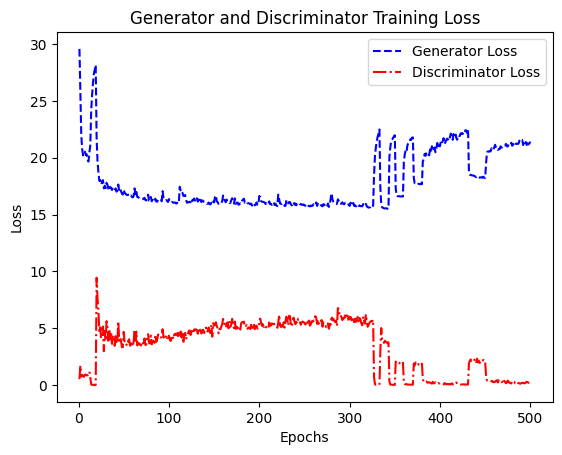

In [40]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_losses, '--b', label='Generator Loss')
plt.plot(epochs, train_discriminator_losses, '-.r', label='Discriminator Loss')
plt.title('Generator and Discriminator Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/train_loss_plot_1.png')
plt.show()

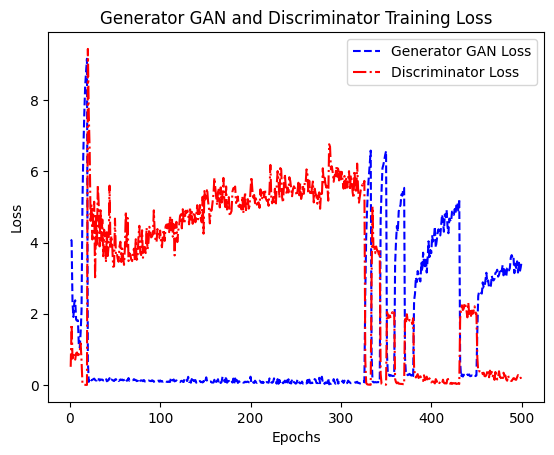

In [41]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_gan_losses, '--b', label='Generator GAN Loss')
plt.plot(epochs, train_discriminator_losses, '-.r', label='Discriminator Loss')
plt.title('Generator GAN and Discriminator Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/train_loss_plot_1.png')
plt.show()

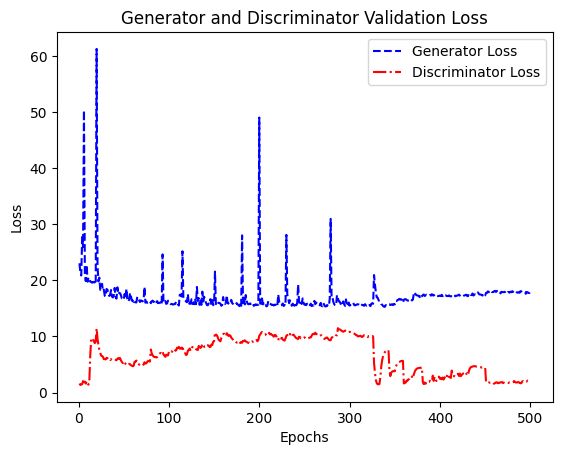

In [42]:
epochs = range(1, len(test_generator_losses) + 1)

plt.plot(epochs, test_generator_losses, '--b', label='Generator Loss')
plt.plot(epochs, test_discriminator_losses, '-.r', label='Discriminator Loss')
plt.title('Generator and Discriminator Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/test_loss_plot_1.png')
plt.show()

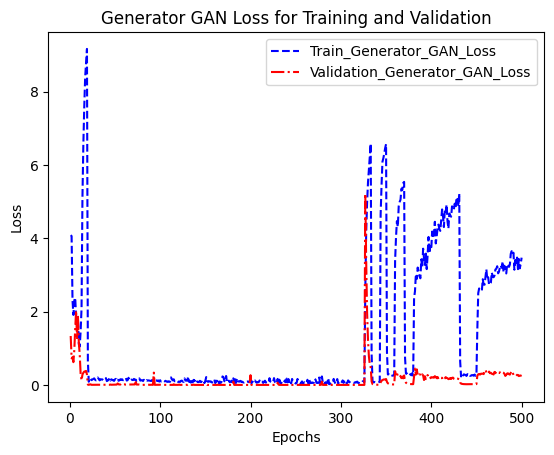

In [43]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_gan_losses, '--b', label='Train_Generator_GAN_Loss')
plt.plot(epochs, test_generator_gan_losses, '-.r', label='Validation_Generator_GAN_Loss')
plt.title('Generator GAN Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_GAN_plot_1.png')
plt.show()

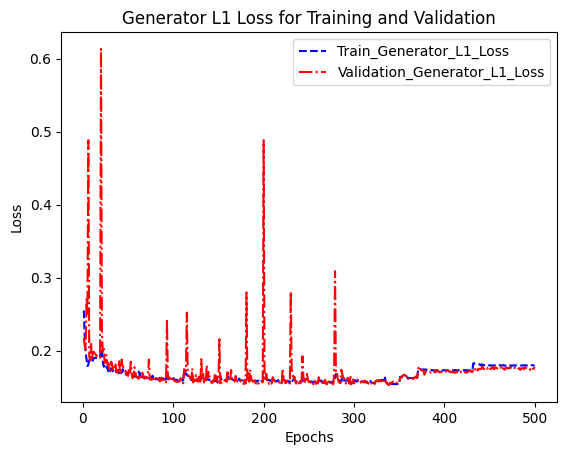

In [44]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_l1_losses, '--b', label='Train_Generator_L1_Loss')
plt.plot(epochs, test_generator_l1_losses, '-.r', label='Validation_Generator_L1_Loss')
plt.title('Generator L1 Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_L1_plot_1.png')
plt.show()

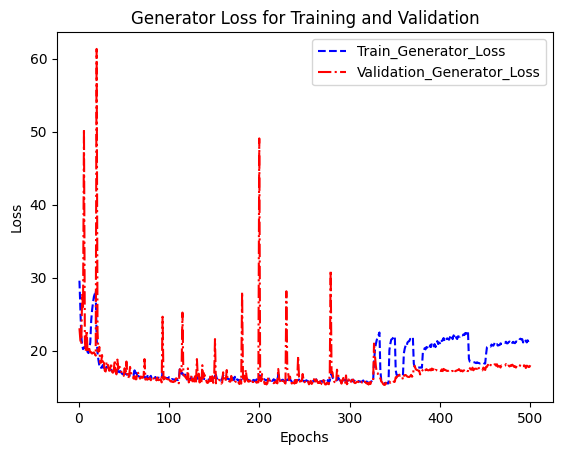

In [45]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_losses, '--b', label='Train_Generator_Loss')
plt.plot(epochs, test_generator_losses, '-.r', label='Validation_Generator_Loss')
plt.title('Generator Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_plot_1.png')
plt.show()

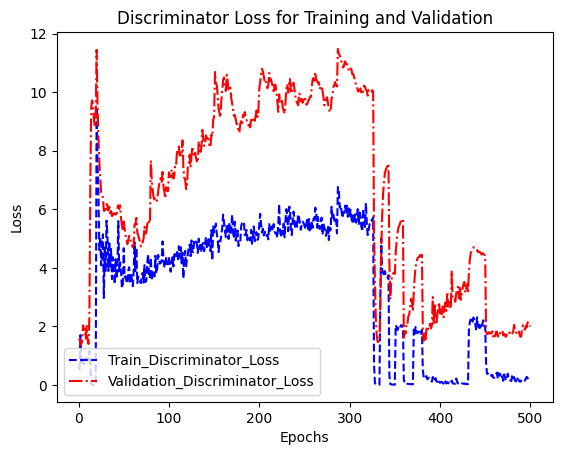

In [46]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_losses, '--b', label='Train_Discriminator_Loss')
plt.plot(epochs, test_discriminator_losses, '-.r', label='Validation_Discriminator_Loss')
plt.title('Discriminator Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_plot_1.png')
plt.show()

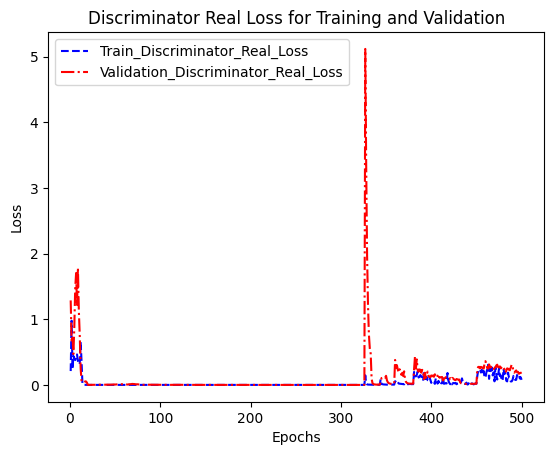

In [47]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_real_losses, '--b', label='Train_Discriminator_Real_Loss')
plt.plot(epochs, test_discriminator_real_losses, '-.r', label='Validation_Discriminator_Real_Loss')
plt.title('Discriminator Real Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_Real_plot_1.png')
plt.show()

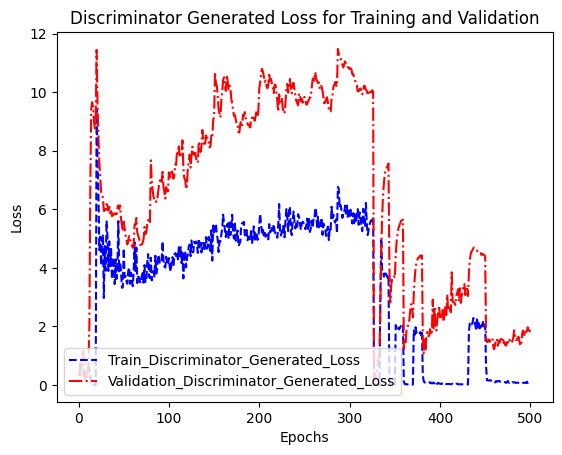

In [48]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_generated_losses, '--b', label='Train_Discriminator_Generated_Loss')
plt.plot(epochs, test_discriminator_generated_losses, '-.r', label='Validation_Discriminator_Generated_Loss')
plt.title('Discriminator Generated Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_Generated_plot_1.png')
plt.show()

In [49]:
import csv
with open('/kaggle/working/dataJan20.csv','w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(all_records)

In [50]:
os.mkdir('/kaggle/working/models')

In [51]:
gen.save('/kaggle/working/models/gen.h5')
gen.save_weights('/kaggle/working/models/gen_weight.keras')
disc.save('/kaggle/working/models/disc.h5')
disc.save_weights('/kaggle/working/models/disc_weight.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/opt/conda/lib/python3.10/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


In [52]:
def prediction(mixture_spectogram,gen):
    number_of_chunks = mixture_spectogram.shape[0]//256
    target = np.zeros([mixture_spectogram.shape[0],512])
    for i in range(number_of_chunks):
        START = i*256
        END = START + 256

        S_mix_new=mixture_spectogram[START:END, :]

        X=tf.reshape(S_mix_new, (1, 256, 512, 1))

        y=gen.predict(X, batch_size=32)
        target[START:END,:] = y.reshape(256,512)
    S_mix_new=mixture_spectogram[-256:, :]
    X=tf.reshape(S_mix_new,(1, 256, 512, 1))
    y=gen.predict(X, batch_size=32)
    target[-256:,:] = y.reshape(256,512)
    y = tfio.audio.inverse_spectrogram(target.astype(np.float32),nfft=1022, window=1022, stride=256, iterations = 100)
    return y

In [53]:
y=prediction(mixture_spectogram,gen)

1/1 [==============================] - 0s 17ms/step


In [54]:
Audio(y,rate=44100)

In [55]:
Audio(mixture_audio,rate=44100)

In [56]:
def prediction(mixture_spectogram, gen):
    number_of_chunks = mixture_spectogram.shape[0] // 256
    target = np.zeros([mixture_spectogram.shape[0], 512])

    for i in range(number_of_chunks):
        START = i * 256
        END = START + 256
        S_mix_new = mixture_spectogram[START:END, :]
        X = tf.reshape(S_mix_new, (1, 256, 512, 1))
        y = gen.predict(X, batch_size=32)
        target[START:END, :] = y.reshape(256, 512)

    S_mix_new = mixture_spectogram[-256:, :]
    X = tf.reshape(S_mix_new, (1, 256, 512, 1))
    y = gen.predict(X, batch_size=32)
    target[-256:, :] = y.reshape(256, 512)

    y = tfio.audio.inverse_spectrogram(target.astype(np.float32),nfft=1022, window=1022, stride=256, iterations = 100)
    return y

In [57]:
# !pip install mir_eval

In [58]:
# import numpy as np
# import mir_eval

# def calculate_metrics_mir_eval(reference_sources, estimated_sources):
#     """
#     Calculate SDR, SIR, and SAR metrics for source separation evaluation using mir_eval.

#     Args:
#         reference_sources (np.ndarray): Ground truth reference sources.
#         estimated_sources (np.ndarray): Estimated sources from the model.

#     Returns:
#         dict: A dictionary containing the SDR, SIR, and SAR scores.
#     """

# #     # Print the shapes of the tensors
# #     print("Shape of reference_sources:", reference_sources.shape)
# #     print("Shape of estimated_sources:", estimated_sources.shape)

#     # Determine the smaller size
#     min_size = min(reference_sources.size, estimated_sources.size)
#     arr1=reference_sources
#     arr2=estimated_sources

#     # Check which array is larger
#     if arr1[0].size > arr2[0].size:
#         larger_arr = arr1
#         smaller_arr = arr2
#     else:
#         larger_arr = arr2
#         smaller_arr = arr1

#     # Get the size of the smaller array
#     smaller_size = smaller_arr.size

#     # Resize the larger array to match the size of the smaller array
#     larger_arr = larger_arr[:smaller_size]

#     # Check which array is larger
#     if arr1[0].size > arr2[0].size:
#         reference_sources=larger_arr
#         estimated_sources=arr2
#     else:
#         reference_sources=arr1
#         estimated_sources=larger_arr
        
# #     # Print the shapes of the tensors
# #     print("Shape of reference_sources:", reference_sources.shape)
# #     print("Shape of estimated_sources:", estimated_sources.shape)

#     sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(
#         reference_sources, estimated_sources, compute_permutation=False
#     )

#     return {
#         "SDR": np.median(sdr),
#         "SIR": np.median(sir),
#         "SAR": np.median(sar),
#     }

In [59]:
# def calculate_metrics(mixture_dir, vocals_dir, gen):
#     metrics = ['SDR', 'SAR']
#     all_scores = {}

#     for metric in metrics:
#         all_scores[metric] = []

#     for mixture_file in os.listdir(mixture_dir):
#         if mixture_file.endswith('.wav'):
#             vocals_file = mixture_file.replace('mixture', 'vocals')
#             mixture_path = os.path.join(mixture_dir, mixture_file)
#             vocals_path = os.path.join(vocals_dir, vocals_file)

#             mixture_audio = load(mixture_path)
#             vocal_audio = load(vocals_path)

#             mixture_spectogram = tfio.audio.spectrogram(mixture_audio, nfft = 1022, window = 1022, stride=256)
#             predicted_spectogram = prediction(mixture_spectogram, gen)

#             scores = calculate_metrics_mir_eval(
#                reference_sources=vocal_audio,
#                estimated_sources=predicted_spectogram.numpy()
# #                 ,
# #                metrics=metrics,
# #                validate=True
#             )

#             for metric in metrics:
#                 all_scores[metric].append(scores[metric])

#     return all_scores

In [60]:
# # Enable NumPy behavior in TensorFlow
# tf.experimental.numpy.experimental_enable_numpy_behavior()
# # Usage
# mixture_dir = '/kaggle/input/nepali-singing-voice-data/nepali_music_source_seperation/valid/mixture'
# vocals_dir = '/kaggle/input/nepali-singing-voice-data/nepali_music_source_seperation/valid/vocals'

# all_scores = calculate_metrics(mixture_dir, vocals_dir, gen)

# # Save metrics to /kaggle/working/models
# os.makedirs('/kaggle/working/models', exist_ok=True)
# for metric, scores in all_scores.items():
#     metric_path = os.path.join('/kaggle/working/models', f'{metric}.npy')
#     np.save(metric_path, scores)

In [61]:
# # Calculate the median
# sdr_value = np.median(all_scores['SDR'])
# sar_value = np.median(all_scores['SAR'])

# # Create a bar plot
# fig, ax = plt.subplots()
# metrics = ['SDR', 'SAR']
# values = [sdr_value, sar_value]

# ax.bar(metrics, values)
# ax.set_xlabel('Metric')
# ax.set_ylabel('Value')
# ax.set_title('Source Separation Evaluation Metrics')

# plt.show()